In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os, sys
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *
from strategies import *
from metrics import *
import universal as up
from universal import tools, algos
from universal.result import AlgoResult, ListResult
import random

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

np.random.RandomState(seed=12345)

import warnings
warnings.filterwarnings('ignore')

RandomState(MT19937) at 0x7F34B9442490

In [9]:
def valid_G4P_passive(strategy, paras, phs, _eps_rng_delta=0.01, max_iter=5):
    def valid_G4P_passive_run(_eps):
        paras['passive_eps'] = _eps
#         paras['passive_gamma'] = _gamma
        maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

        results = []
        concat_result_dict = {}

        data_path1 = './stock_data/NYSE_stock_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path1)
        cov_train, choice = data['cov_train'], data['choice']
        if paras['inverse']:
            choice = choice[::-1]
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        result_dict = {}     
        strategy_name = strategy.split('(')[0]
        rt_v, x_vec = eval(strategy)
        result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
        if strategy_name in concat_result_dict:
            concat_result_dict[strategy_name][0] += rt_v.copy()
            concat_result_dict[strategy_name][1] += x_vec.copy()
            concat_result_dict[strategy_name][2] += [sample_Y0.copy()]
        else:
            concat_result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
        results.append(result_dict)
        rt_v, x_vec, sample_Y0 = concat_result_dict[strategy_name]
        B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
        B = pd.DataFrame(B)
        Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
        result = AlgoResult(Y, B)
        result.set_rf_rate(paras['rf'])
        result.fee = 0.0025
        tw = result.total_wealth
        print(tw)
        return tw
    
    cov = matern32()
    gp = GaussianProcess(cov, optimize=False, usegrads=True)
    acq = Acquisition(mode='Entropy')
#     param = {'_eps': ('cont', _eps_rng),
#              '_gamma': ('cont', _gamma_rng)}
    _eps_rng = [paras['passive_eps']-_eps_rng_delta, paras['passive_eps']+_eps_rng_delta]
    param = {'_eps': ('cont', _eps_rng)}

    gpgo = GPGO(gp, acq, valid_G4P_passive_run, param)
    gpgo.run(max_iter=max_iter)
    rs=gpgo.getResult()[0]
    _eps = rs['_eps']
    return _eps

In [31]:
def run(paras, strategy_lst, figsize=(10,5), phase_cnt=12, disp=True):
    if not disp:
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

    results = []
    concat_result_dict = {}
    for phs in range(0, phase_cnt):
        print('Phase %d' % phs)
        data_path1 = './stock_data/NYSE_stock_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path1)
        cov_train, choice = data['cov_train'], data['choice']
        if paras['inverse']:
            choice = choice[::-1]
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        result_dict = {}        
        for strategy in strategy_lst:
            strategy_name = strategy.split('(')[0]
            print(strategy_name)
#             if phs > 0: # start validation
#                 if strategy_name=='G4P_passive':
#                     _eps = valid_G4P_passive(strategy, paras, phs-1)
#                     paras['passive_eps'] = _eps
#                     paras['passive_gamma'] = _gamma
#                 elif strategy_name=='G4P':
#                     _gamma = valid_G4P(strategy, paras, phs-1)
#                     paras['gamma'] = _gamma
            rt_v, x_vec = eval(strategy)
            result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
            if strategy_name in concat_result_dict:
                concat_result_dict[strategy_name][0] += rt_v.copy()
                concat_result_dict[strategy_name][1] += x_vec.copy()
                concat_result_dict[strategy_name][2] += [sample_Y0.copy()]
            else:
                concat_result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
            if disp:
                disp_k = 3
                fig, axs = plt.subplots(disp_k, disp_k, figsize=(30,6))
                for i in range(disp_k):
                    ixv = random.randint(0,len(x_vec)-4)
                    for j in range(disp_k):
                        xv = x_vec[ixv+j]
                        axs[i,j].bar(range(len(xv)),xv)
                plt.show()
        results.append(result_dict)

    if not disp:
        sys.stdout = old_stdout
    return results, concat_result_dict

In [11]:
def display(strategy_name, concat_results, paras, figsize=(10,5)):
    rt_v, x_vec, sample_Y0 = concat_results[strategy_name]
    B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
    B = pd.DataFrame(B)
    Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
    result = AlgoResult(Y, B)
    result.set_rf_rate(paras['rf'])
    print('========================================================')
    print(strategy_name)
    print('--------------------------------------------------------')
    print('fee = 0')
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=False, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.0025
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=False, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.005
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure()
    result.plot(weights=False, assets=False, ucrp=False, logy=False)
    plt.show()
    print()

In [12]:
def display_phs(strategy_name, results, phs, paras, figsize=(10,5)):
    print('========================================================')
    print('Phase %d'%phs)
    for strategy in strategy_lst:
        strategy_name = strategy.split('(')[0]
        rt_v, x_vec, sample_Y0 = results[phs][strategy_name]
        
        B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
        B = pd.DataFrame(B)
        Y = pd.DataFrame(sample_Y0[0])
#         print(B.shape)
#         print(Y.shape)
        result = AlgoResult(Y, B)
        result.set_rf_rate(paras['rf'])
        print(strategy_name)
        print('--------------------------------------------------------')
        print('fee = 0')
        print(result.summary())
        print('Total wealth:', result.total_wealth)

In [34]:
strategy_lst = ['G4P_passive(predY0, std_varY0, sample_Y0, cov, paras["passive_eps"], paras["passive_gamma"])']

Phase 0
./tmp2/NYSE_phase00_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 69 / 100


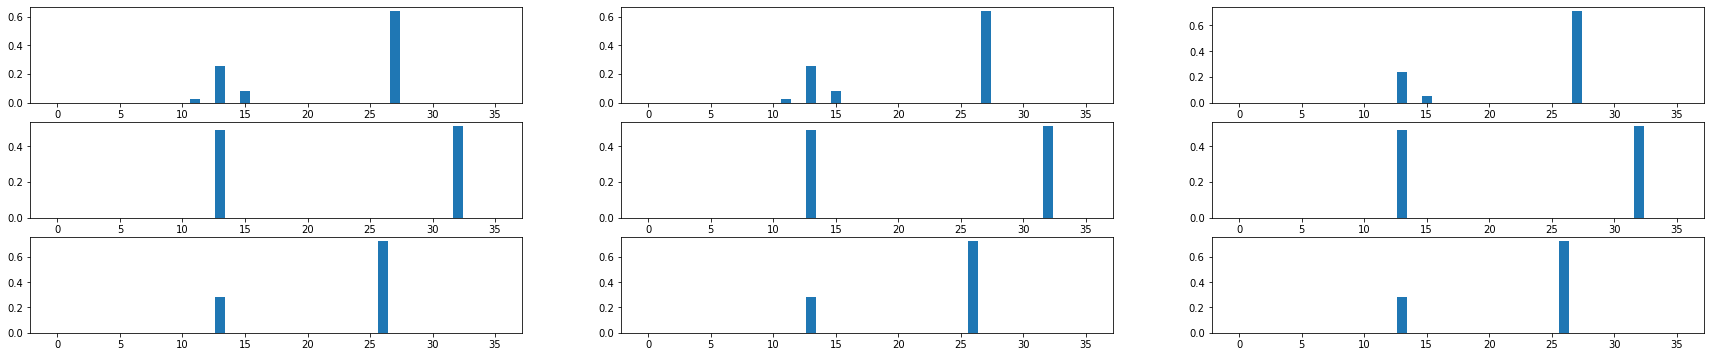

Phase 1
./tmp2/NYSE_phase01_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 79 / 100


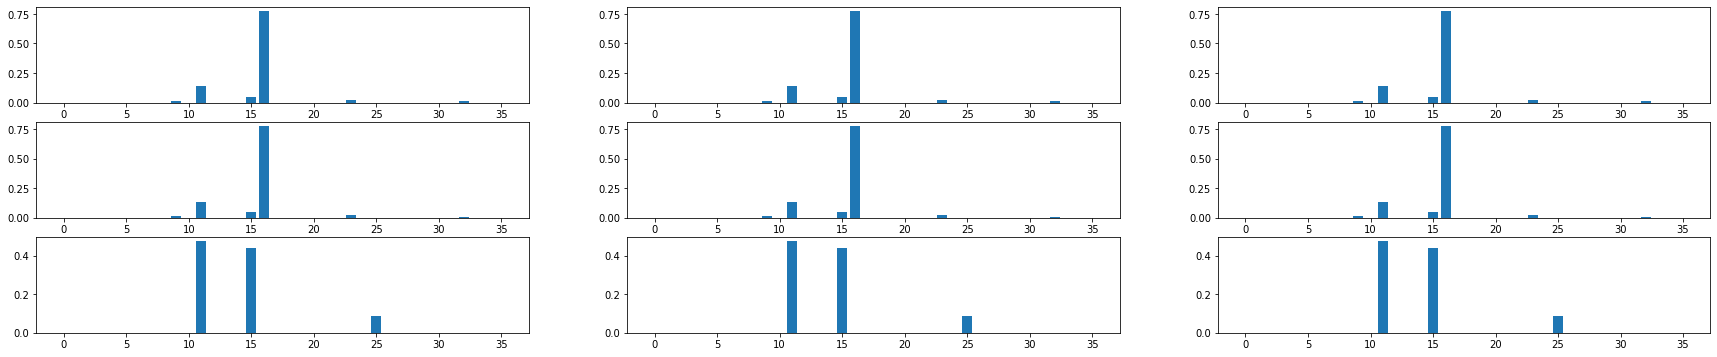

Phase 2
./tmp2/NYSE_phase02_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 78 / 100


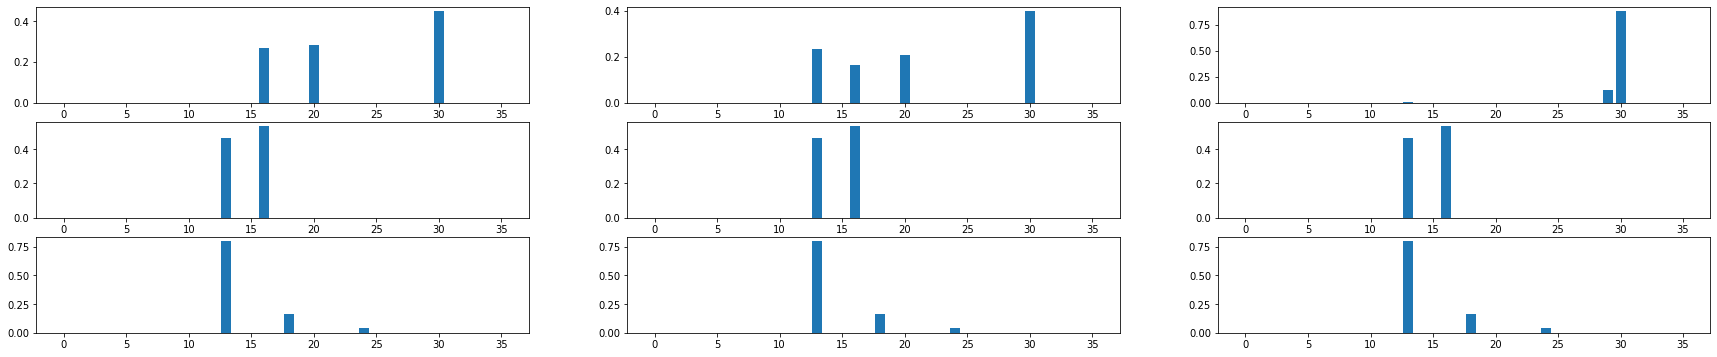

Phase 3
./tmp2/NYSE_phase03_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 70 / 100


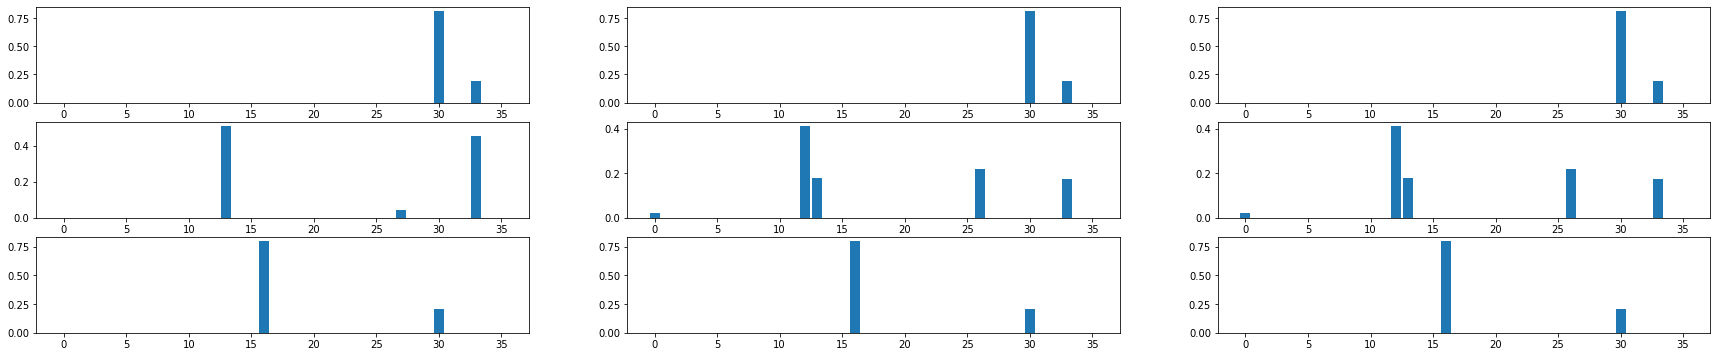

Phase 4
./tmp2/NYSE_phase04_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 71 / 100


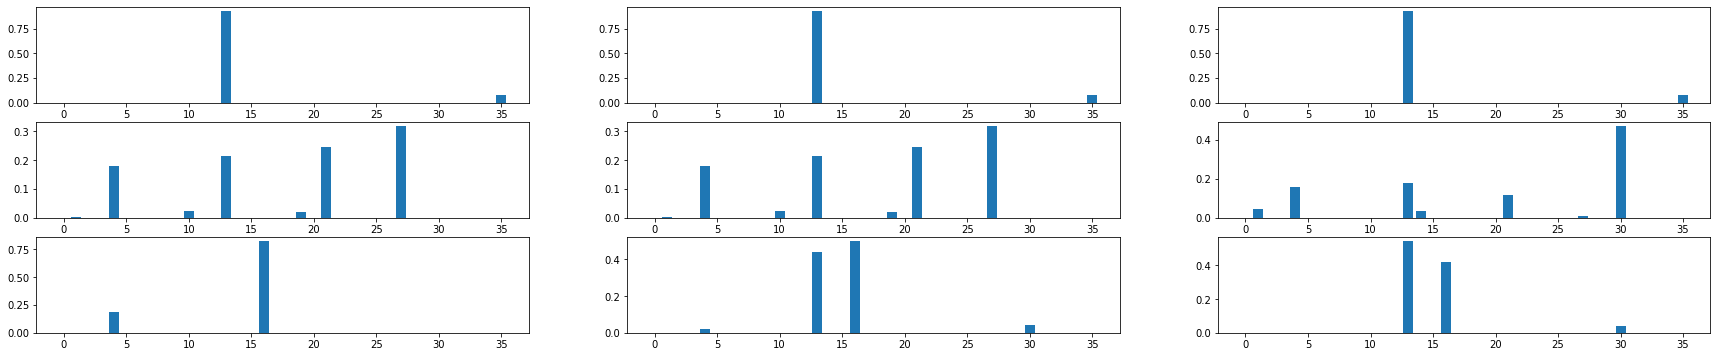

Phase 5
./tmp2/NYSE_phase05_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 73 / 100


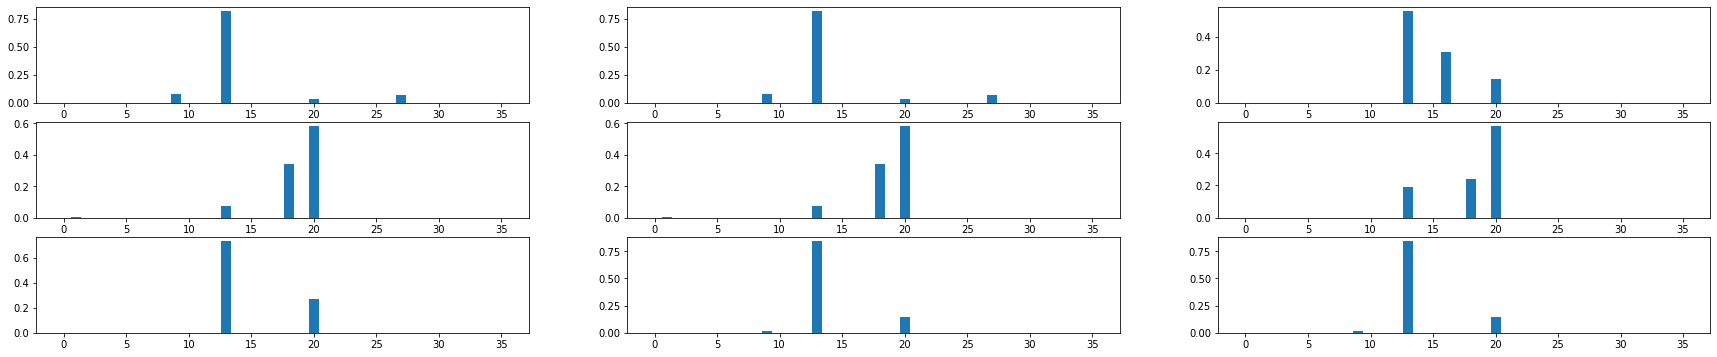

Phase 6
./tmp2/NYSE_phase06_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 57 / 100


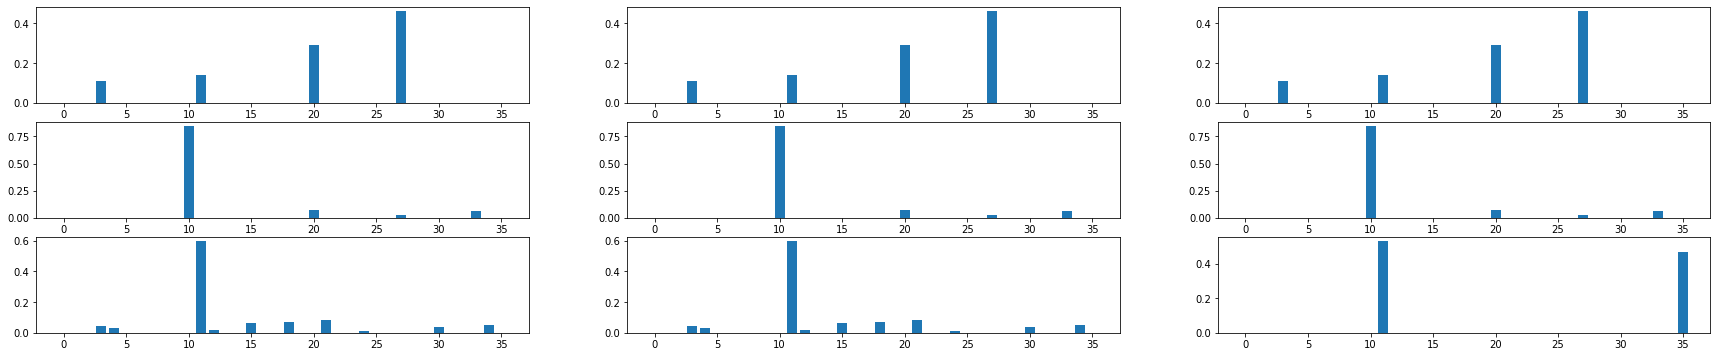

Phase 7
./tmp2/NYSE_phase07_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 50 / 100


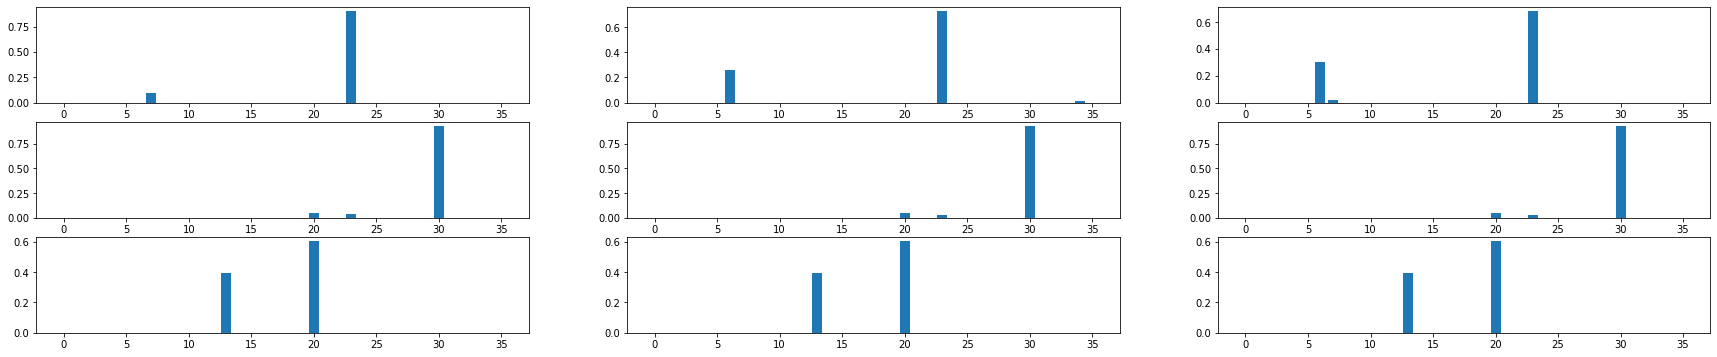

Phase 8
./tmp2/NYSE_phase08_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive


/home/linaiqi/anaconda3/envs/dgpg/lib/python3.7/site-packages/cvxpy/problems/problem.py:1295: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


No opt solution: 80 / 100


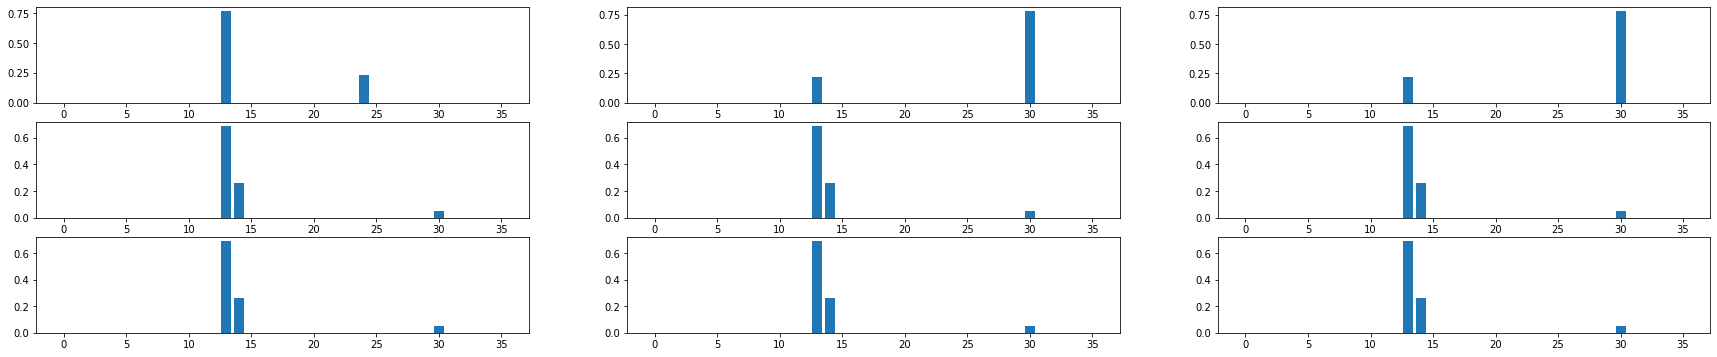

Phase 9
./tmp2/NYSE_phase09_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 72 / 100


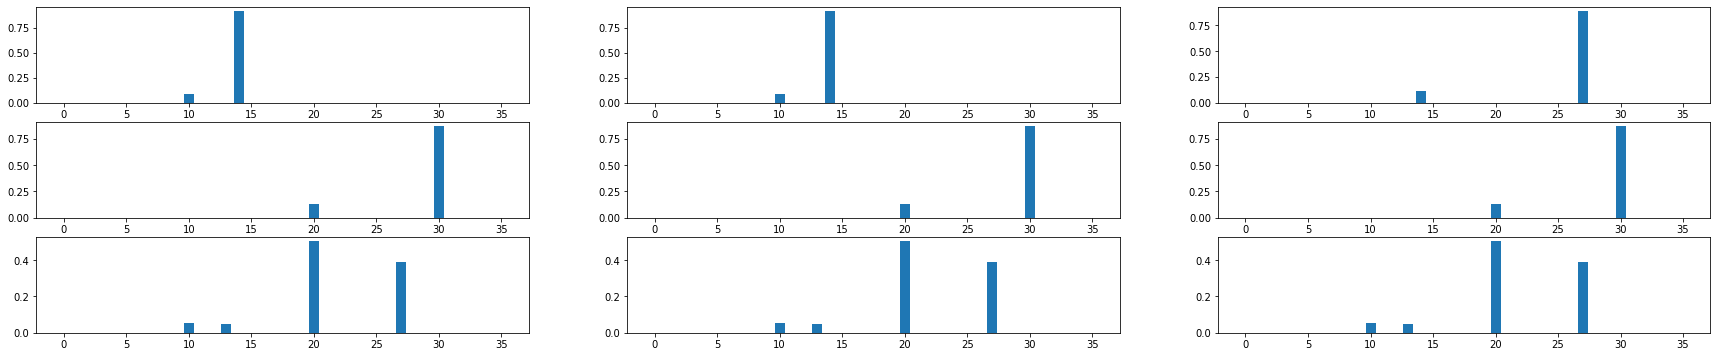

Phase 10
./tmp2/NYSE_phase10_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 71 / 100


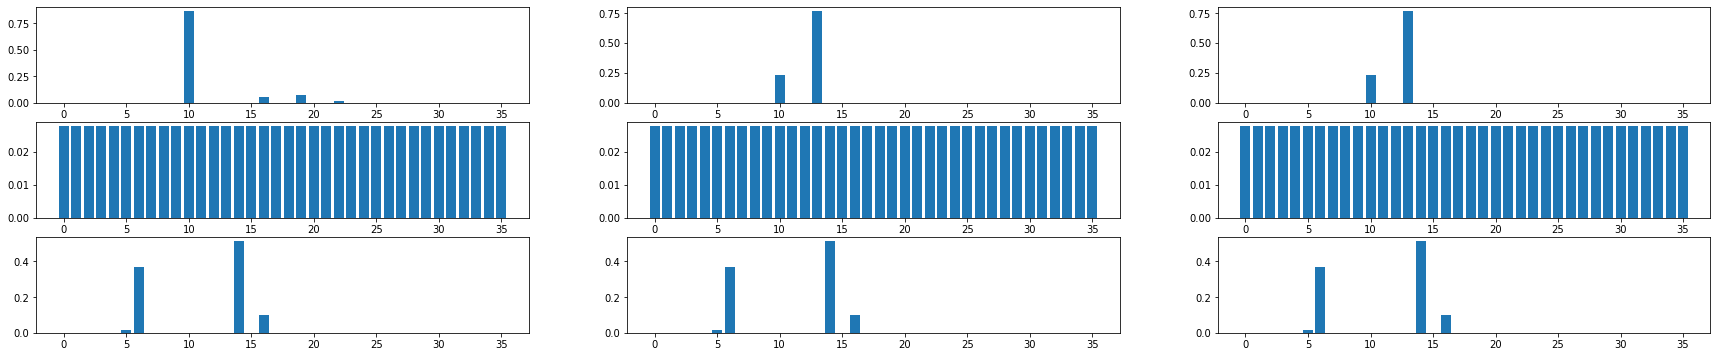

Phase 11
./tmp2/NYSE_phase11_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 65 / 100


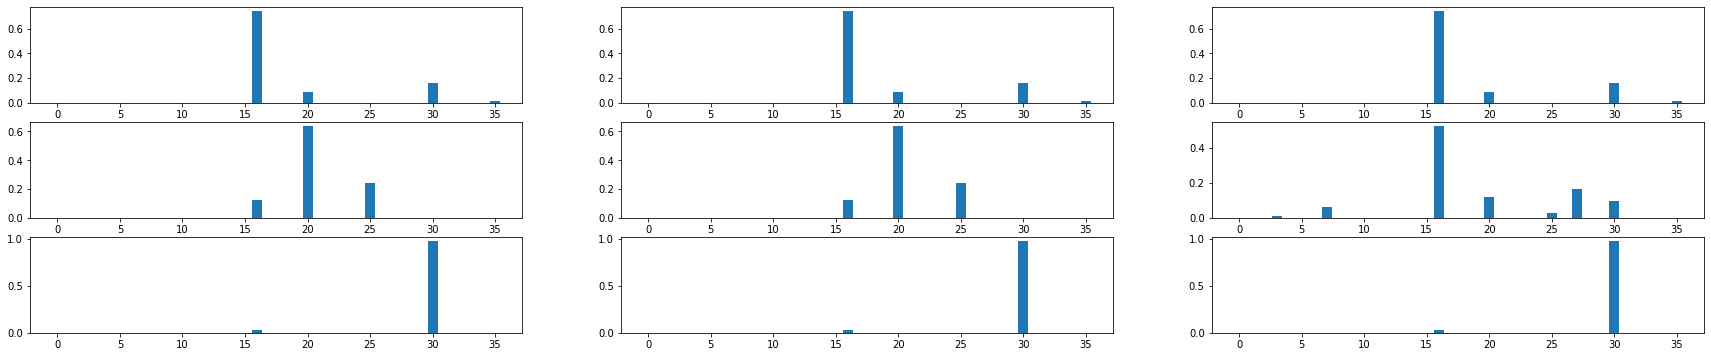

Phase 12
./tmp2/NYSE_phase12_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 66 / 100


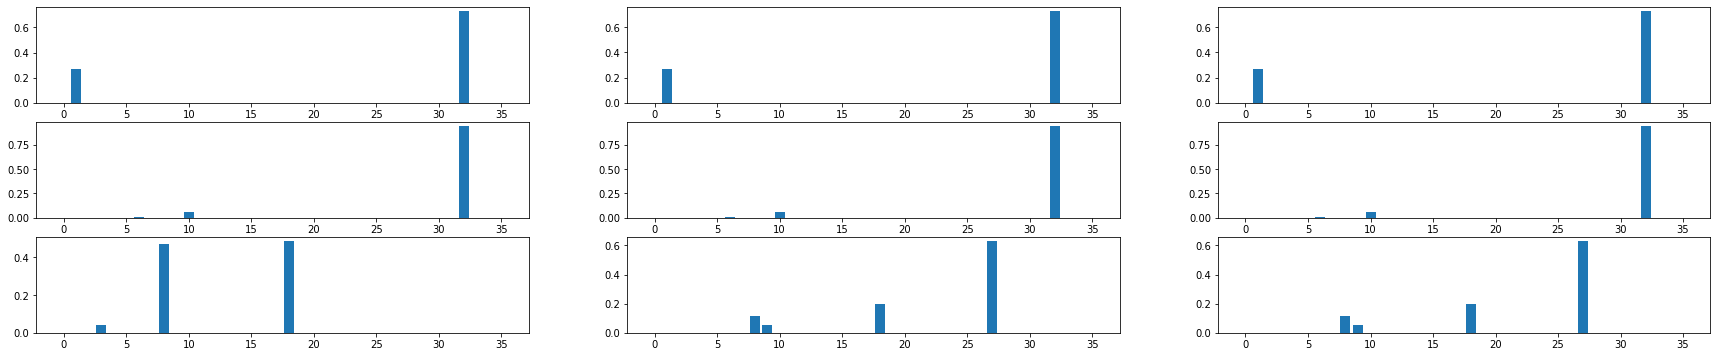

Phase 13
./tmp2/NYSE_phase13_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 53 / 100


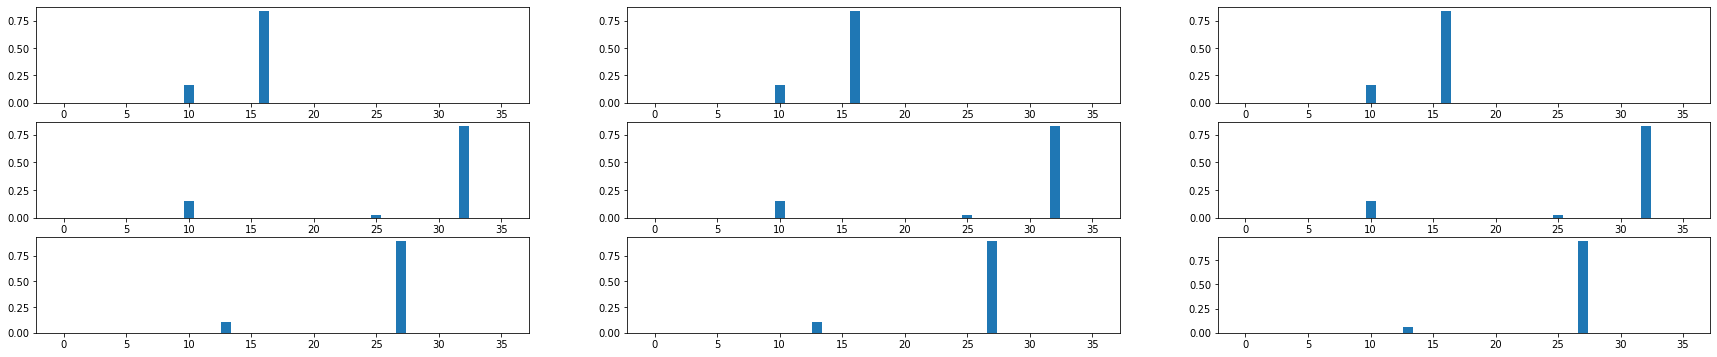

Phase 14
./tmp2/NYSE_phase14_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 60 / 100


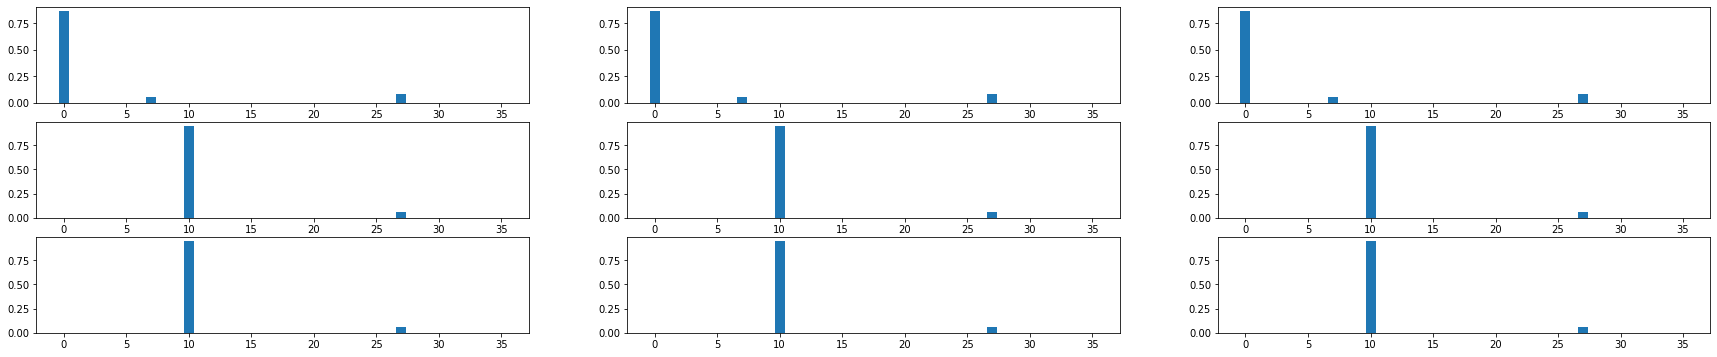

Phase 15
./tmp2/NYSE_phase15_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 57 / 100


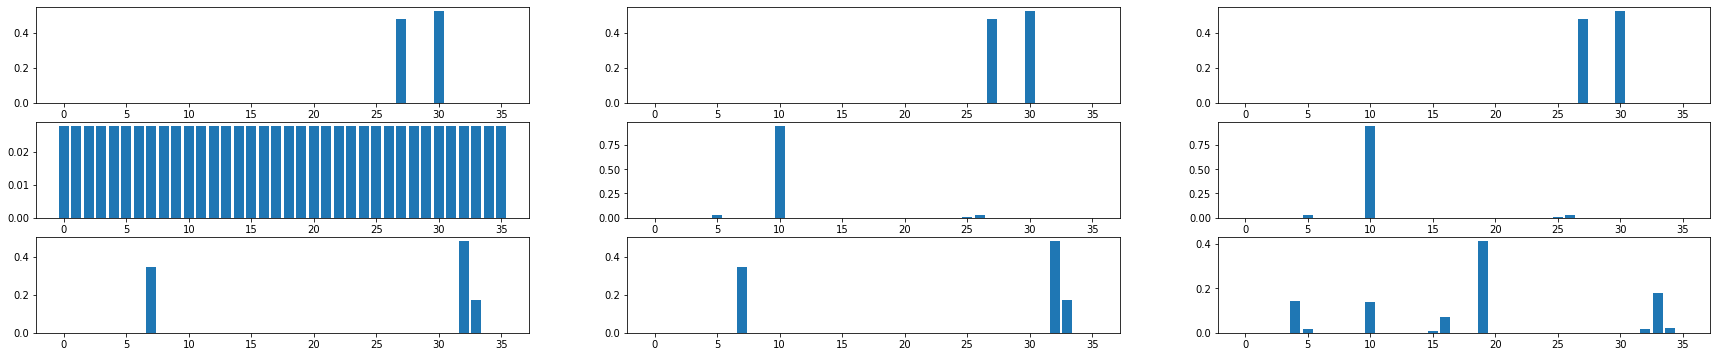

Phase 16
./tmp2/NYSE_phase16_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 39 / 100


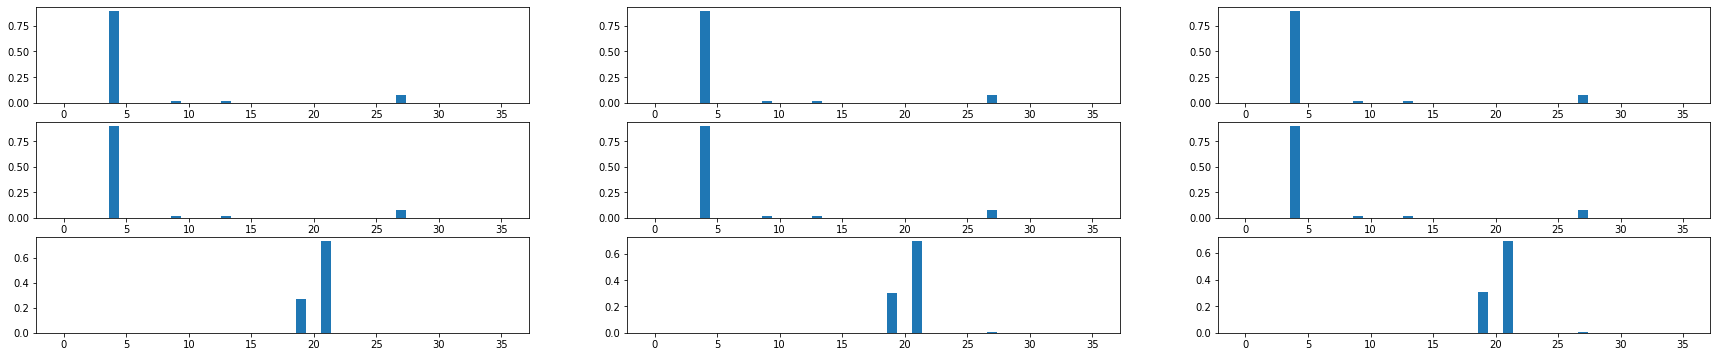

Phase 17
./tmp2/NYSE_phase17_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 75 / 100


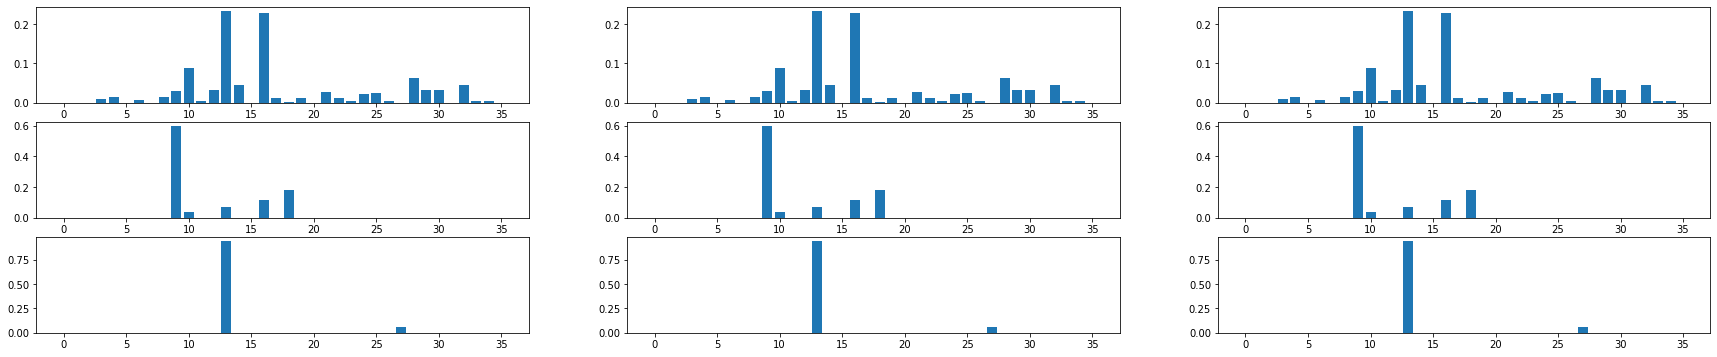

Phase 18
./tmp2/NYSE_phase18_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 84 / 100


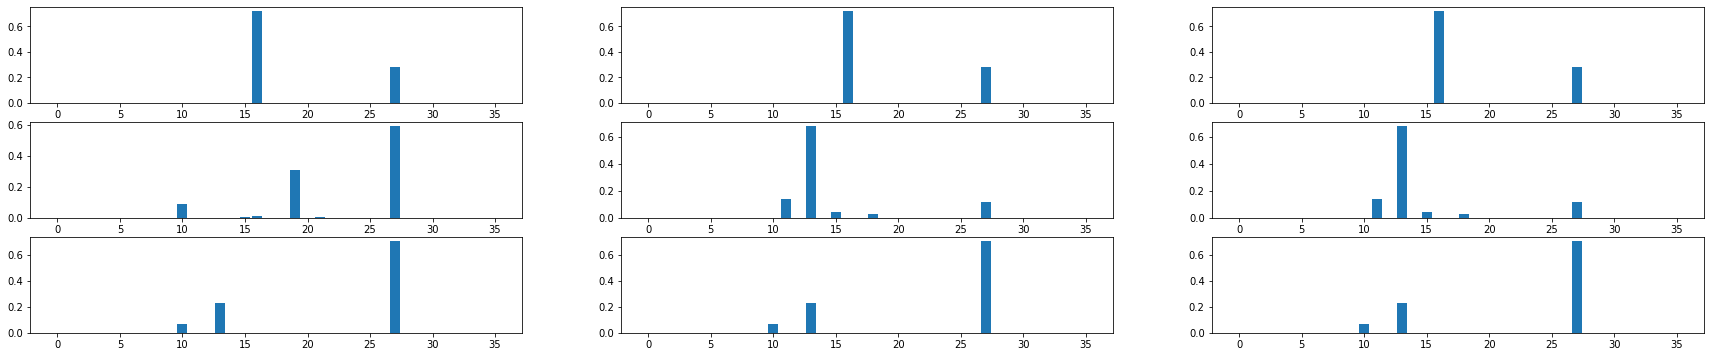

Phase 19
./tmp2/NYSE_phase19_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 71 / 100


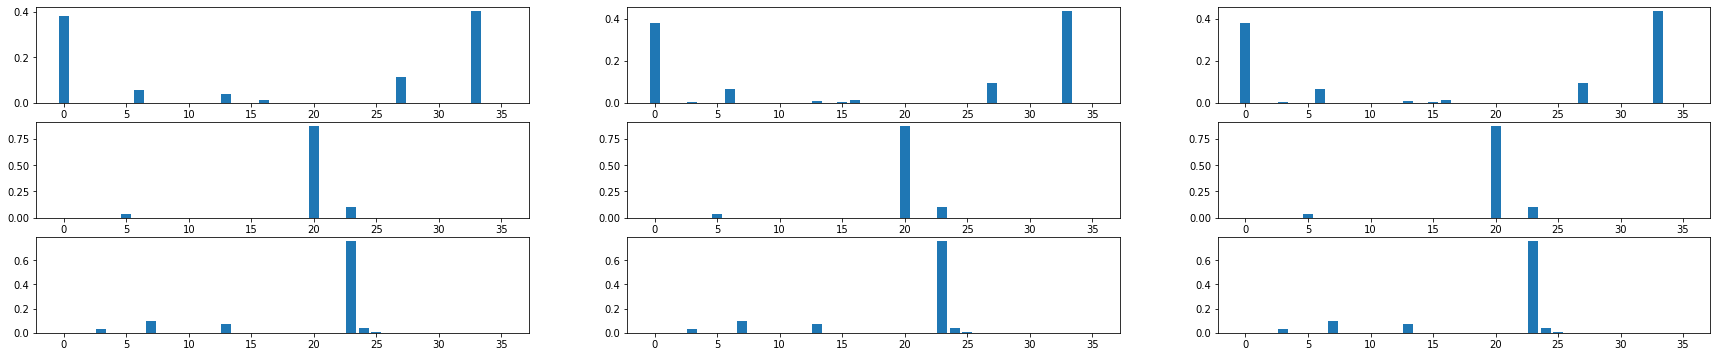

Phase 20
./tmp2/NYSE_phase20_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 65 / 100


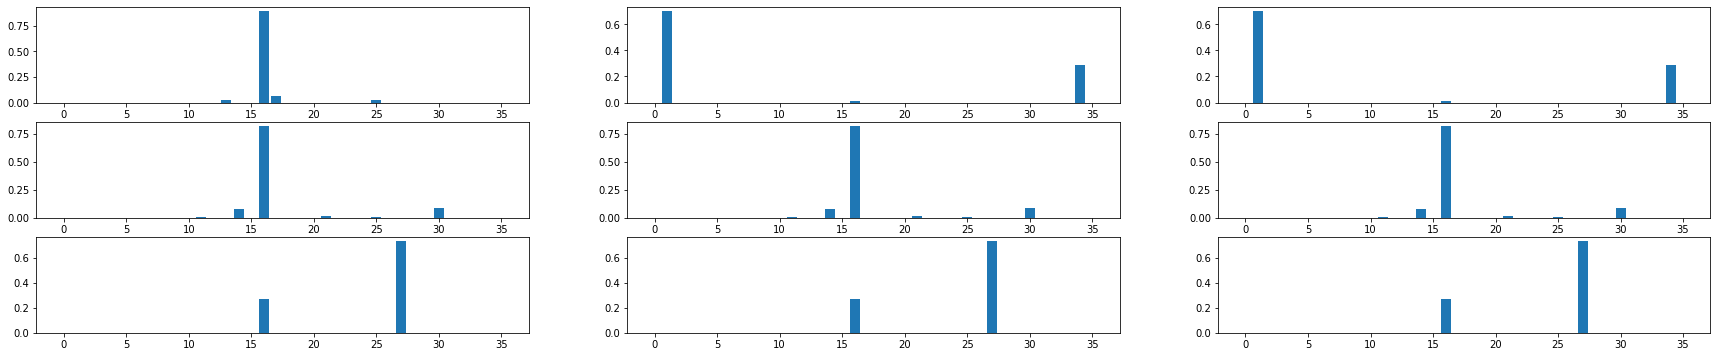

Phase 21
./tmp2/NYSE_phase21_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 64 / 100


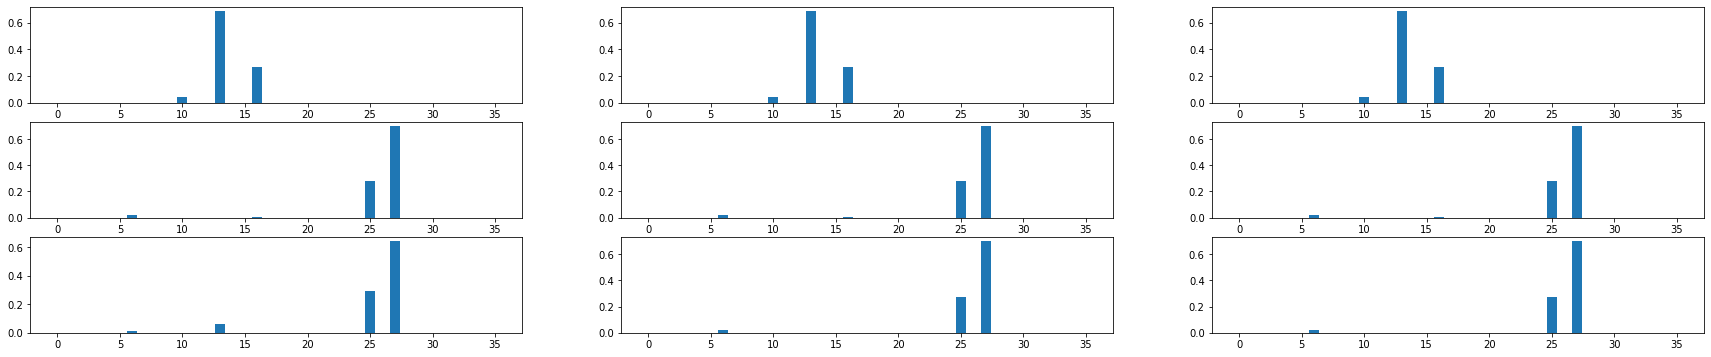

Phase 22
./tmp2/NYSE_phase22_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 64 / 100


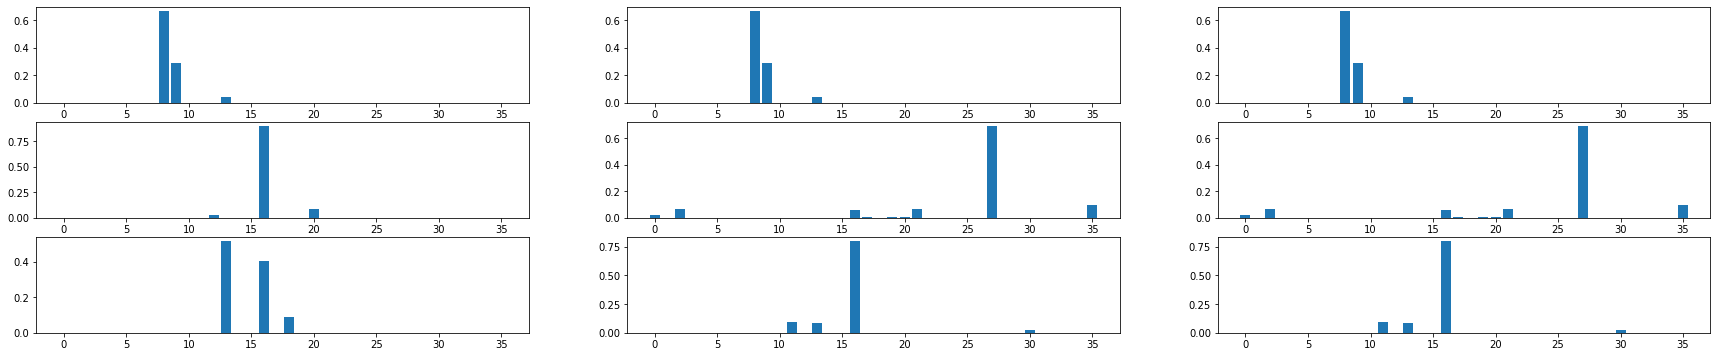

Phase 23
./tmp2/NYSE_phase23_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 59 / 100


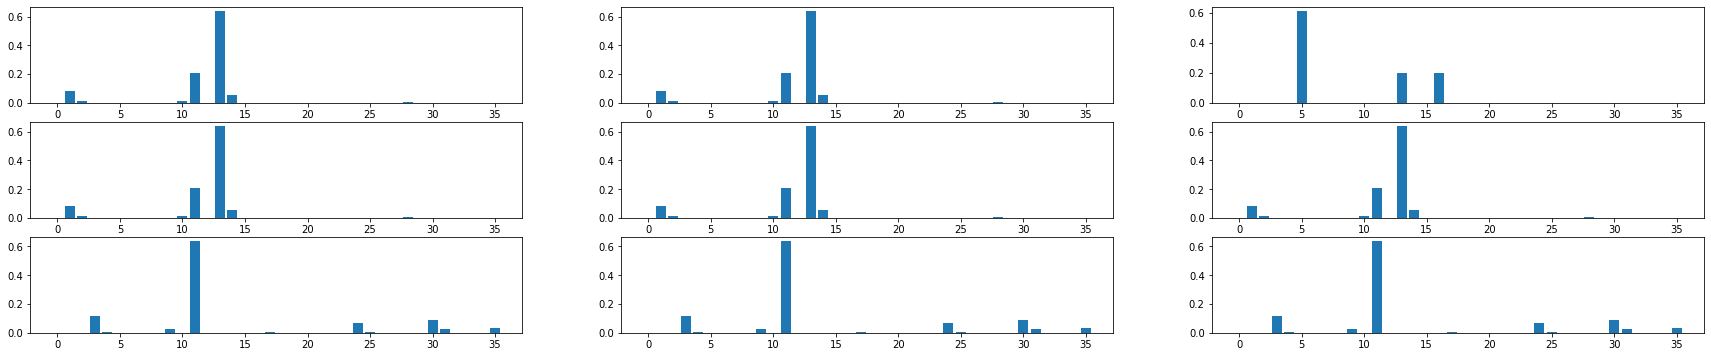

Phase 24
./tmp2/NYSE_phase24_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 40 / 100


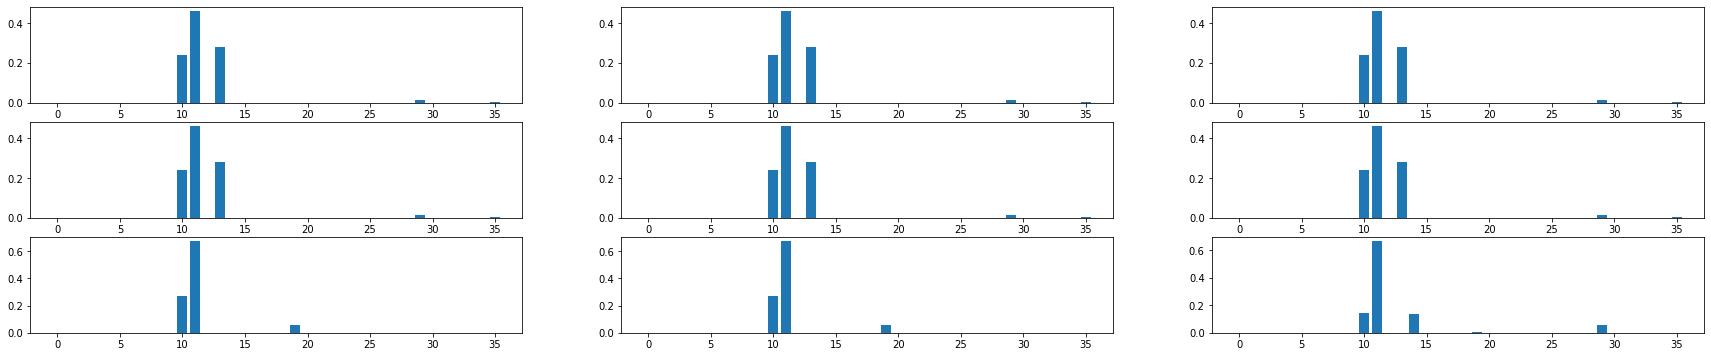

Phase 25
./tmp2/NYSE_phase25_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 29 / 100


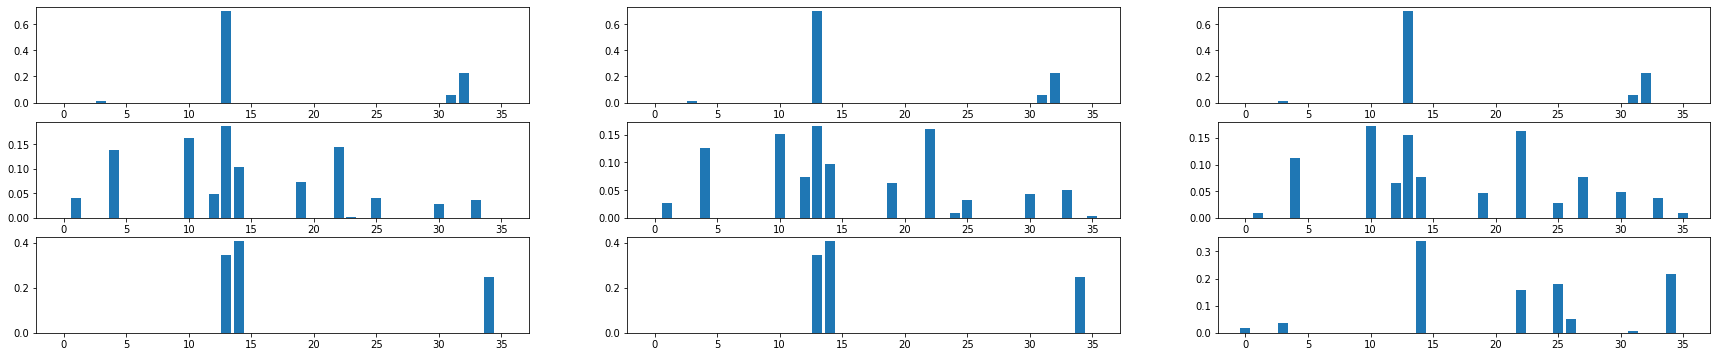

Phase 26
./tmp2/NYSE_phase26_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 46 / 100


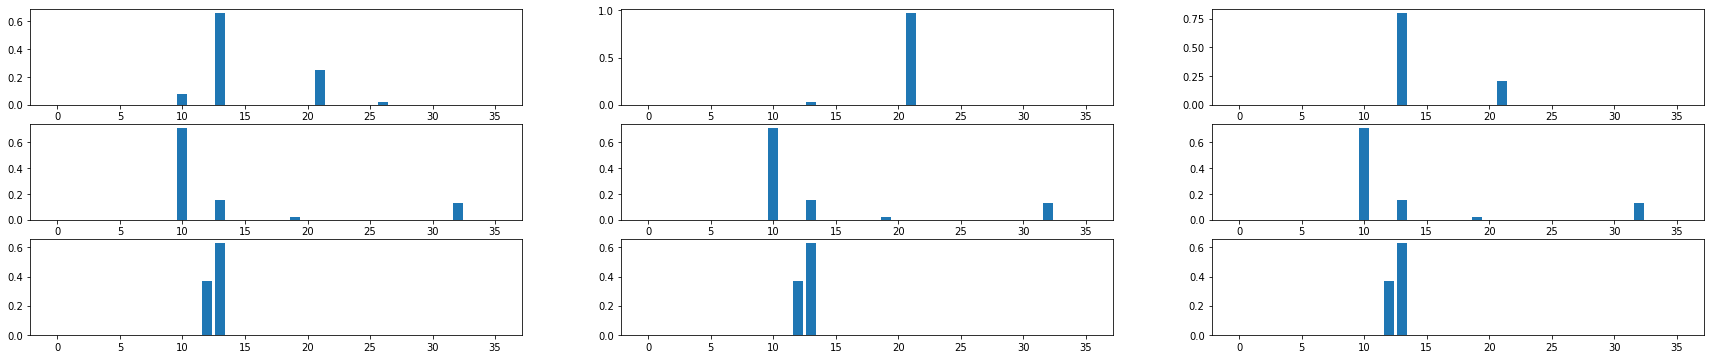

Phase 27
./tmp2/NYSE_phase27_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 18 / 100


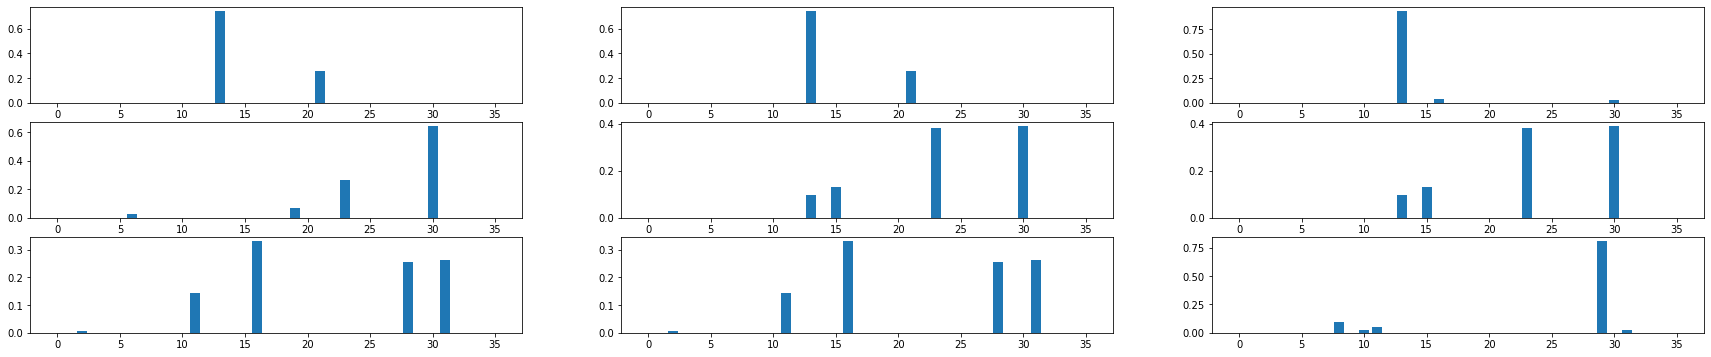

Phase 28
./tmp2/NYSE_phase28_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 53 / 100


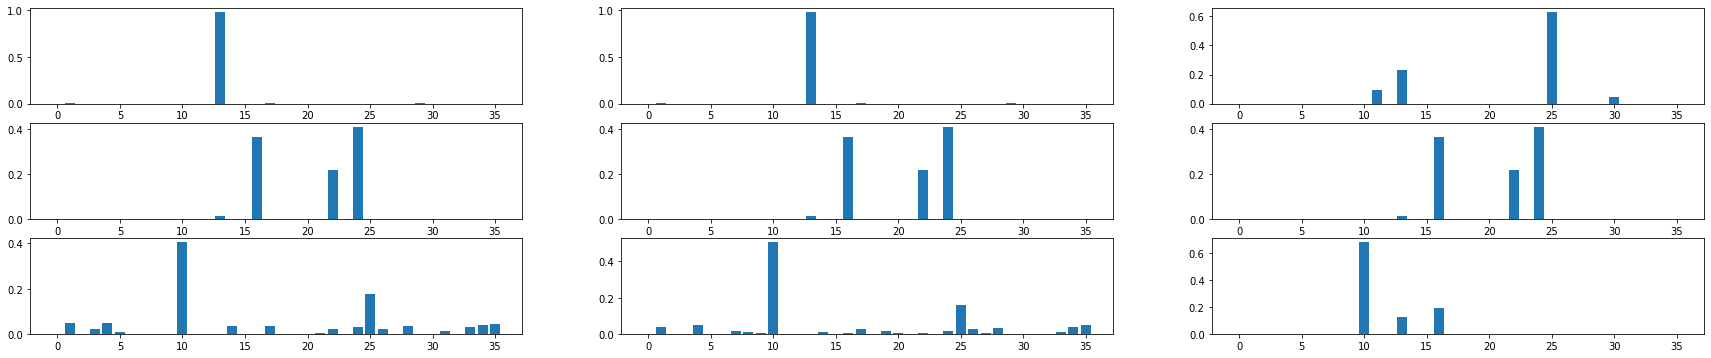

Phase 29
./tmp2/NYSE_phase29_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 81 / 100


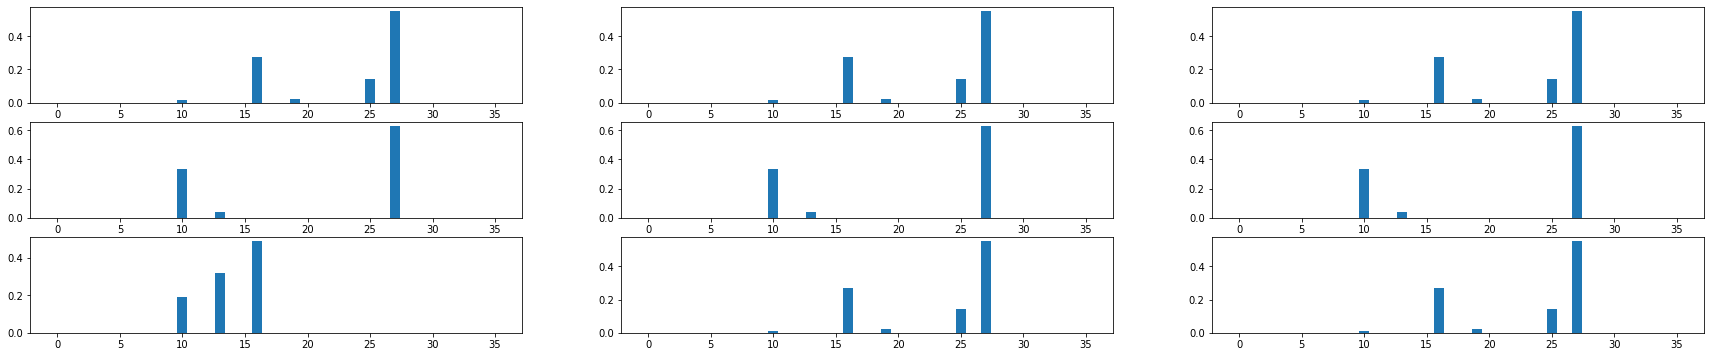

Phase 30
./tmp2/NYSE_phase30_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 77 / 100


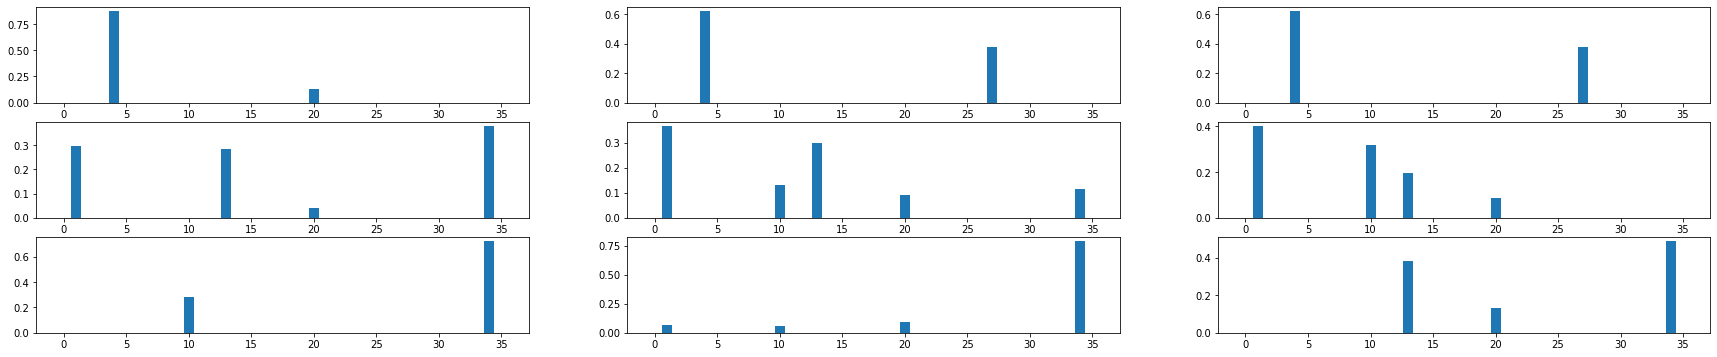

Phase 31
./tmp2/NYSE_phase31_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 77 / 100


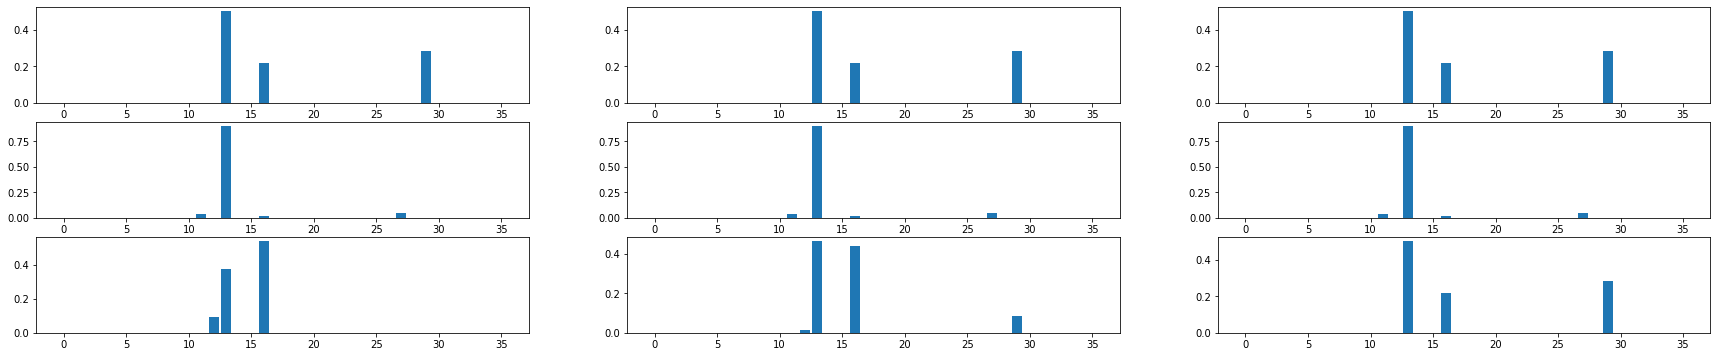

Phase 32
./tmp2/NYSE_phase32_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 67 / 100


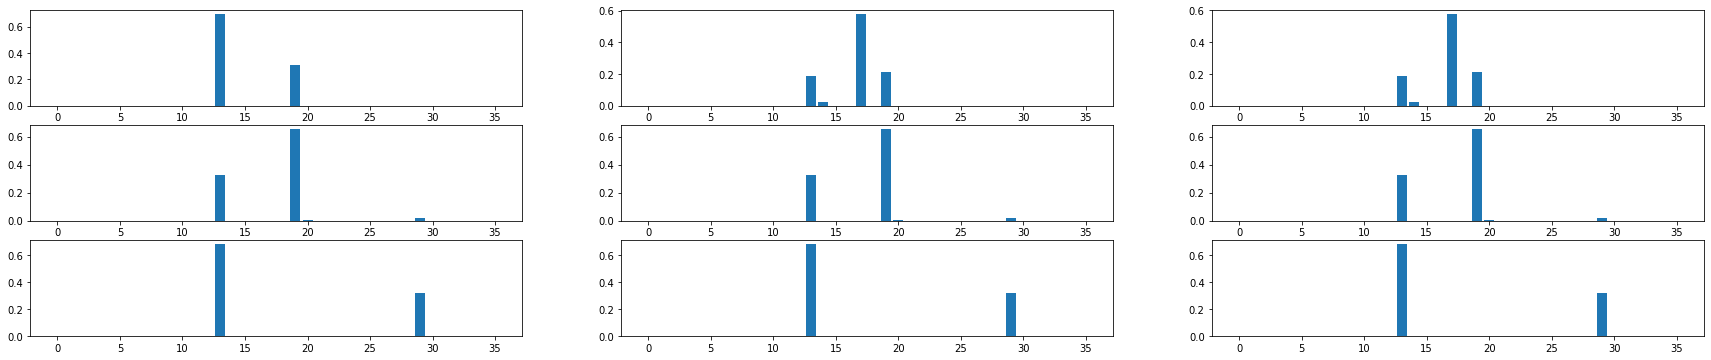

Phase 33
./tmp2/NYSE_phase33_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 75 / 100


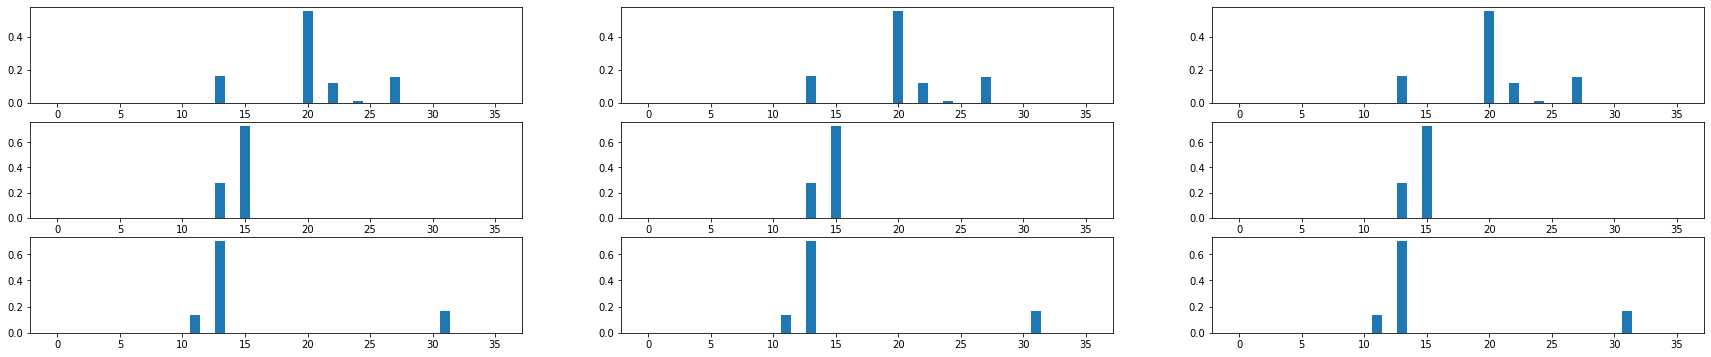

Phase 34
./tmp2/NYSE_phase34_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 77 / 100


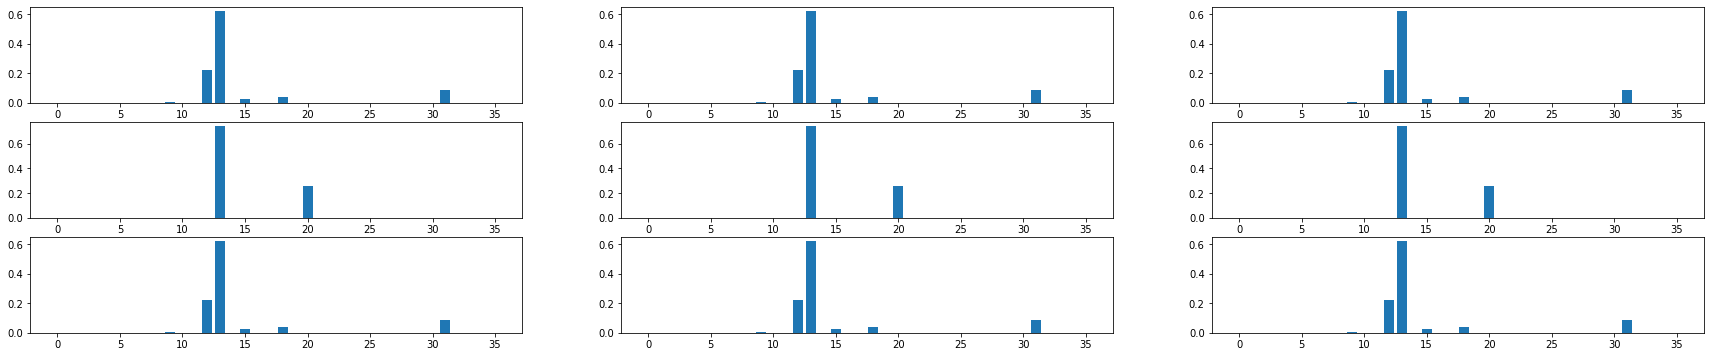

Phase 35
./tmp2/NYSE_phase35_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 72 / 100


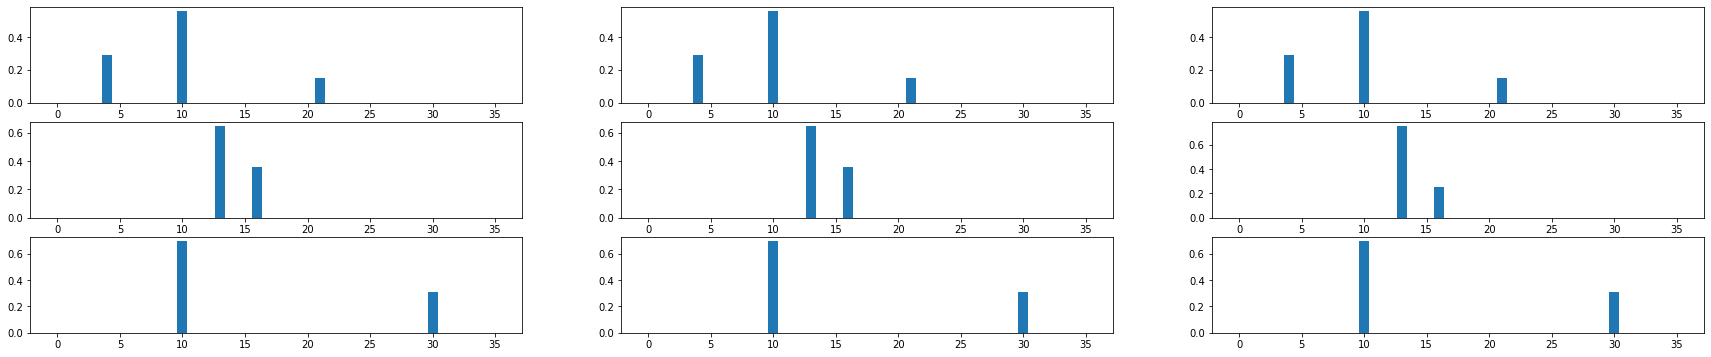

Phase 36
./tmp2/NYSE_phase36_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 73 / 100


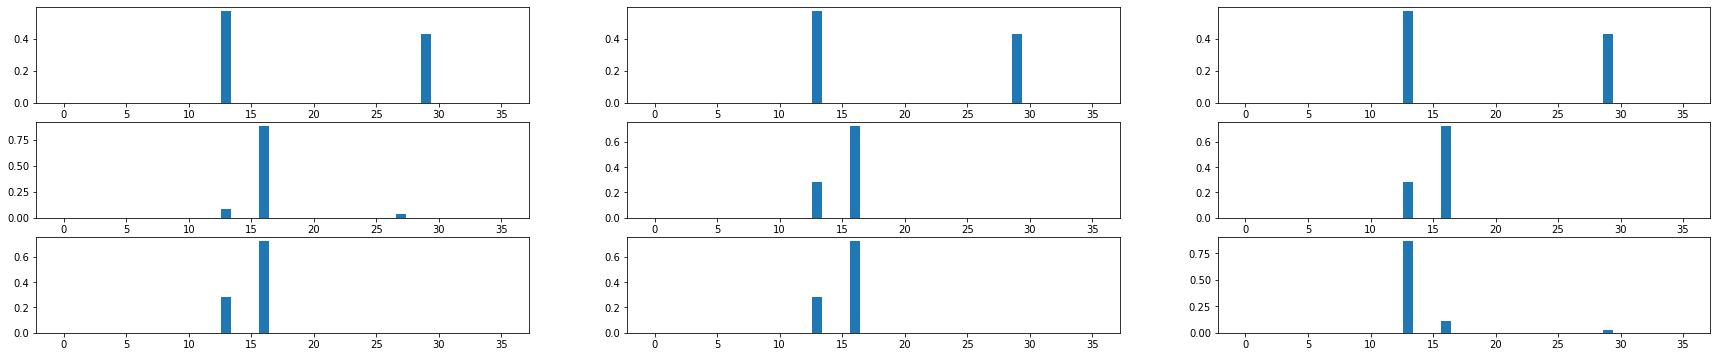

Phase 37
./tmp2/NYSE_phase37_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 61 / 100


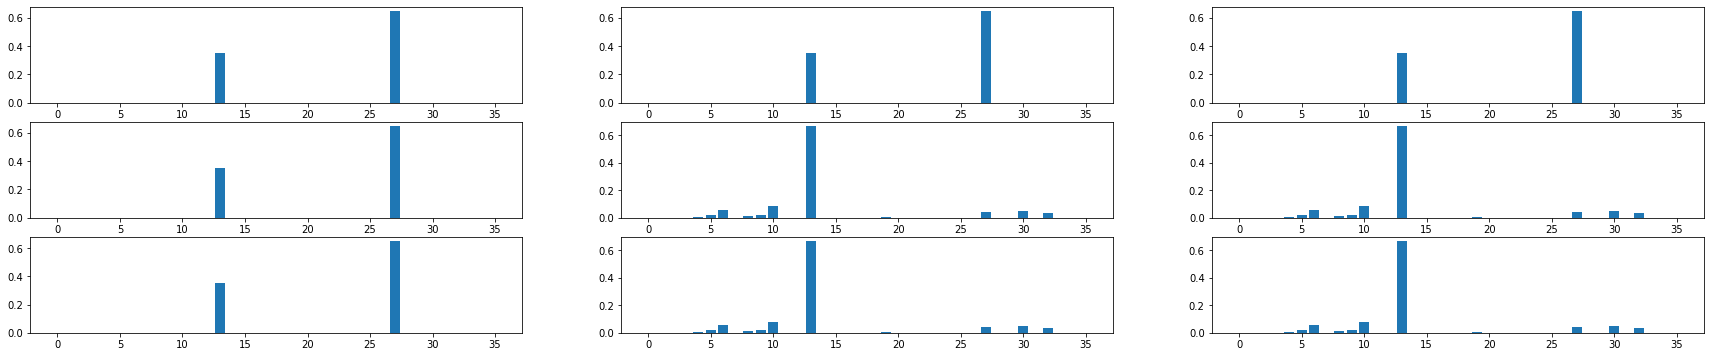

Phase 38
./tmp2/NYSE_phase38_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 83 / 100


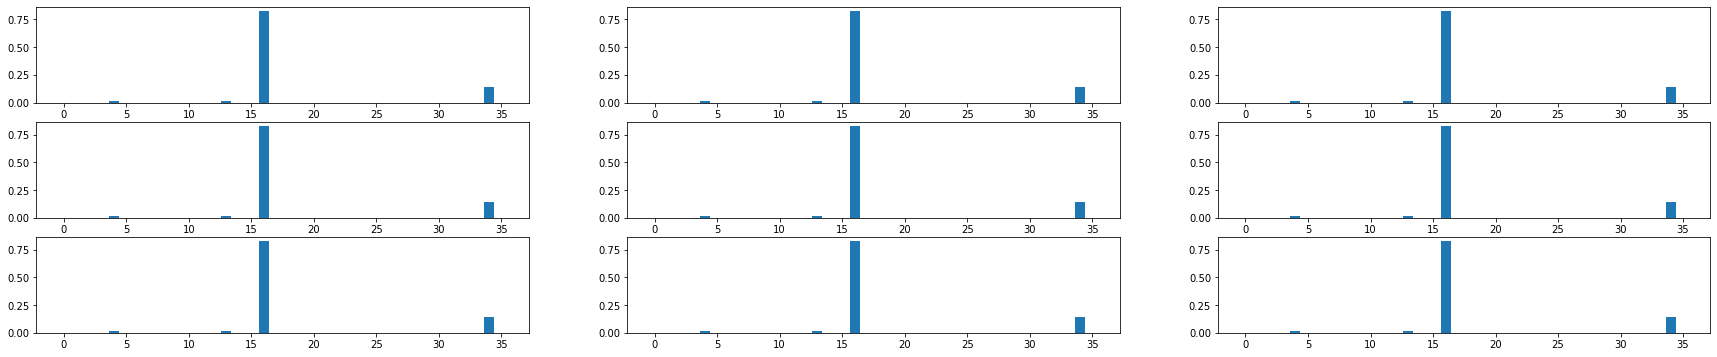

Phase 39
./tmp2/NYSE_phase39_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 79 / 100


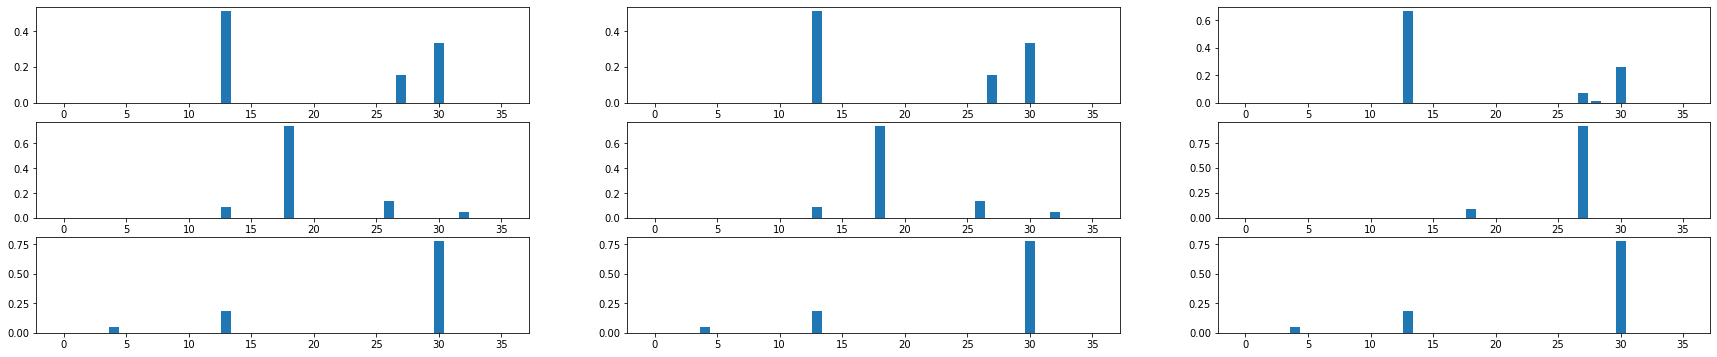

Phase 40
./tmp2/NYSE_phase40_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 66 / 100


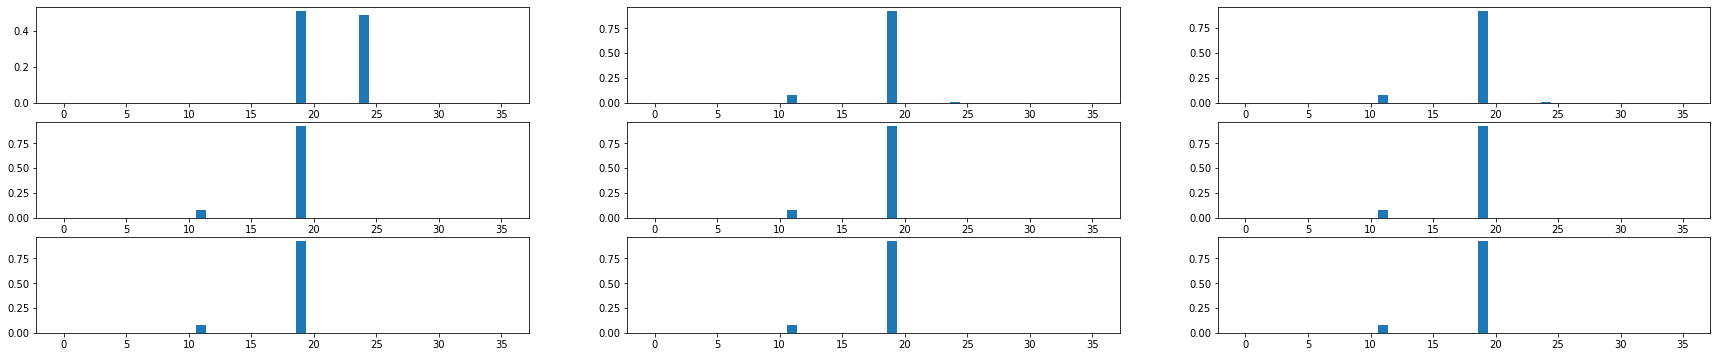

Phase 41
./tmp2/NYSE_phase41_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 53 / 100


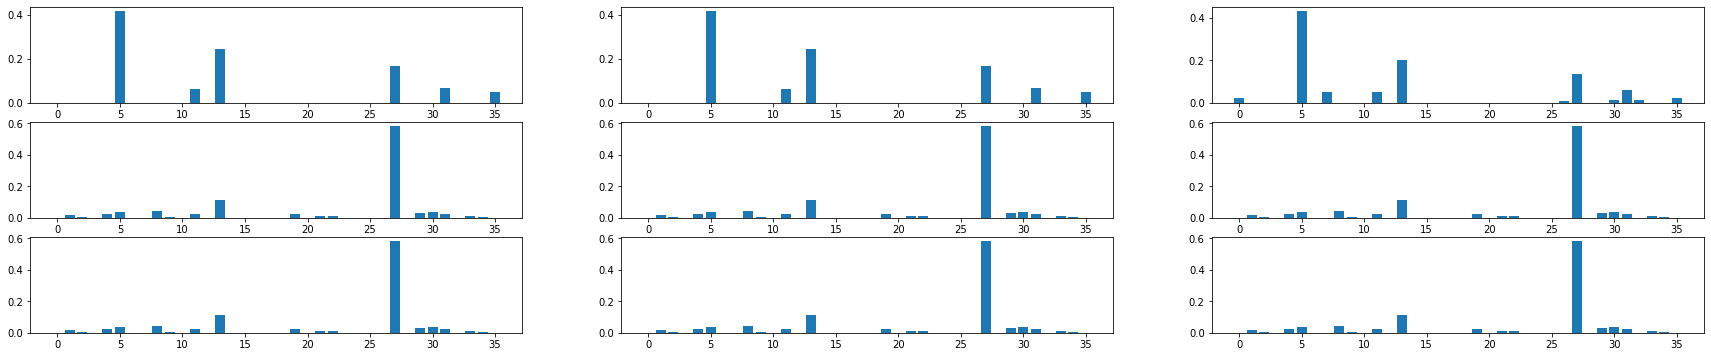

Phase 42
./tmp2/NYSE_phase42_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 80 / 100


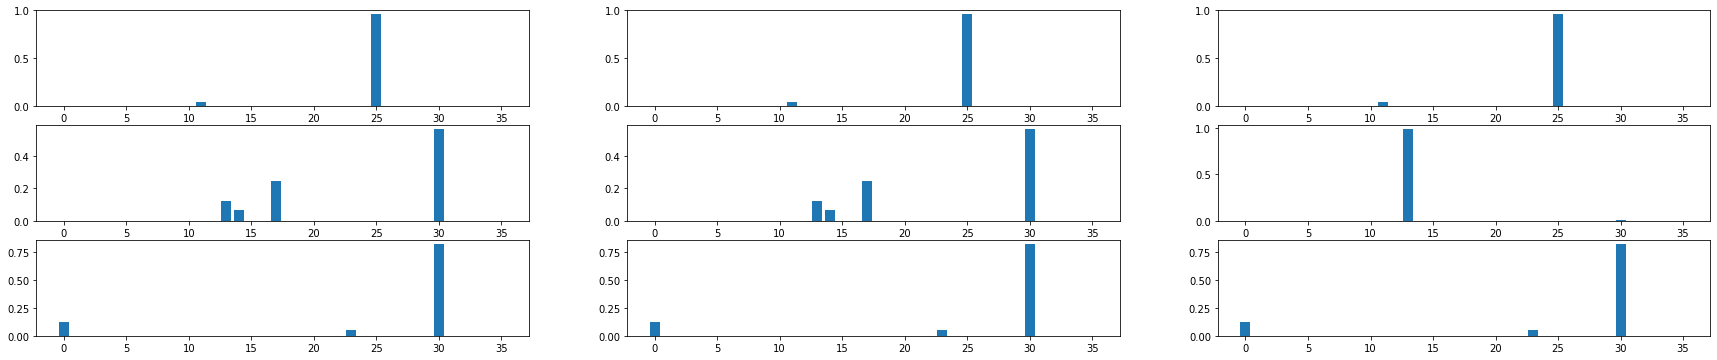

Phase 43
./tmp2/NYSE_phase43_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 79 / 100


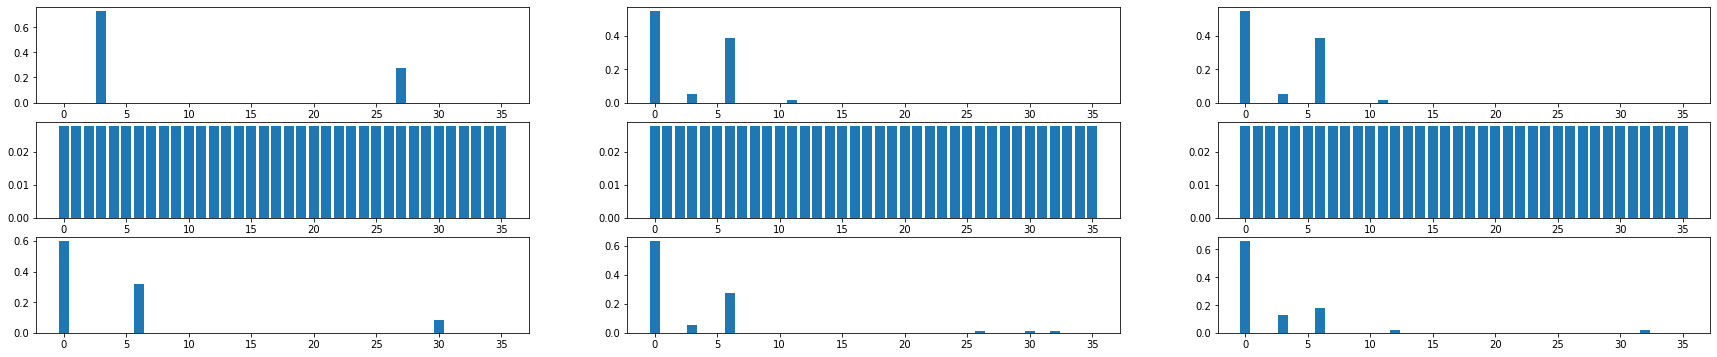

Phase 44
./tmp2/NYSE_phase44_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 75 / 100


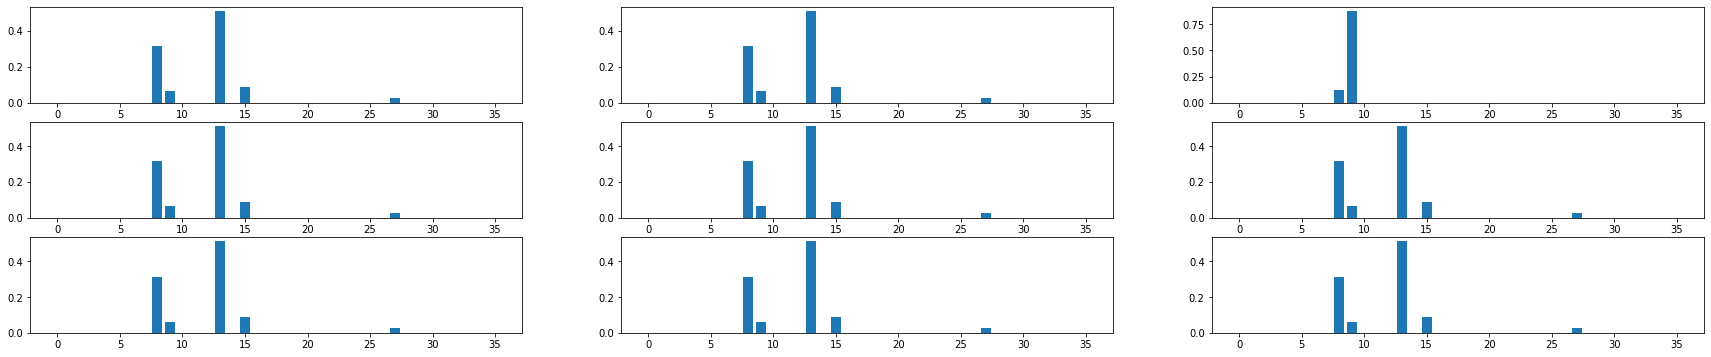

Phase 45
./tmp2/NYSE_phase45_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 62 / 100


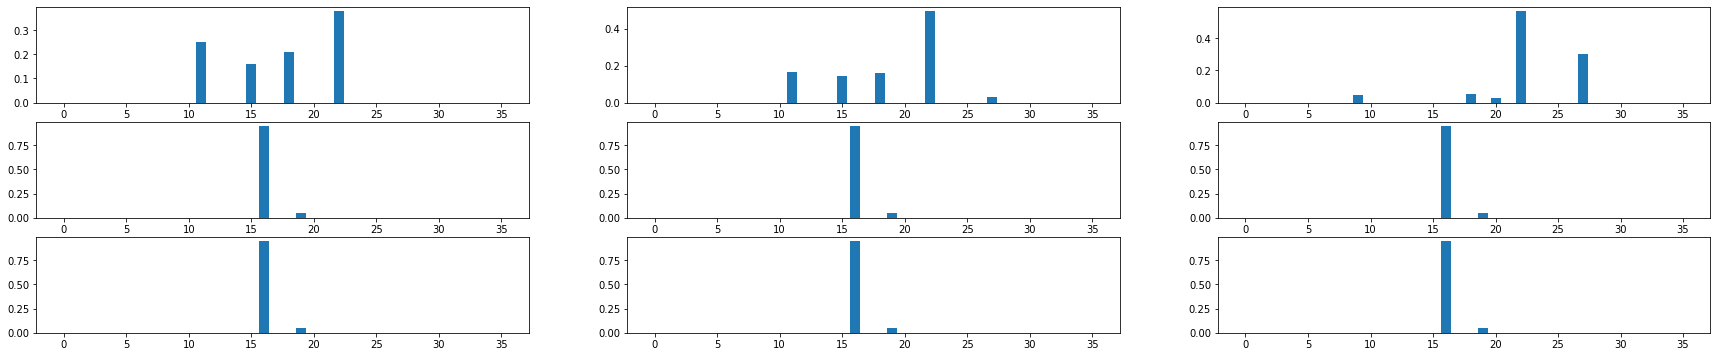

Phase 46
./tmp2/NYSE_phase46_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 66 / 100


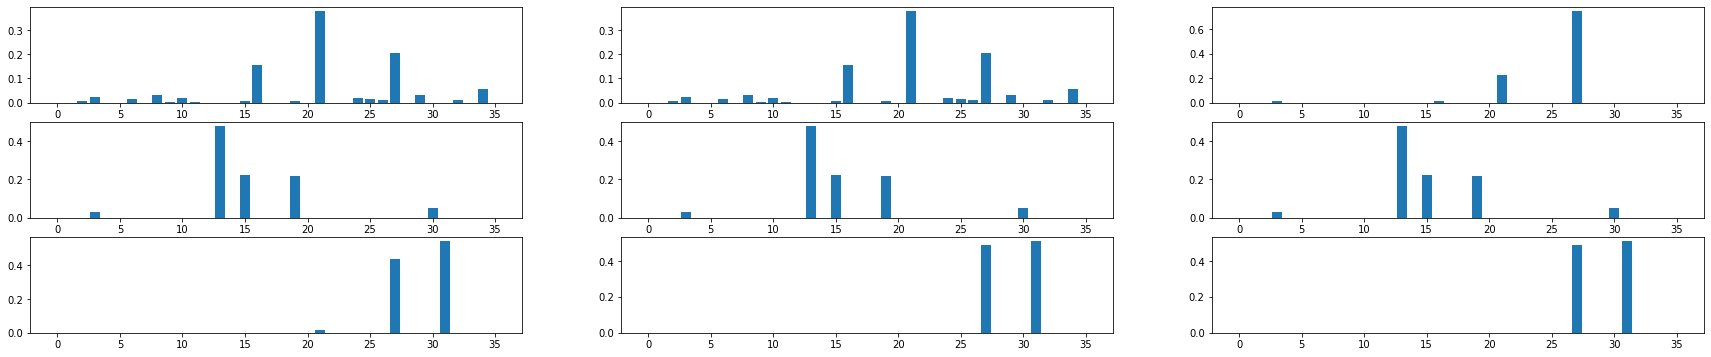

Phase 47
./tmp2/NYSE_phase47_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 57 / 100


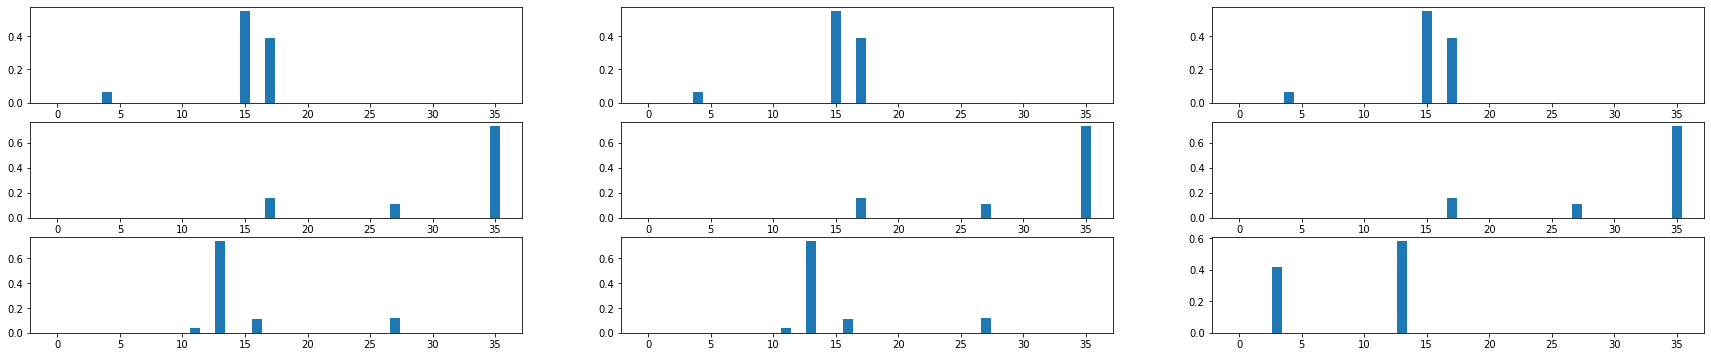

Phase 48
./tmp2/NYSE_phase48_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 64 / 100


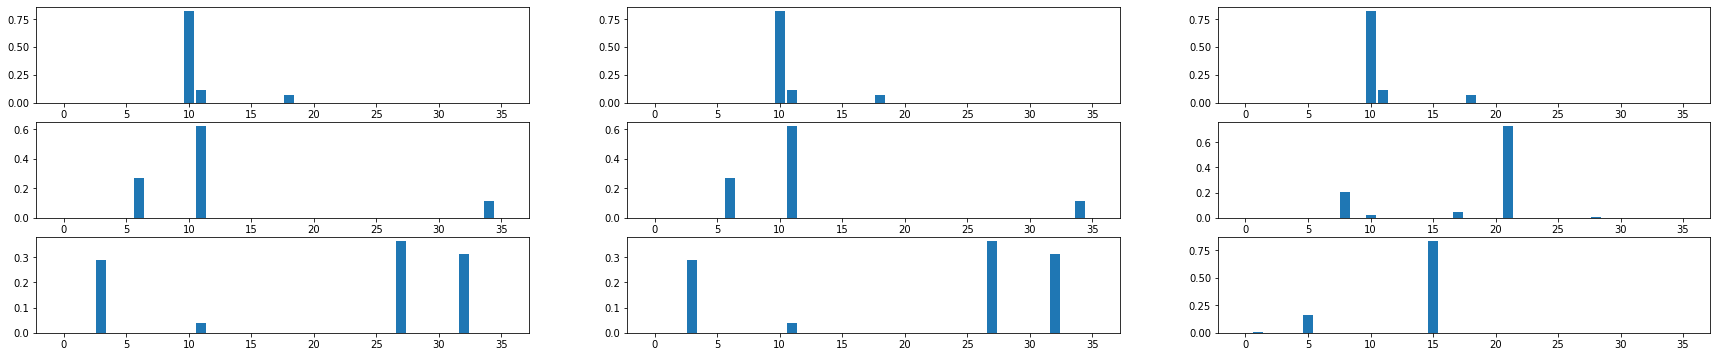

Phase 49
./tmp2/NYSE_phase49_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 80 / 100


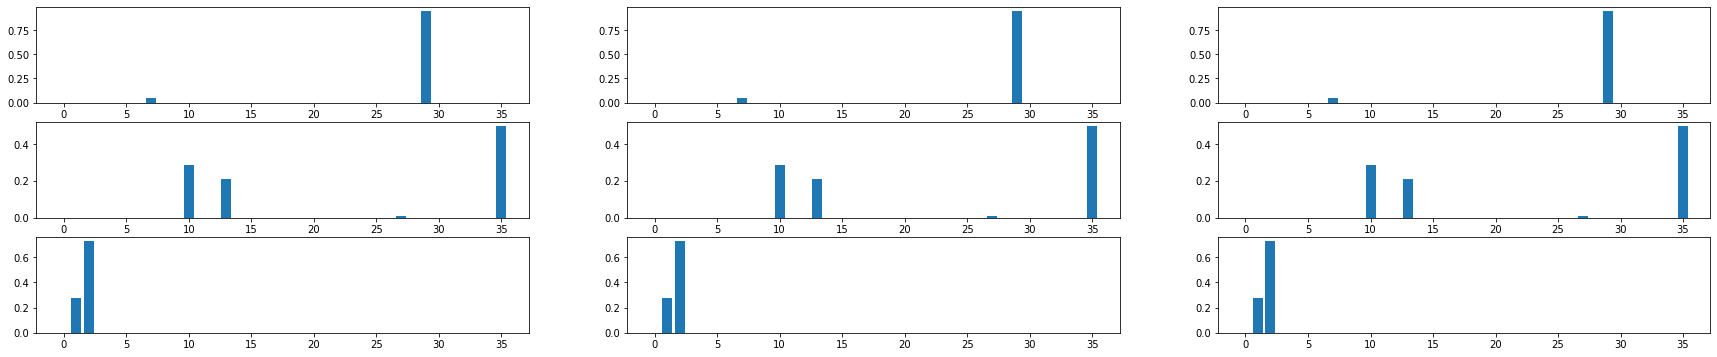

Phase 50
./tmp2/NYSE_phase50_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 78 / 100


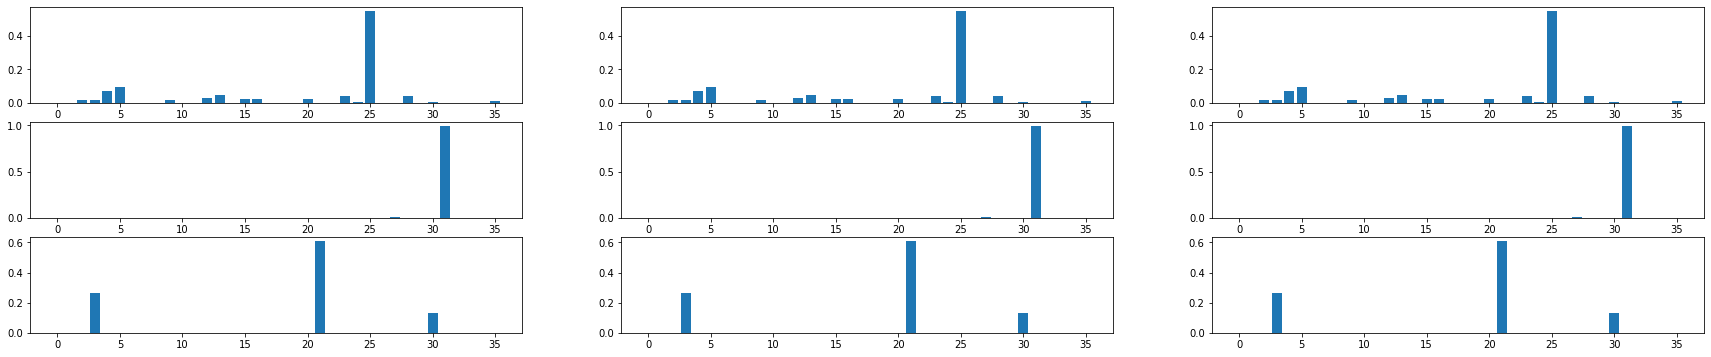

Phase 51
./tmp2/NYSE_phase51_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 64 / 100


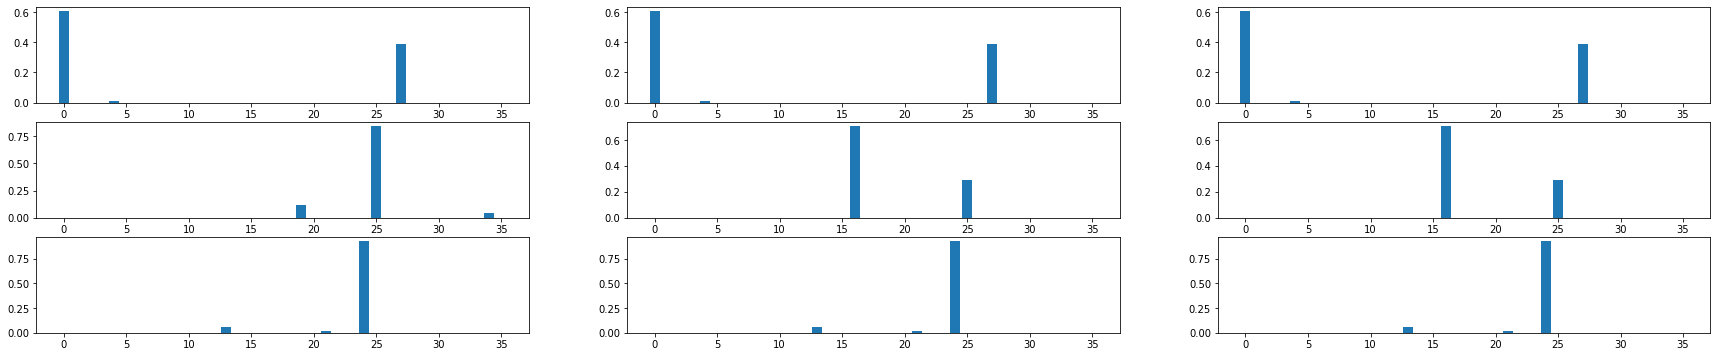

Phase 52
./tmp2/NYSE_phase52_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 78 / 100


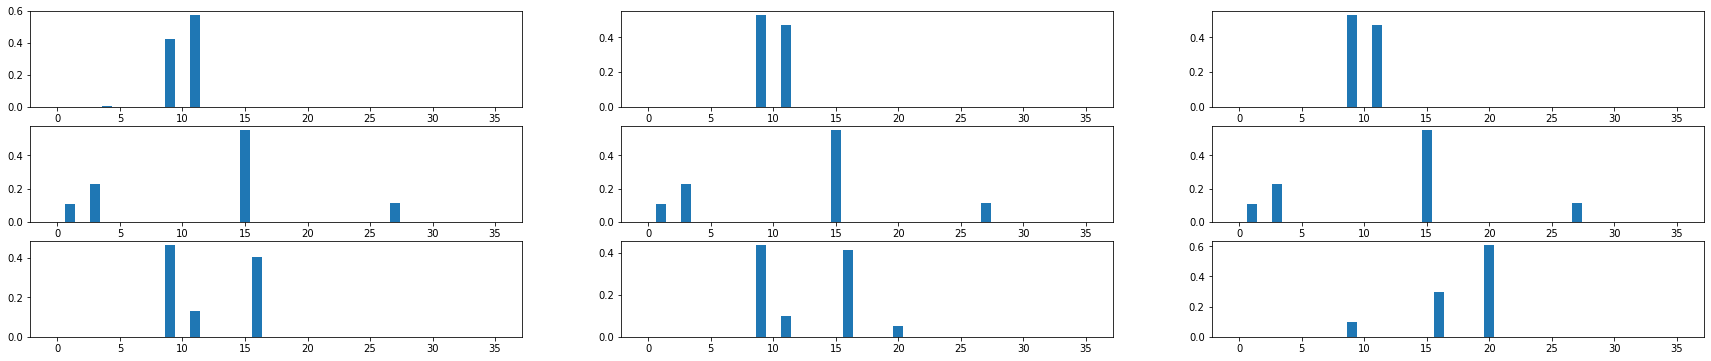

In [41]:
paras={'dataset':'NYSE', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'opt_gamma':0.0, 'passive_eps':1.02, 'passive_gamma':0.001,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=53)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P_passive
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.32
    Sharpe ratio: 1.69 ± 0.34
    Ulcer index: 7.30
    Information ratio (wrt UCRP): 1.49
    Appraisal ratio (wrt UCRP): 1.29 ± 0.22
    UCRP sharpe: 1.10 ± 0.28
    Beta / Alpha: 1.46 / 55.351%
    Annualized return: 95.13%
    Annualized volatility: 45.72%
    Longest drawdown: 247 days
    Max drawdown: 39.52%
    Winning days: 51.8%
    Annual turnover: 68.3
        
Total wealth: 1276875.3885036118


<Figure size 720x360 with 0 Axes>

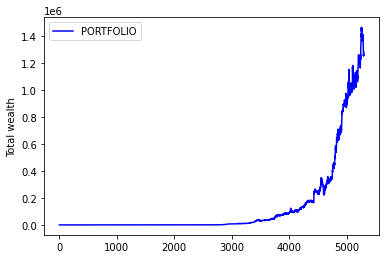

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.23
    Sharpe ratio: 1.32 ± 0.30
    Ulcer index: 4.66
    Information ratio (wrt UCRP): 1.09
    Appraisal ratio (wrt UCRP): 0.90 ± 0.22
    UCRP sharpe: 1.10 ± 0.28
    Beta / Alpha: 1.46 / 38.304%
    Annualized return: 64.87%
    Annualized volatility: 45.62%
    Longest drawdown: 278 days
    Max drawdown: 46.93%
    Winning days: 49.9%
    Annual turnover: 68.3
        
Total wealth: 36878.87120589225


<Figure size 720x360 with 0 Axes>

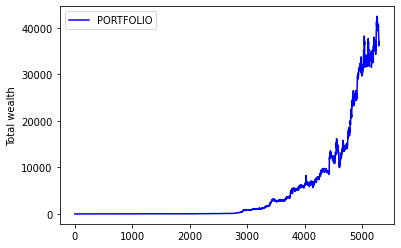

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.14
    Sharpe ratio: 0.95 ± 0.26
    Ulcer index: 2.60
    Information ratio (wrt UCRP): 0.68
    Appraisal ratio (wrt UCRP): 0.50 ± 0.22
    UCRP sharpe: 1.10 ± 0.28
    Beta / Alpha: 1.47 / 21.258%
    Annualized return: 39.22%
    Annualized volatility: 45.61%
    Longest drawdown: 438 days
    Max drawdown: 53.48%
    Winning days: 48.5%
    Annual turnover: 68.3
        
Total wealth: 1052.6463900427857


<Figure size 432x288 with 0 Axes>

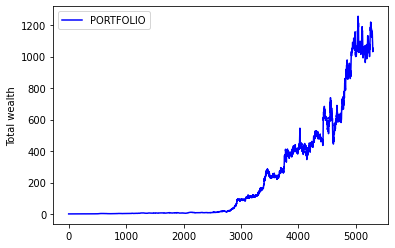

In [42]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

In [28]:
strategy_lst = ['G4P(predY0, std_varY0, sample_Y0, cov, paras["gamma"])']

Phase 0
./tmp2/NYSE_phase00_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


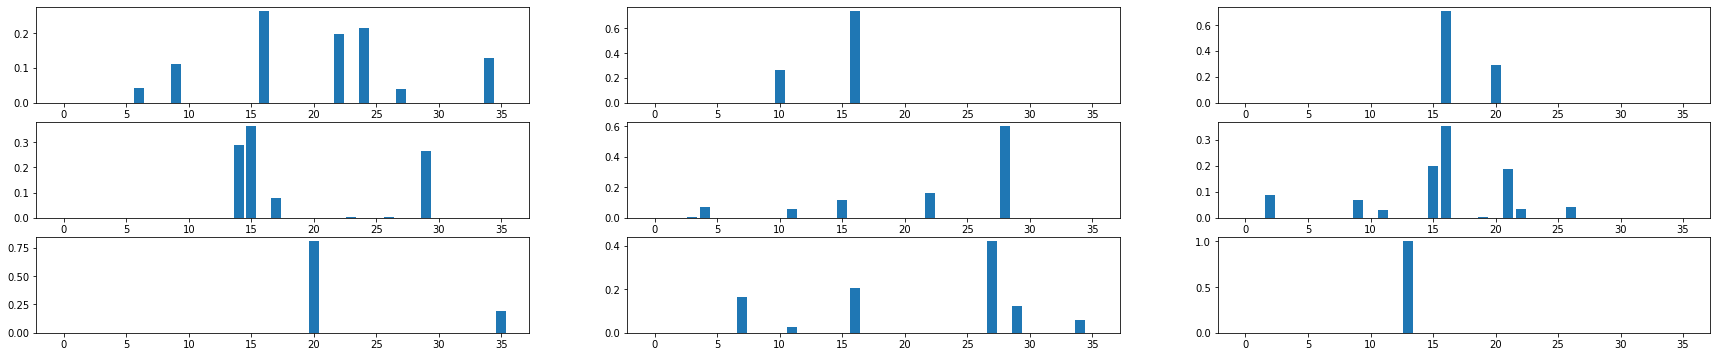

Phase 1
./tmp2/NYSE_phase01_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


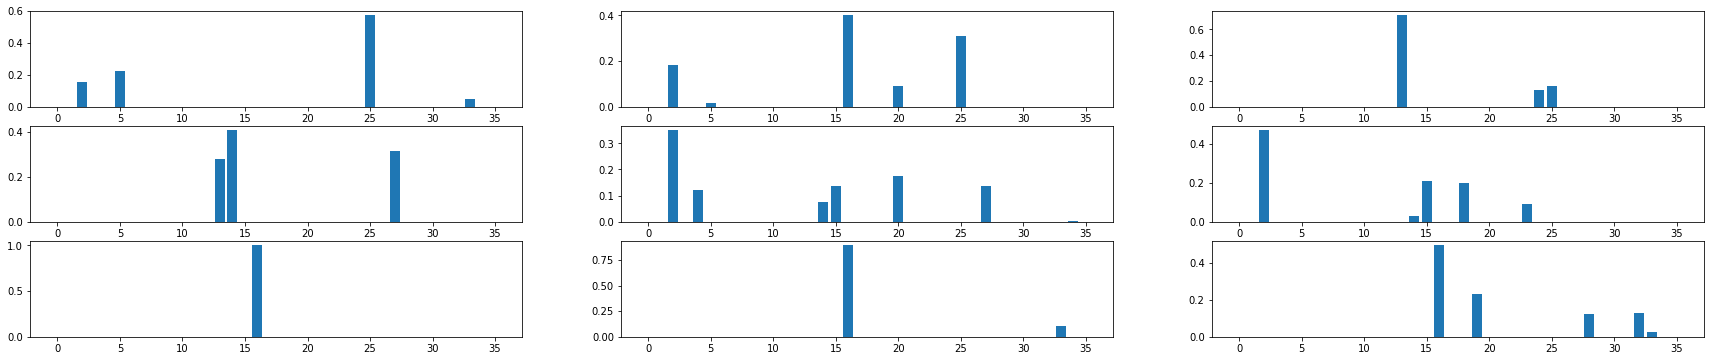

Phase 2
./tmp2/NYSE_phase02_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


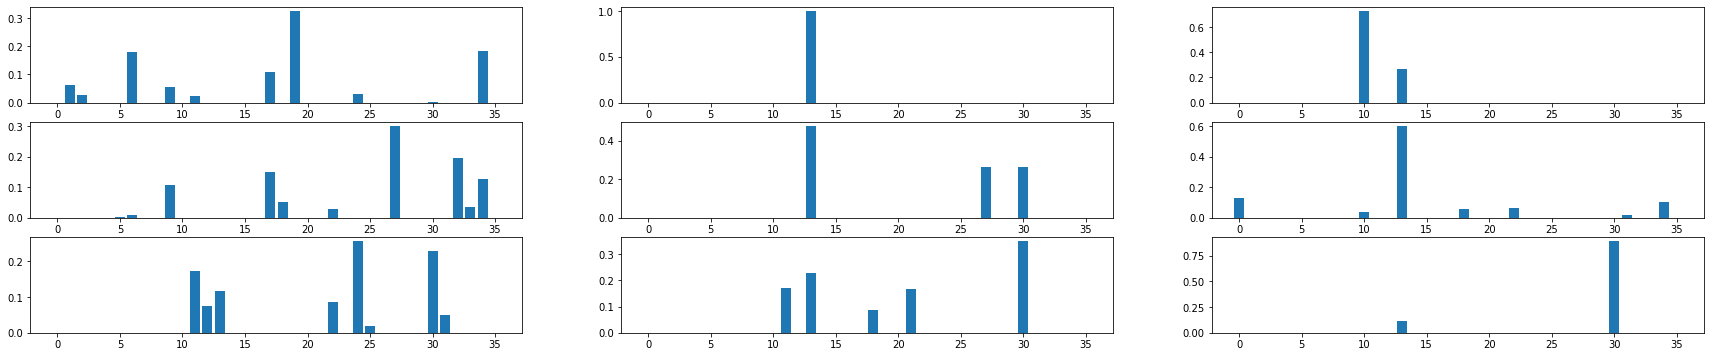

Phase 3
./tmp2/NYSE_phase03_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


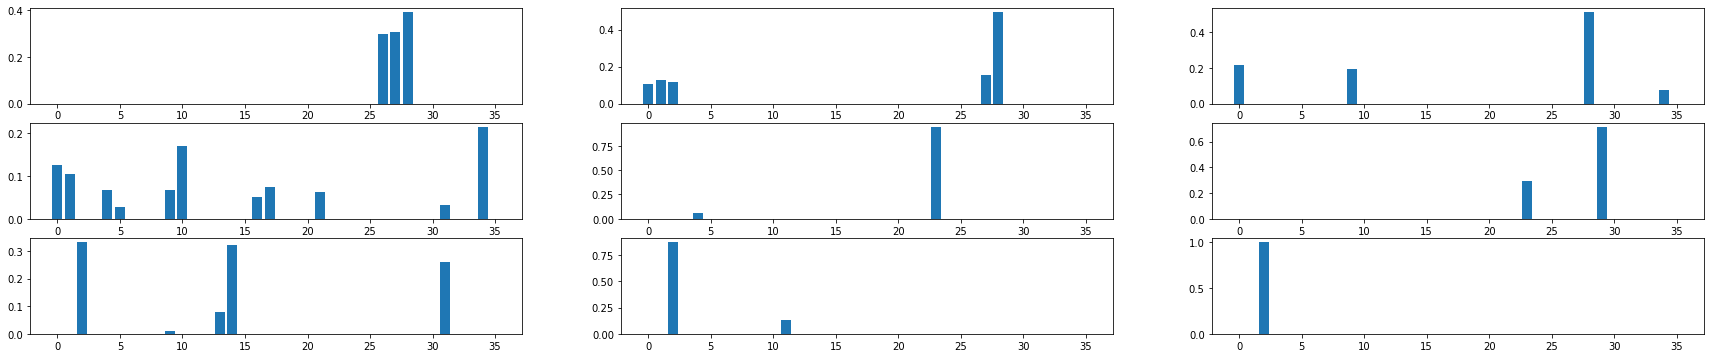

Phase 4
./tmp2/NYSE_phase04_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


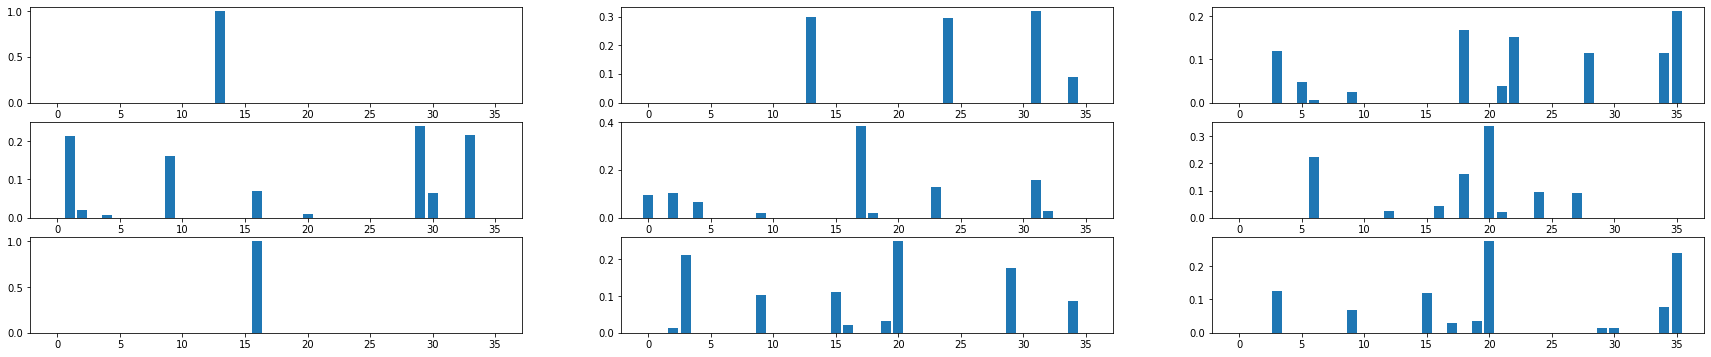

Phase 5
./tmp2/NYSE_phase05_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


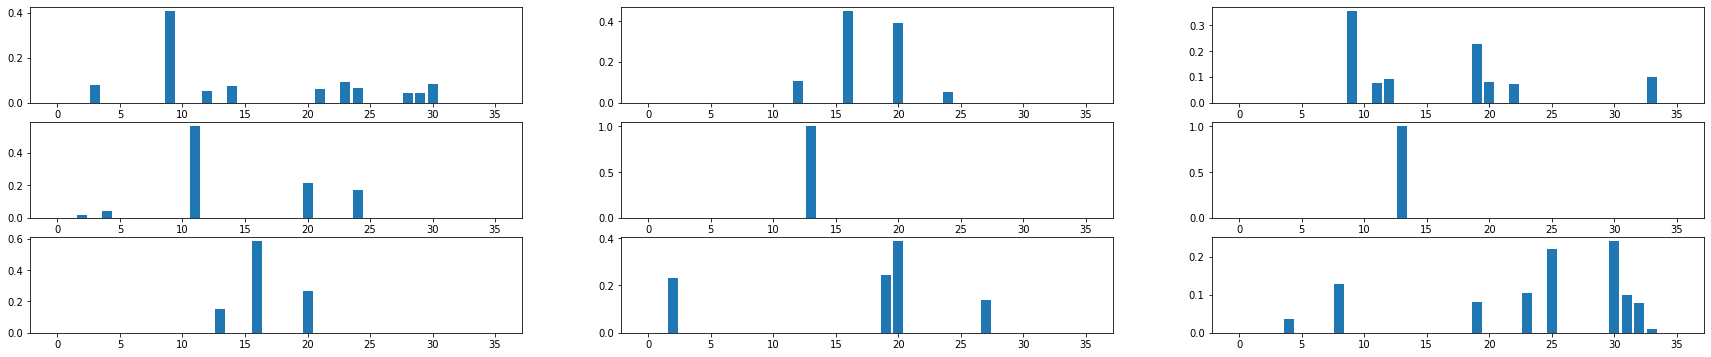

Phase 6
./tmp2/NYSE_phase06_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


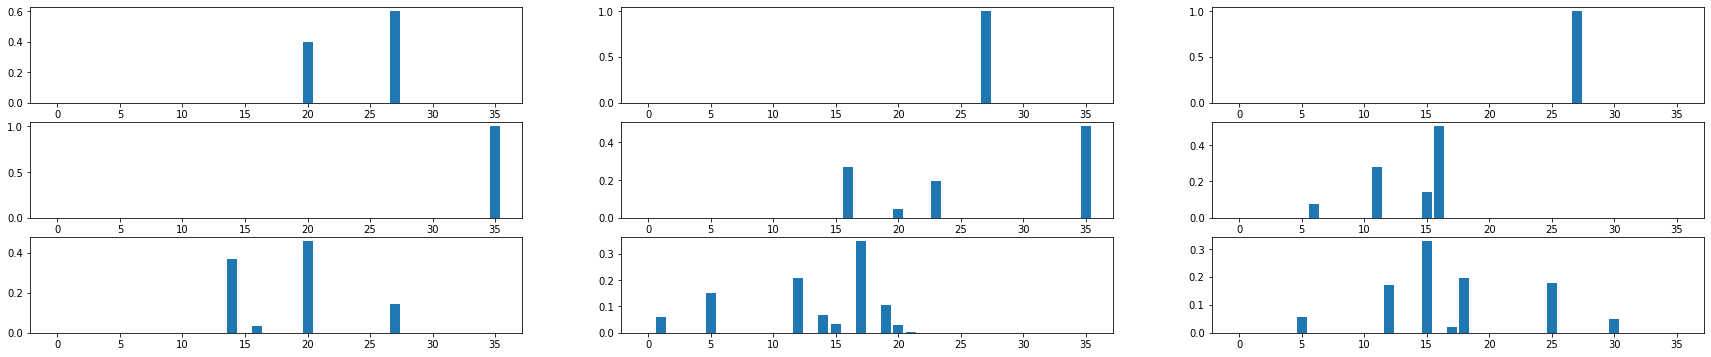

Phase 7
./tmp2/NYSE_phase07_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


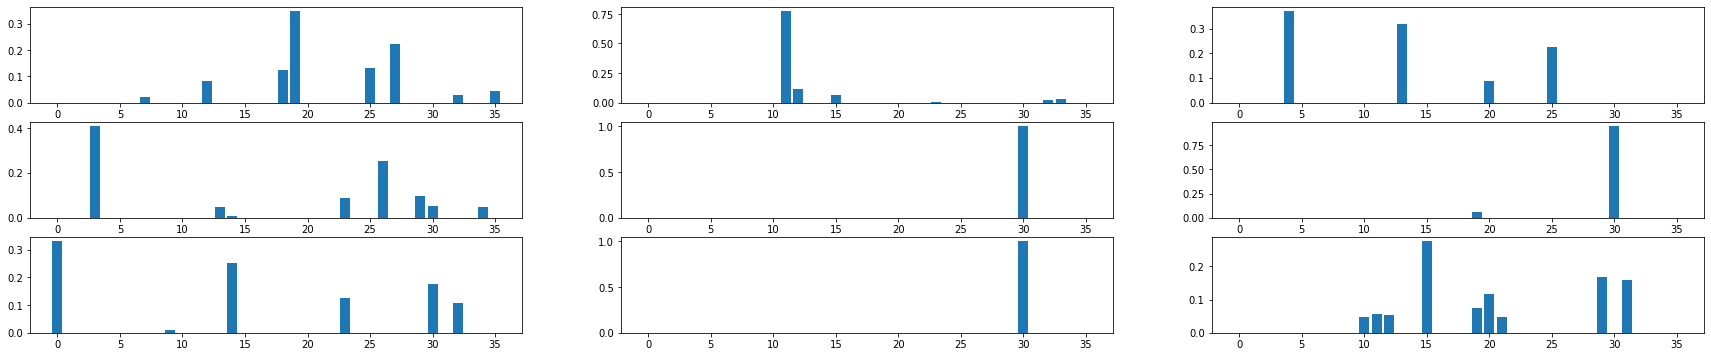

Phase 8
./tmp2/NYSE_phase08_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


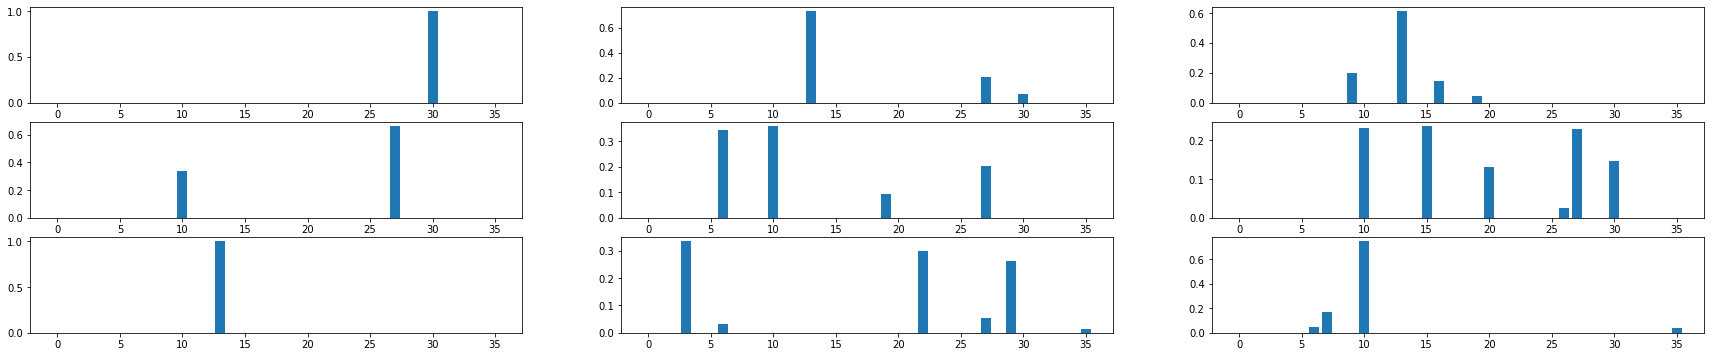

Phase 9
./tmp2/NYSE_phase09_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


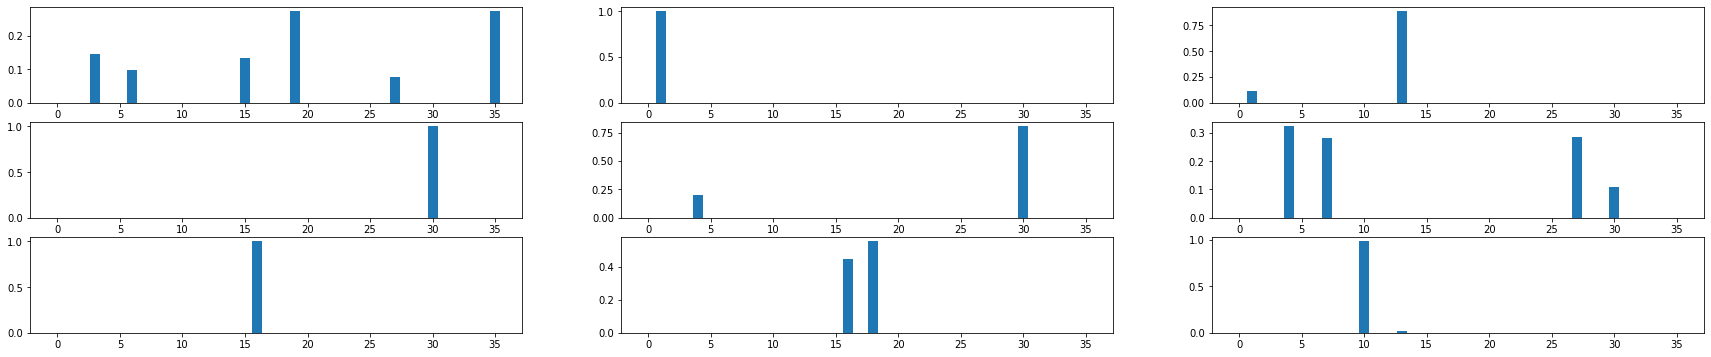

Phase 10
./tmp2/NYSE_phase10_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


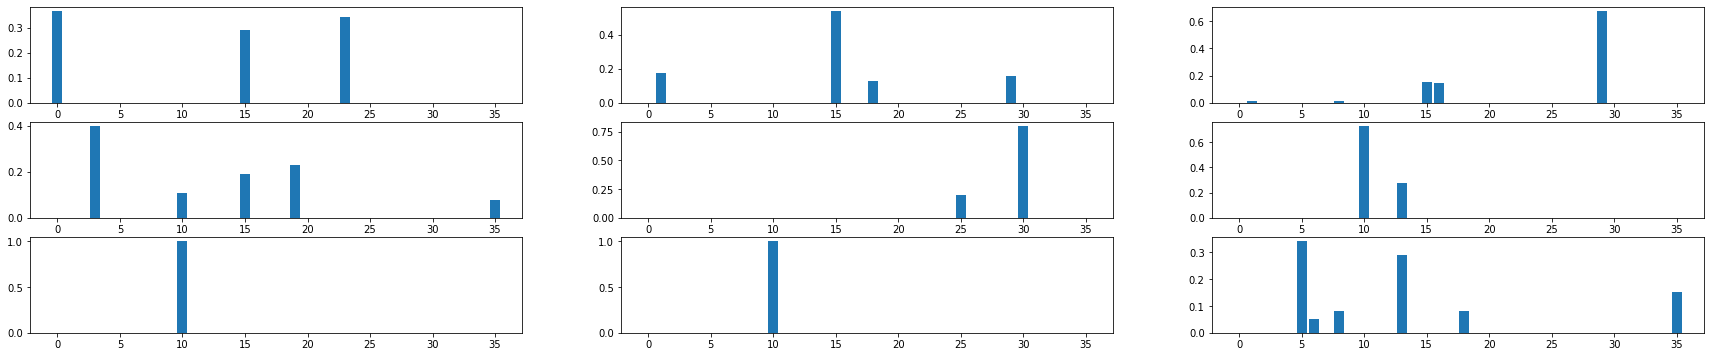

Phase 11
./tmp2/NYSE_phase11_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


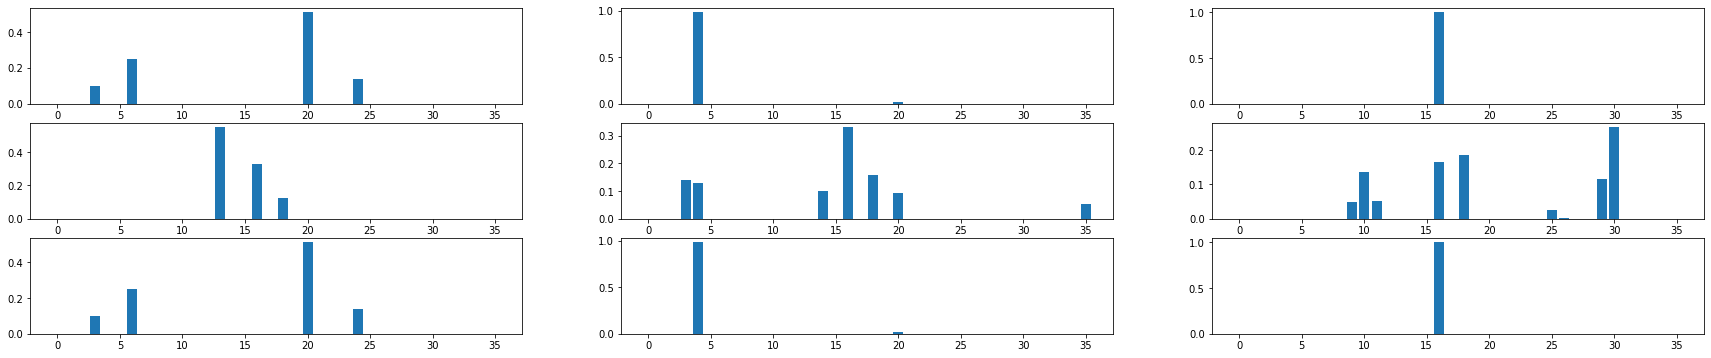

Phase 12
./tmp2/NYSE_phase12_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


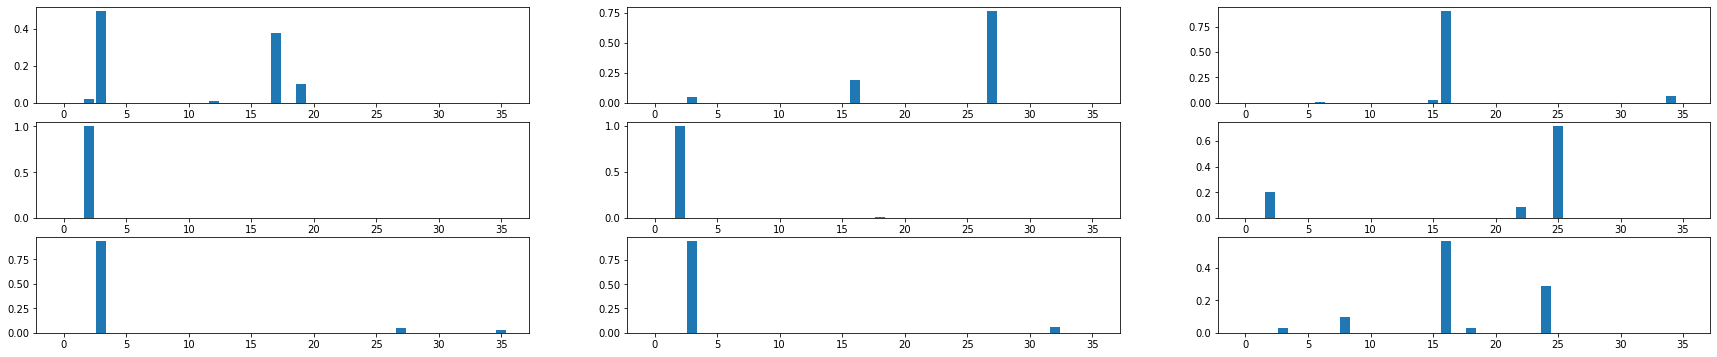

Phase 13
./tmp2/NYSE_phase13_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


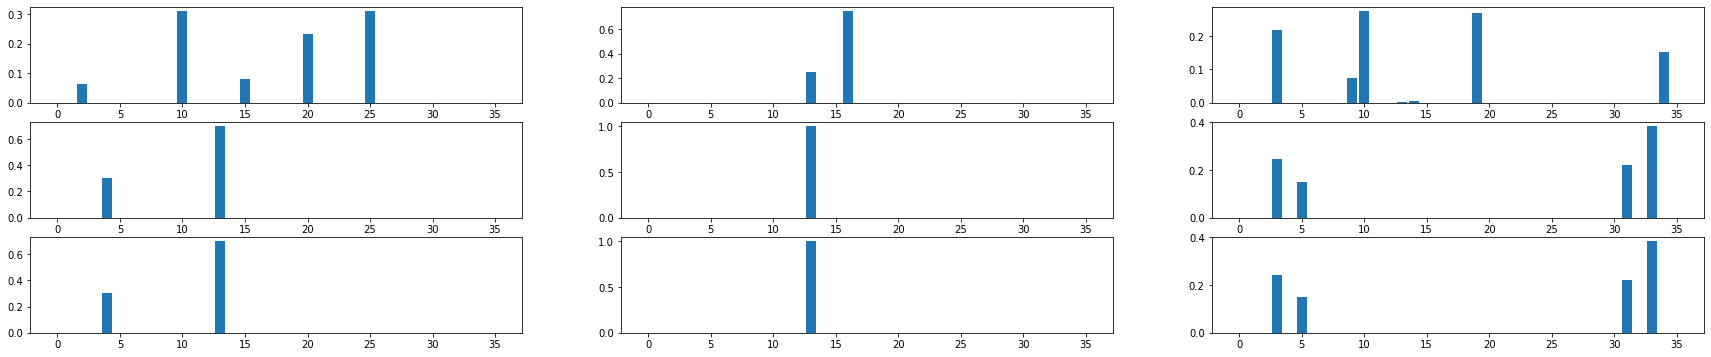

Phase 14
./tmp2/NYSE_phase14_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


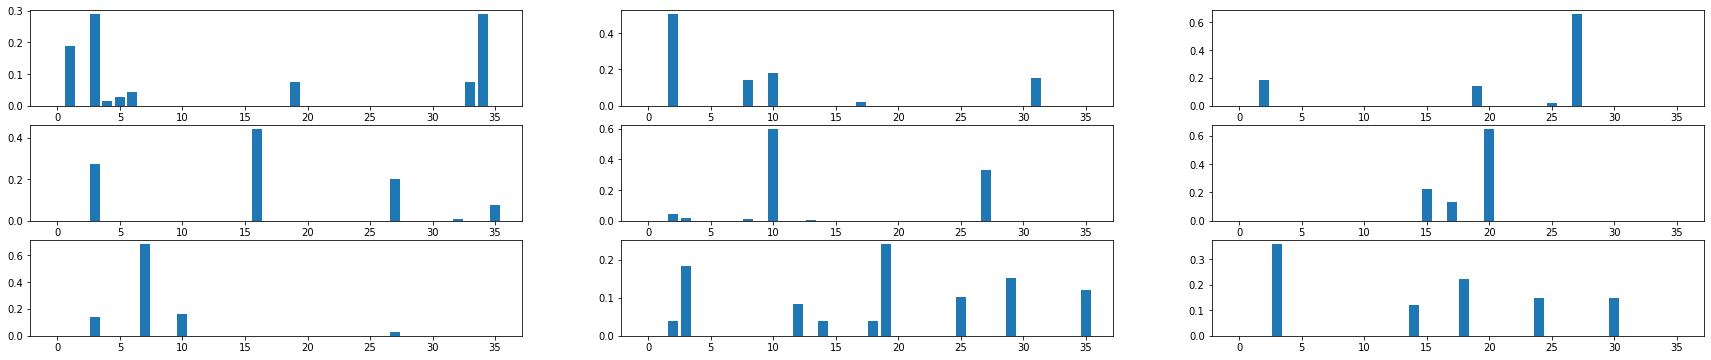

Phase 15
./tmp2/NYSE_phase15_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


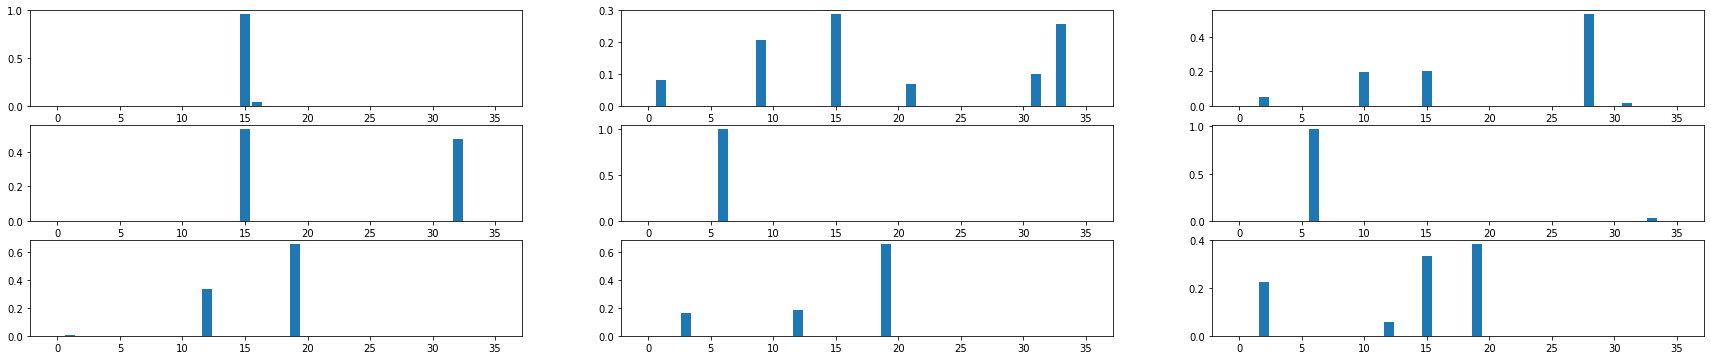

Phase 16
./tmp2/NYSE_phase16_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


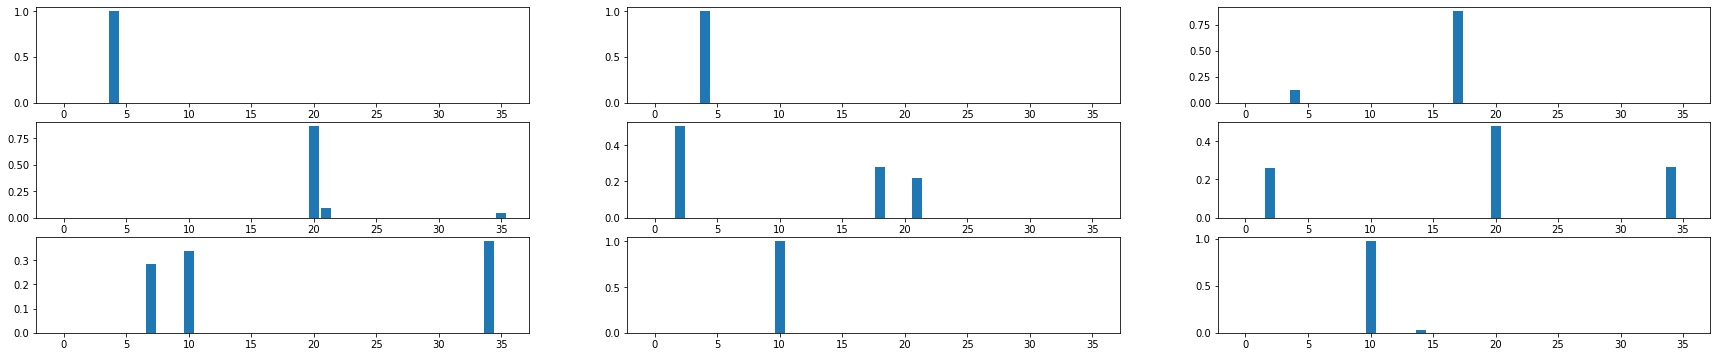

Phase 17
./tmp2/NYSE_phase17_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


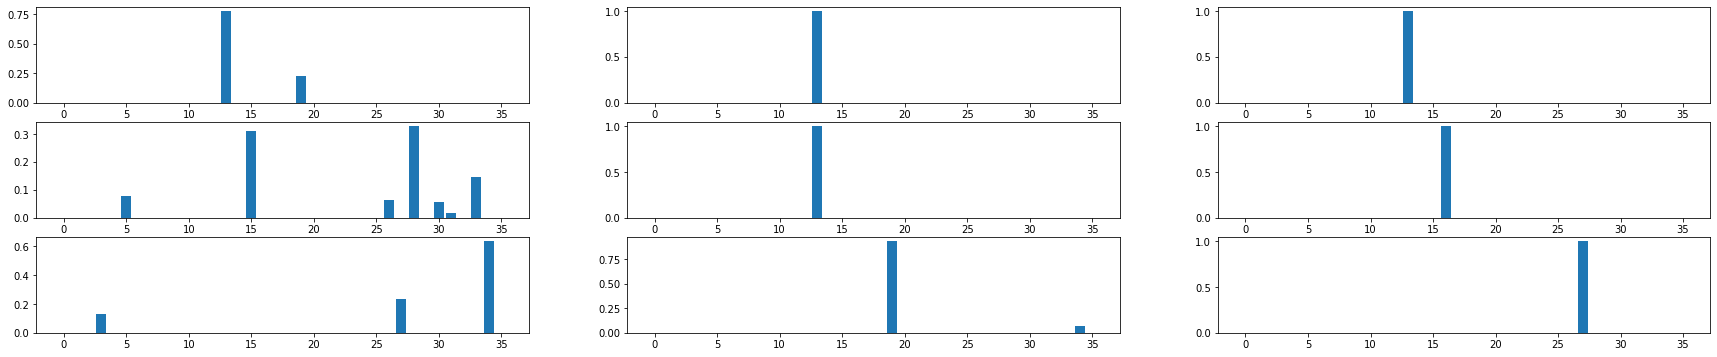

Phase 18
./tmp2/NYSE_phase18_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


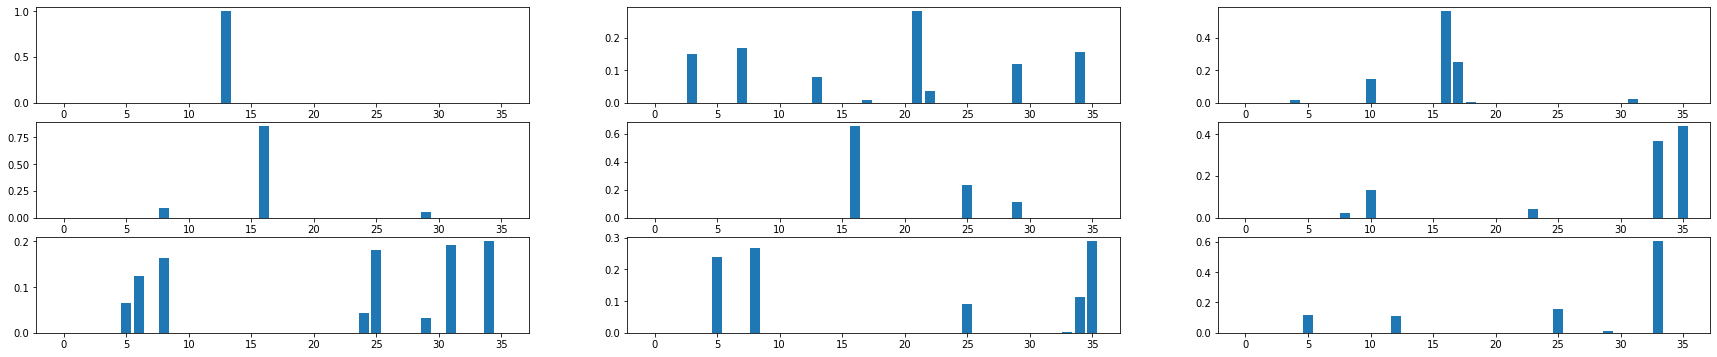

Phase 19
./tmp2/NYSE_phase19_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


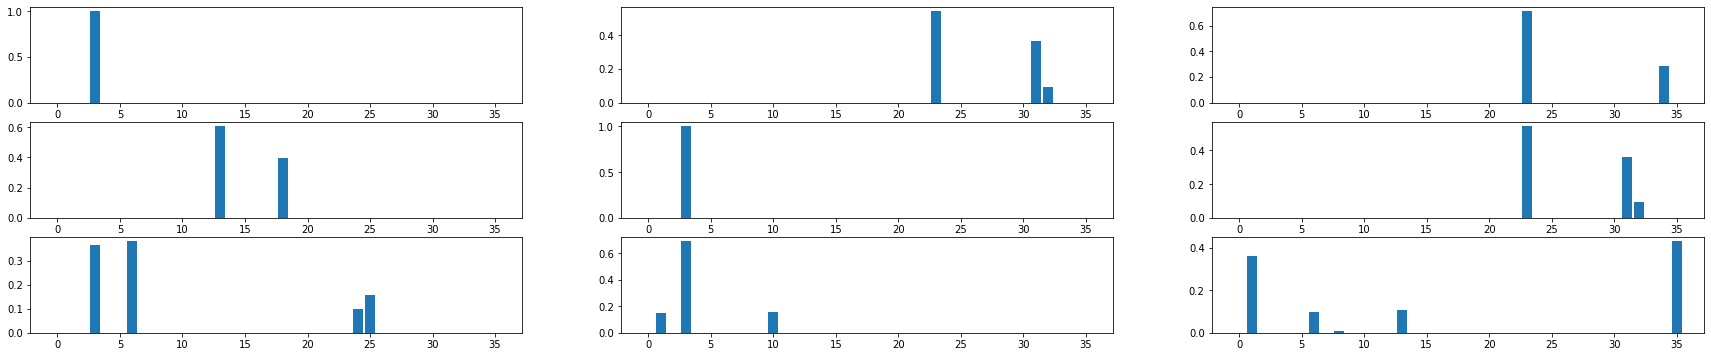

Phase 20
./tmp2/NYSE_phase20_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


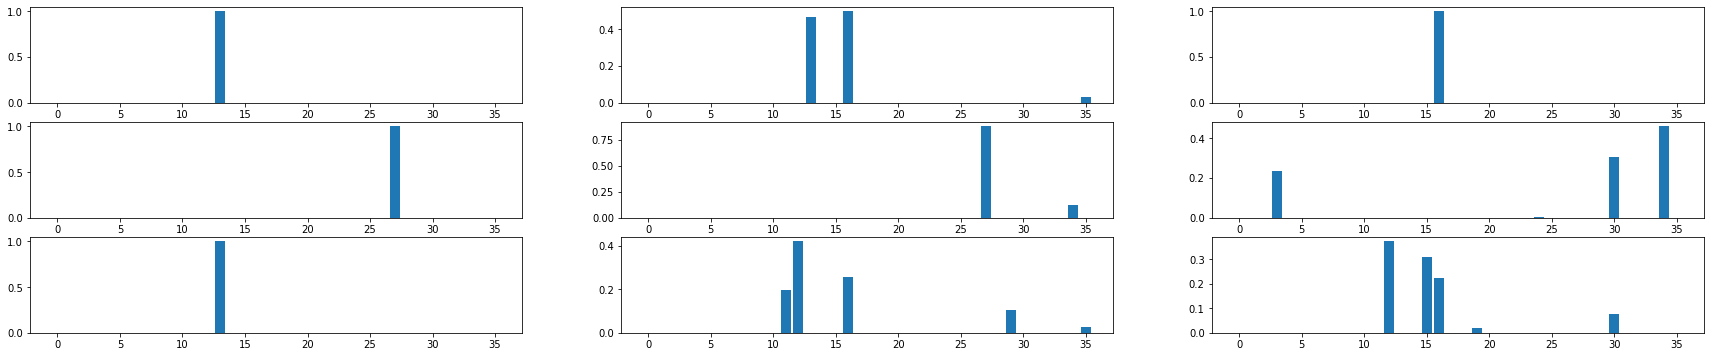

Phase 21
./tmp2/NYSE_phase21_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


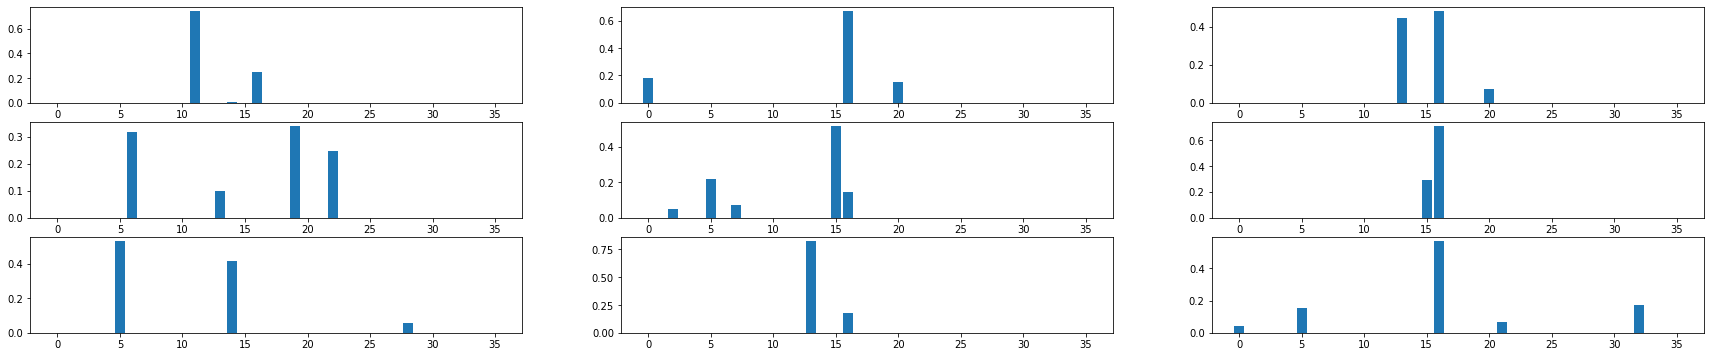

Phase 22
./tmp2/NYSE_phase22_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


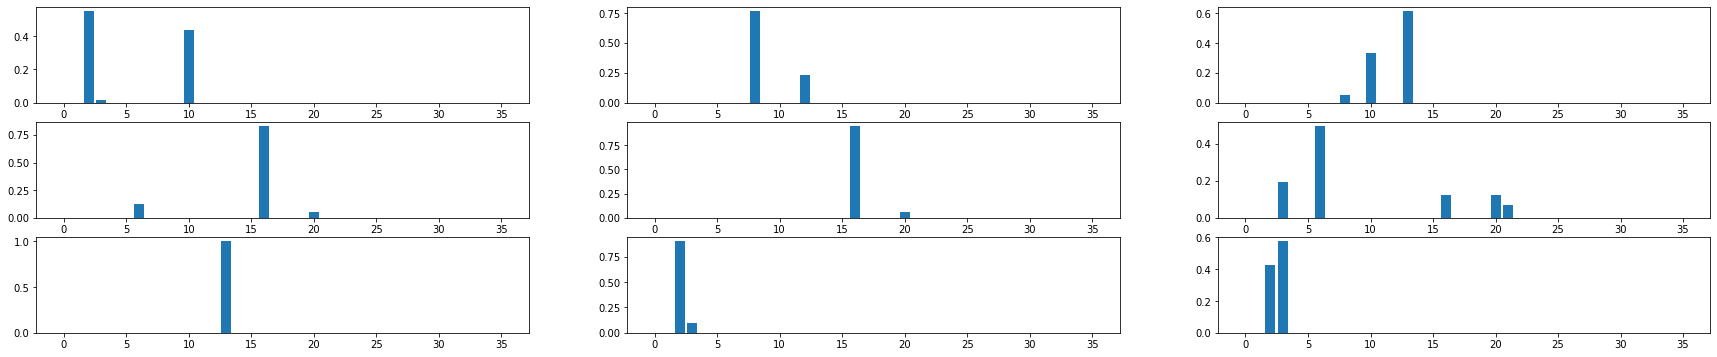

Phase 23
./tmp2/NYSE_phase23_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


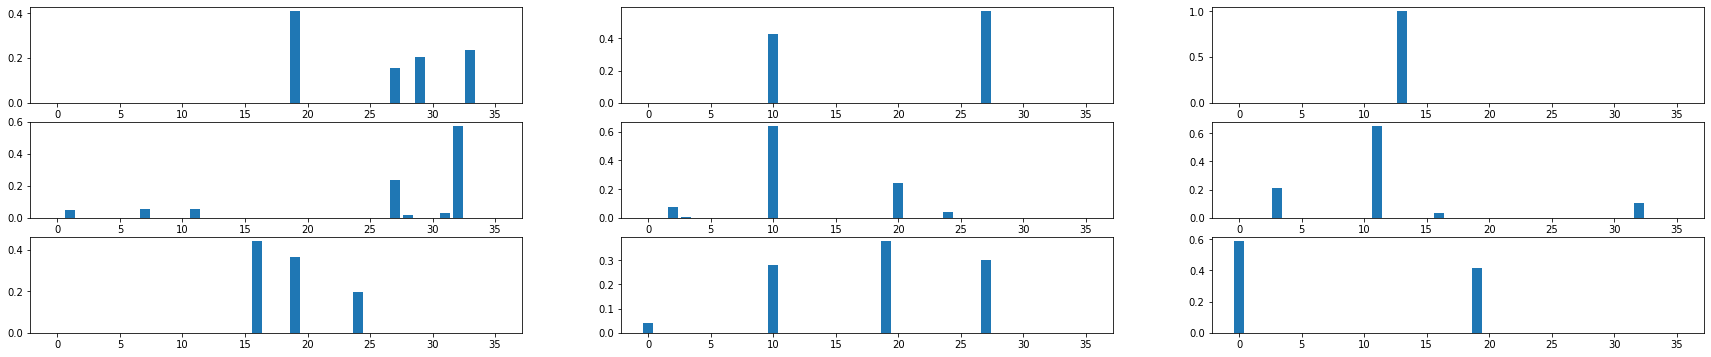

Phase 24
./tmp2/NYSE_phase24_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


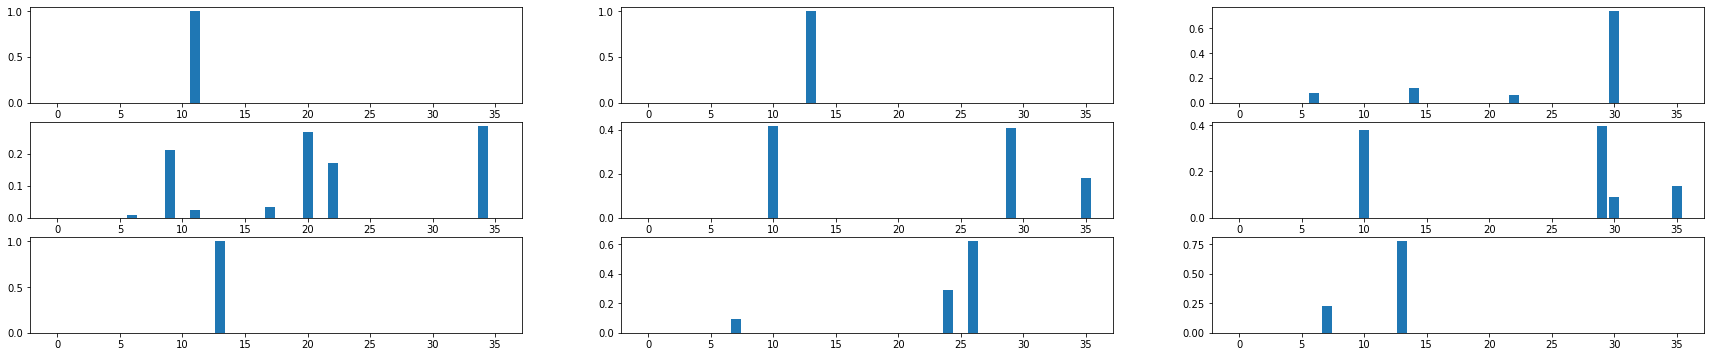

Phase 25
./tmp2/NYSE_phase25_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


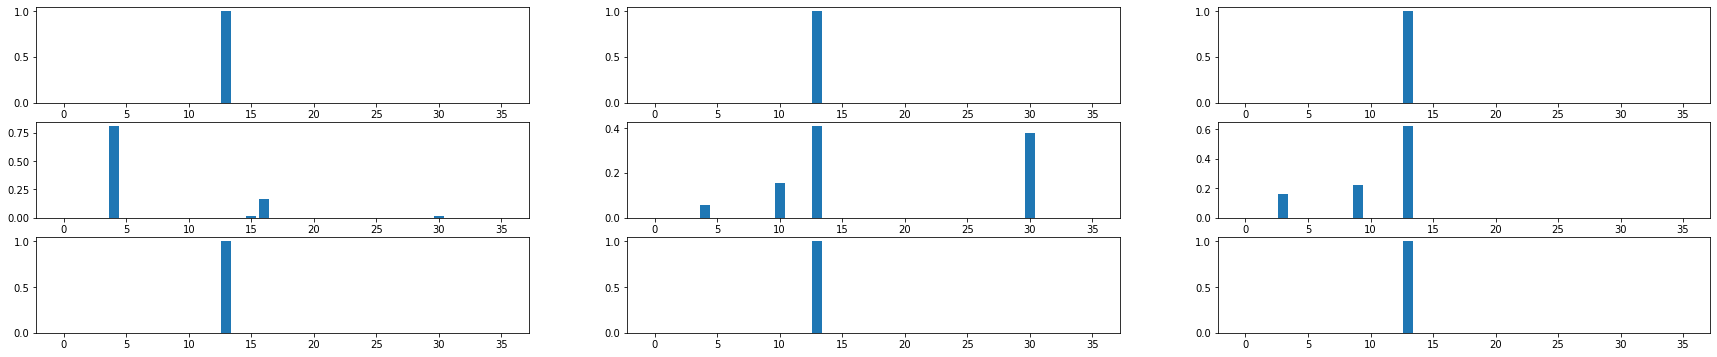

Phase 26
./tmp2/NYSE_phase26_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


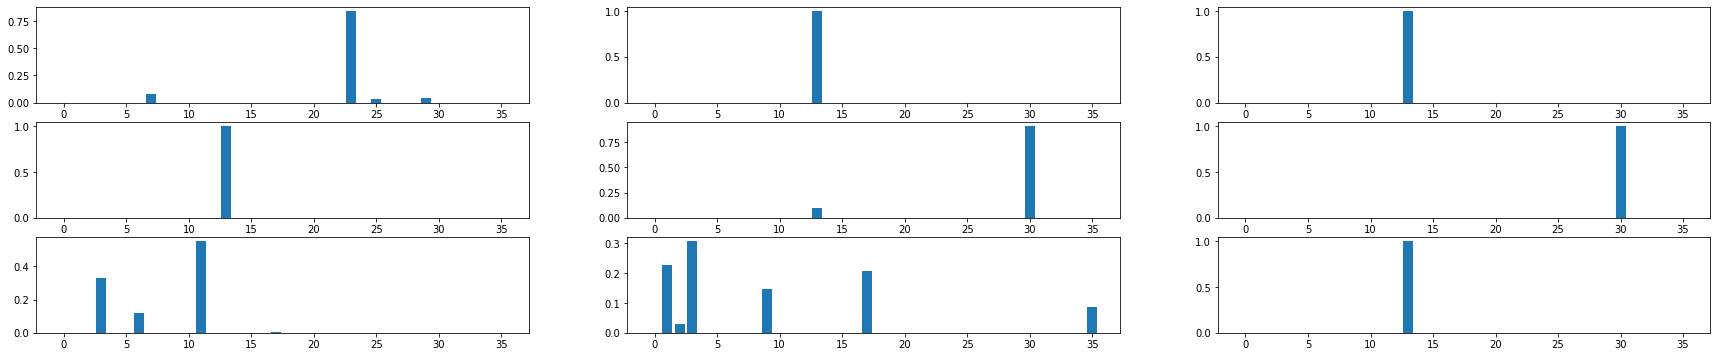

Phase 27
./tmp2/NYSE_phase27_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


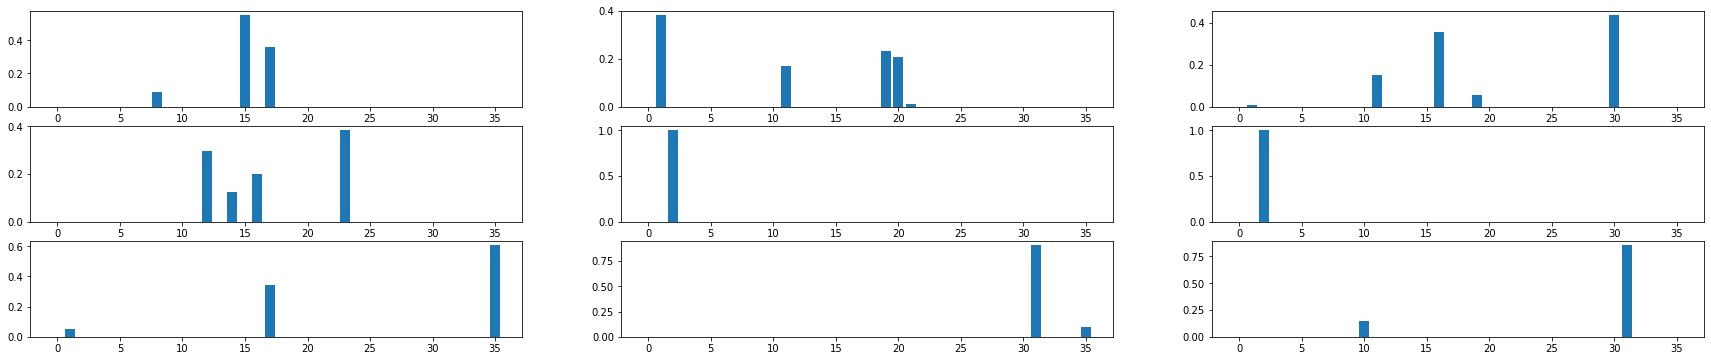

Phase 28
./tmp2/NYSE_phase28_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


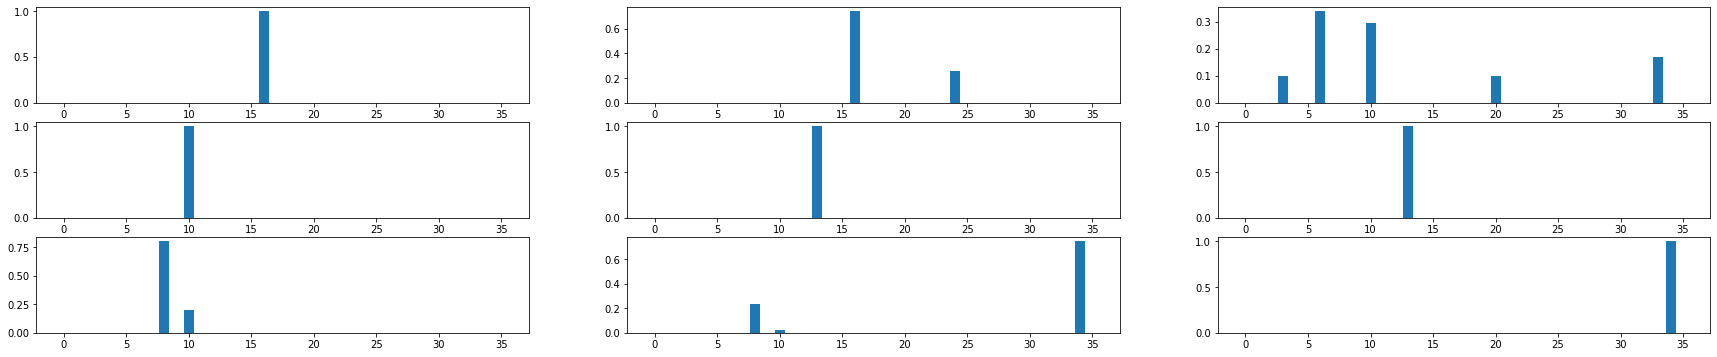

Phase 29
./tmp2/NYSE_phase29_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


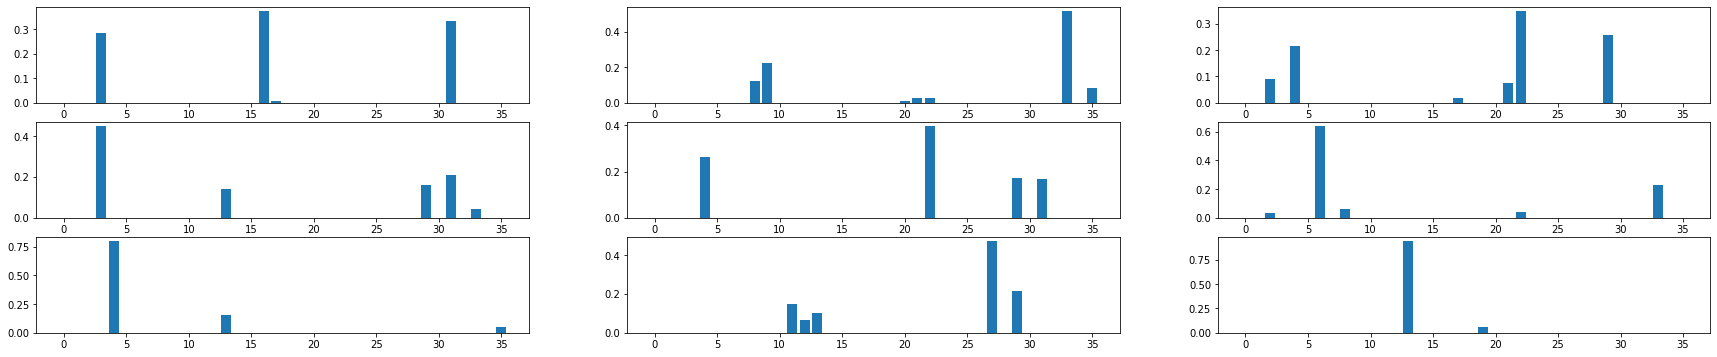

Phase 30
./tmp2/NYSE_phase30_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


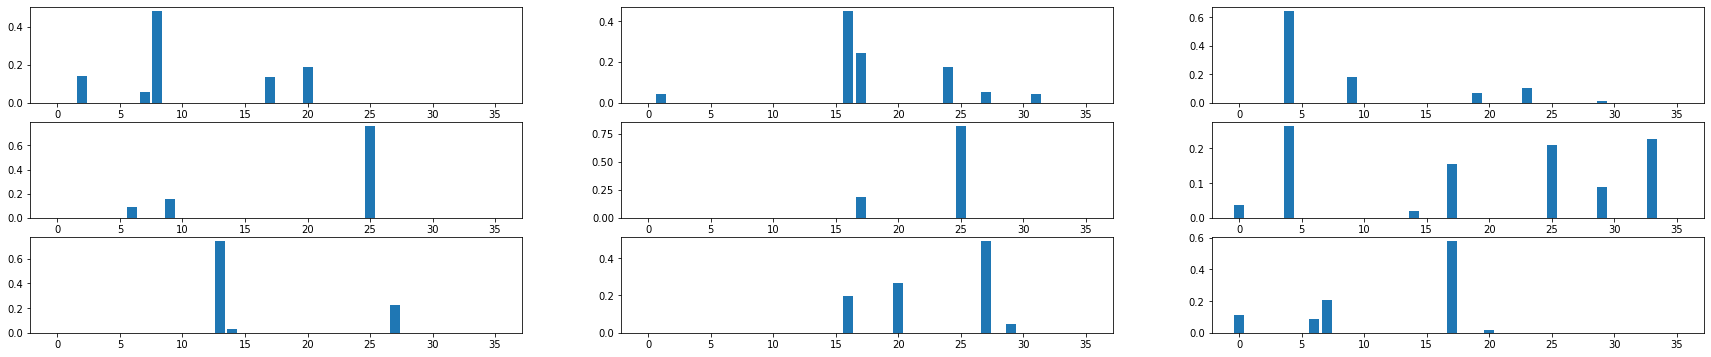

Phase 31
./tmp2/NYSE_phase31_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


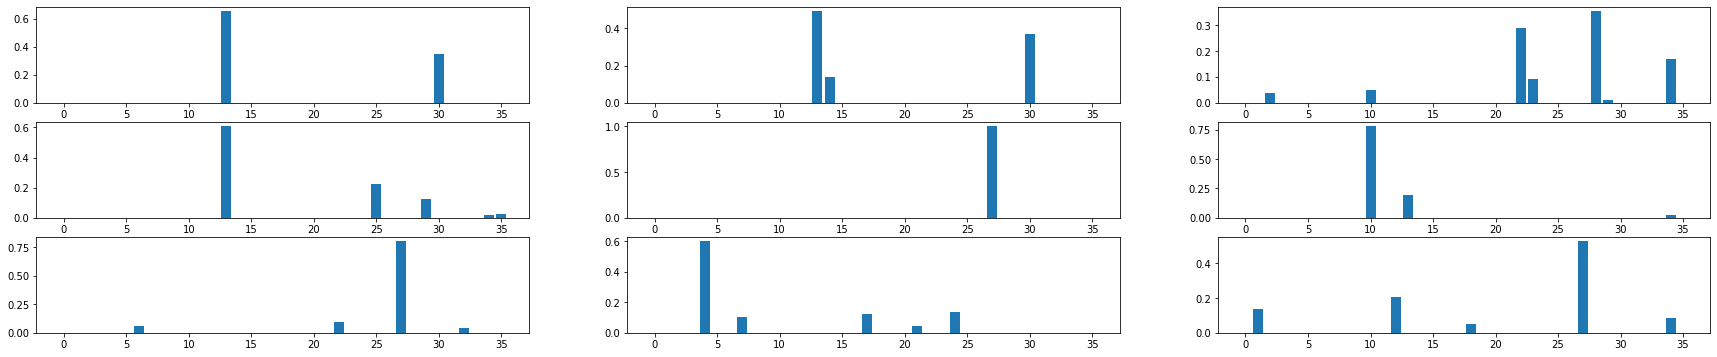

Phase 32
./tmp2/NYSE_phase32_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


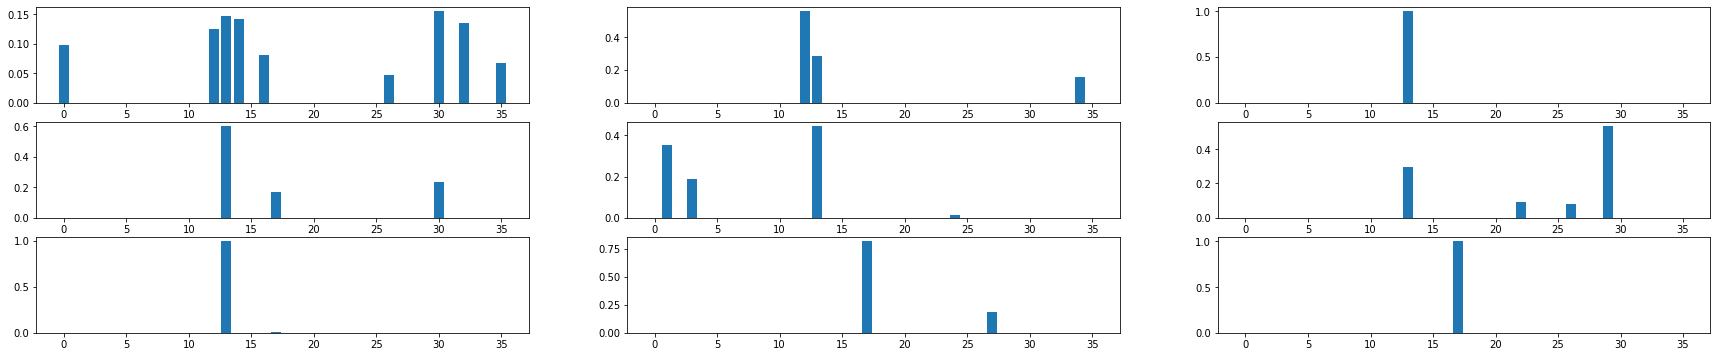

Phase 33
./tmp2/NYSE_phase33_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


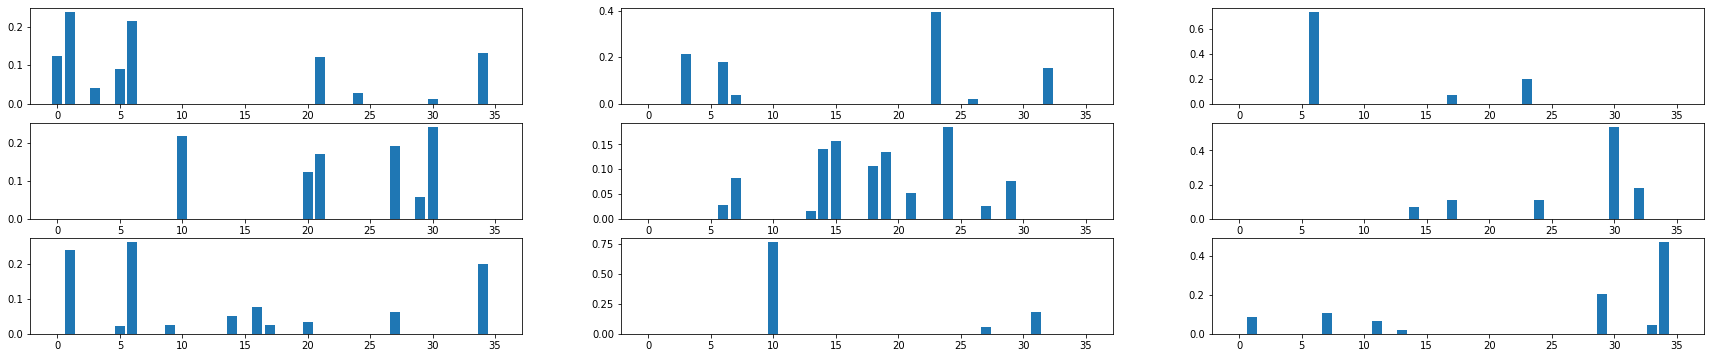

Phase 34
./tmp2/NYSE_phase34_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


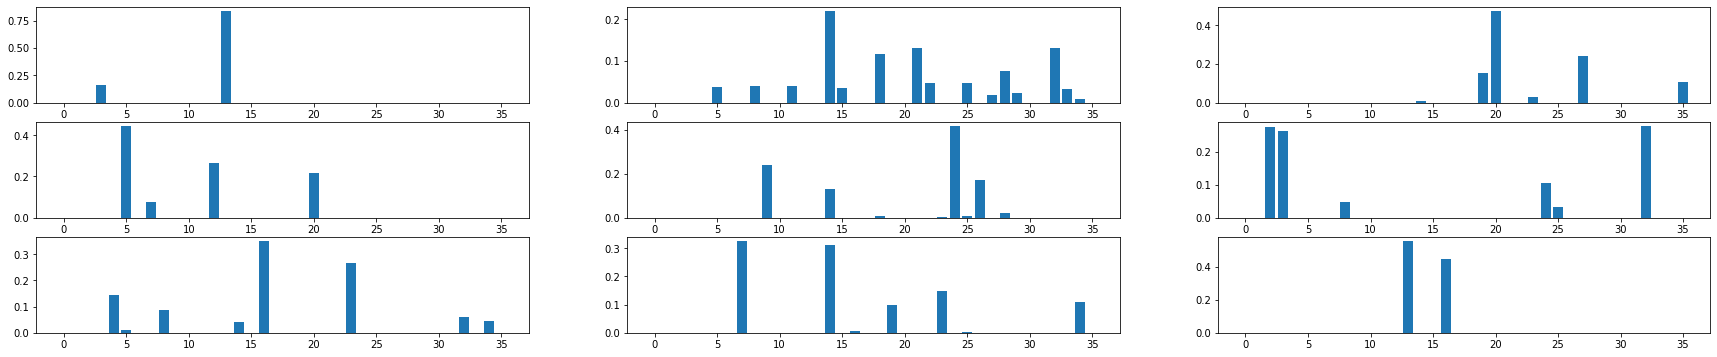

Phase 35
./tmp2/NYSE_phase35_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


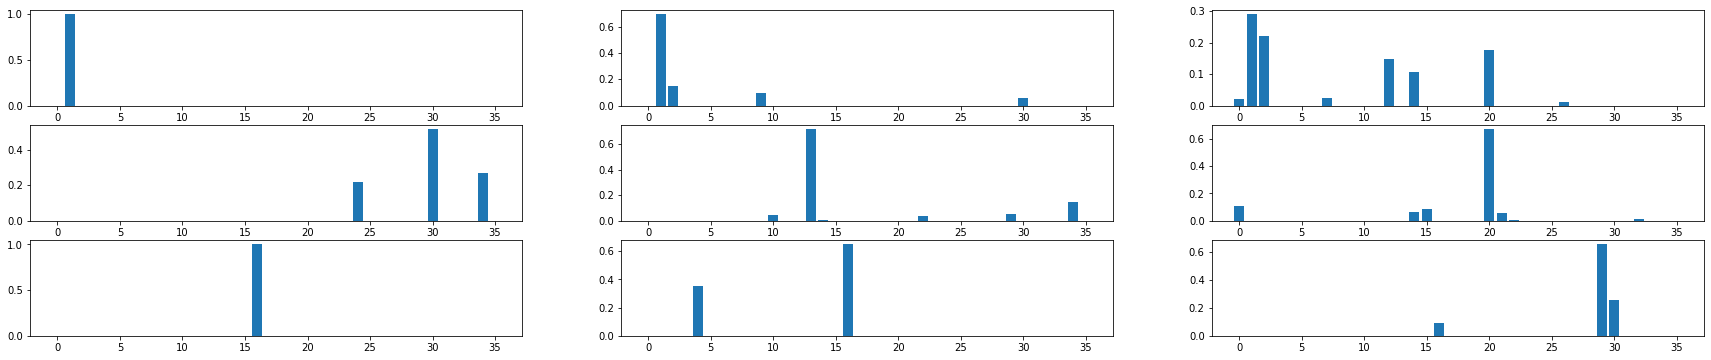

Phase 36
./tmp2/NYSE_phase36_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


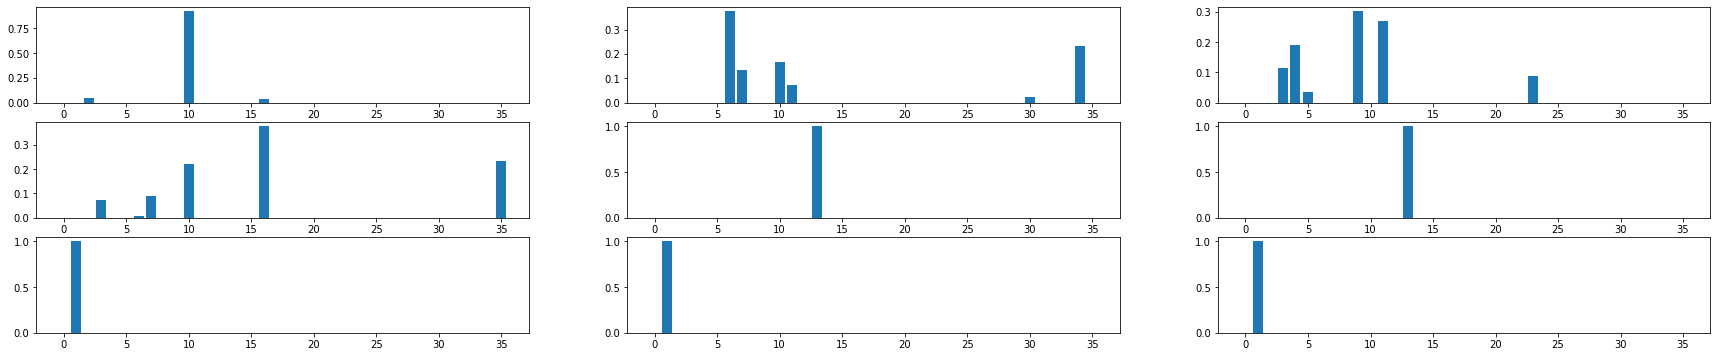

Phase 37
./tmp2/NYSE_phase37_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


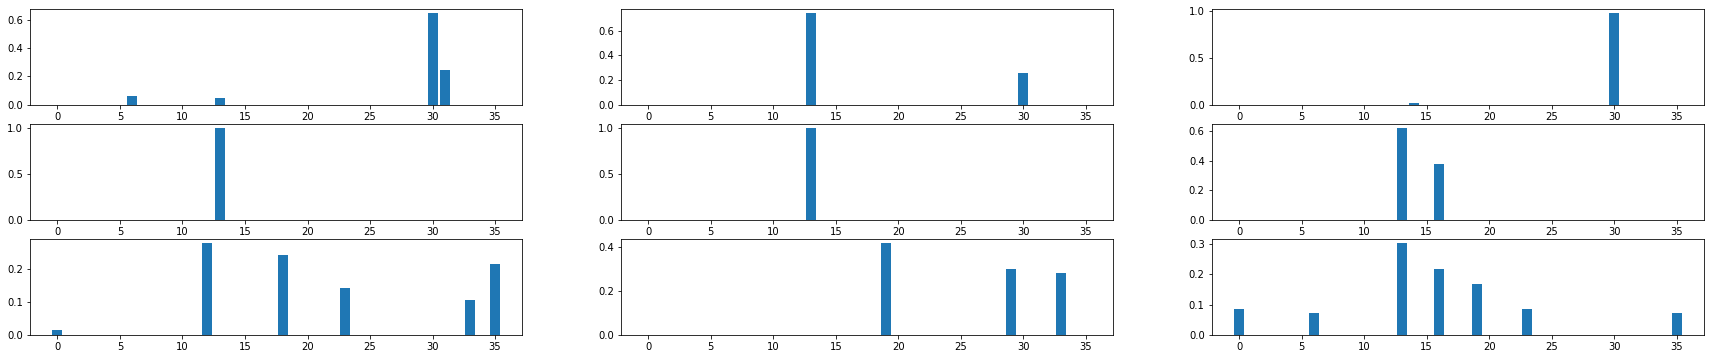

Phase 38
./tmp2/NYSE_phase38_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


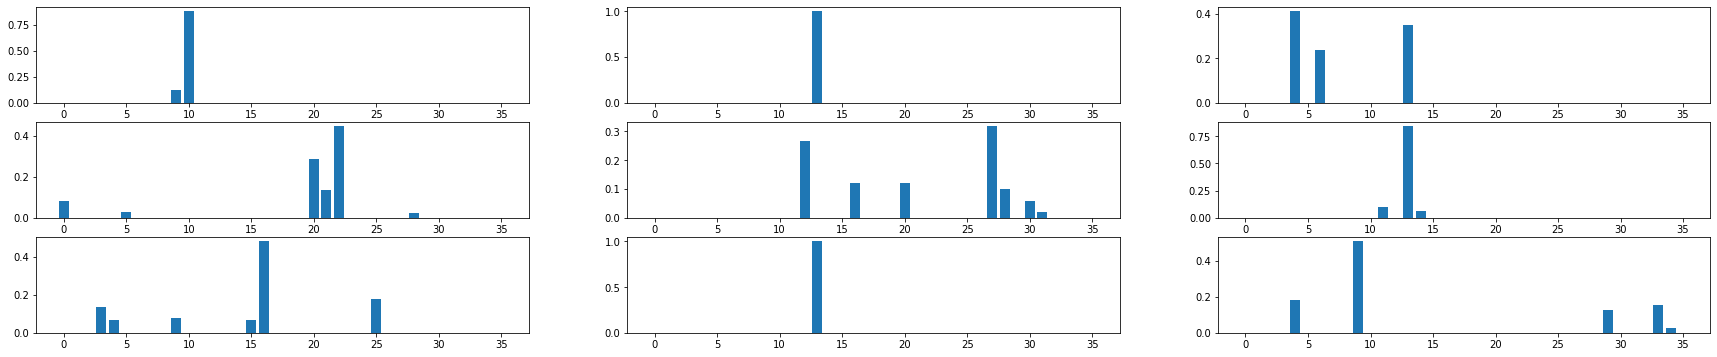

Phase 39
./tmp2/NYSE_phase39_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


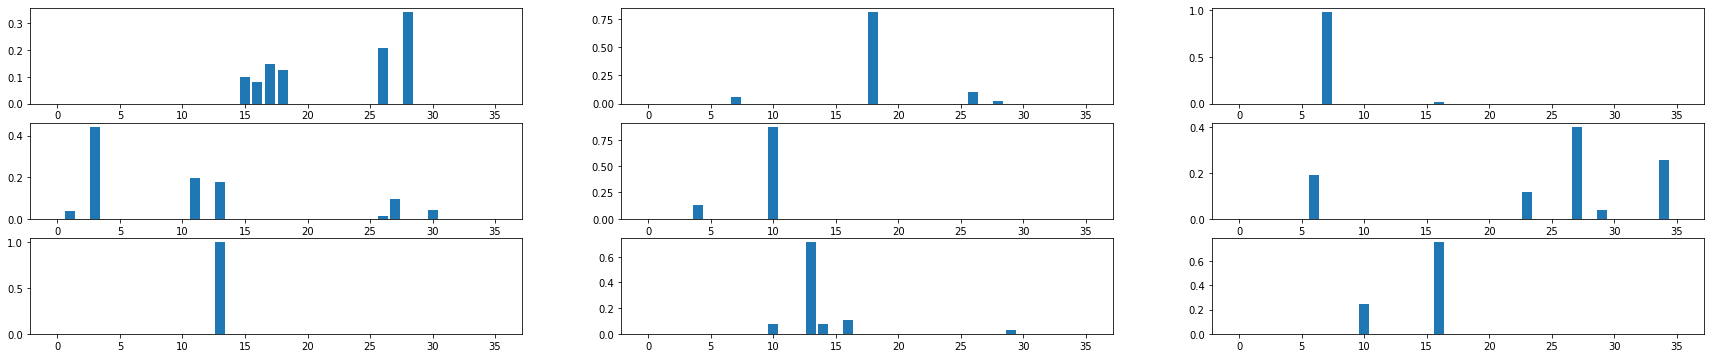

Phase 40
./tmp2/NYSE_phase40_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


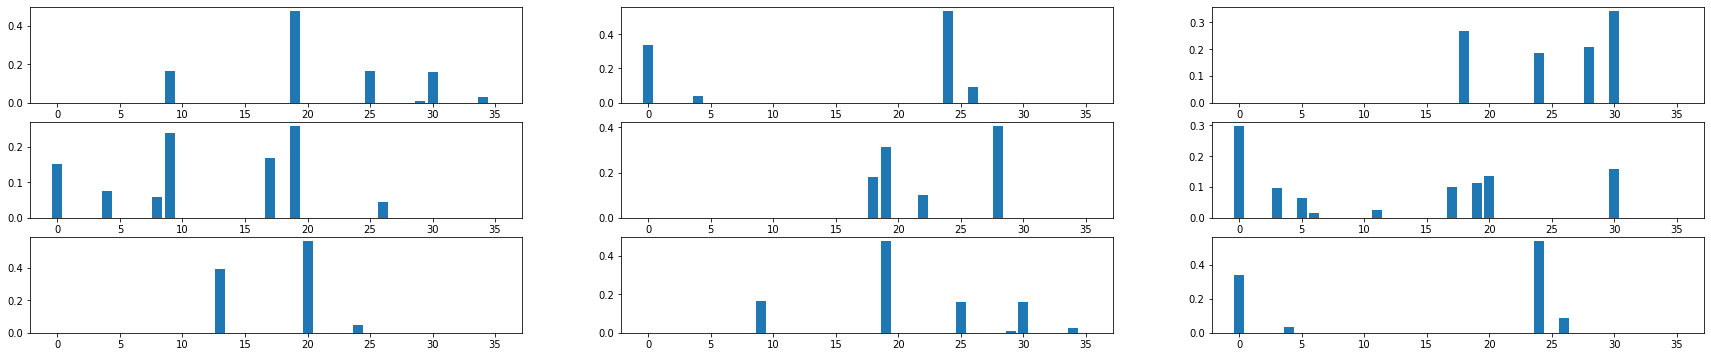

Phase 41
./tmp2/NYSE_phase41_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


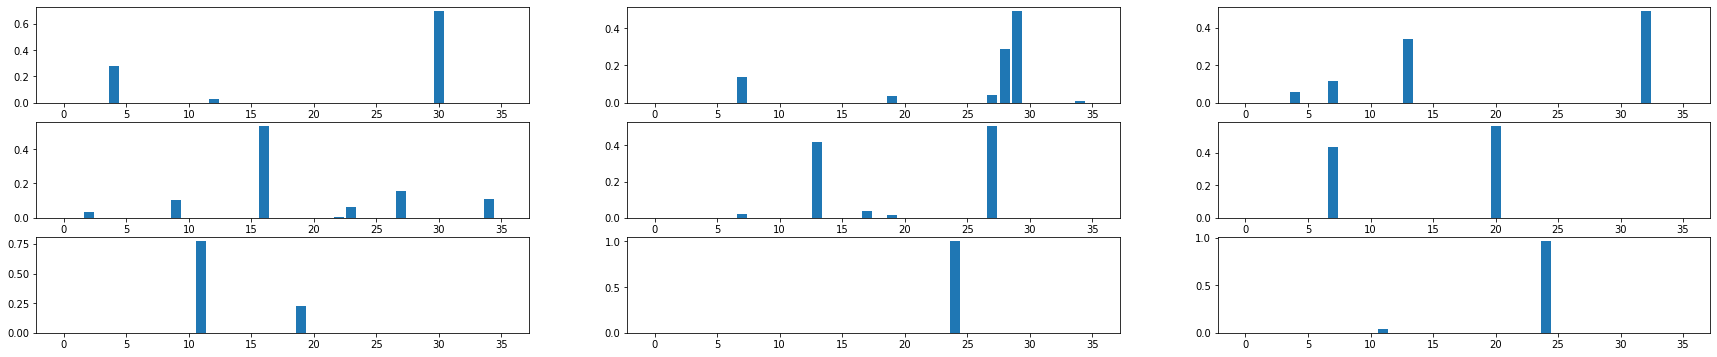

Phase 42
./tmp2/NYSE_phase42_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


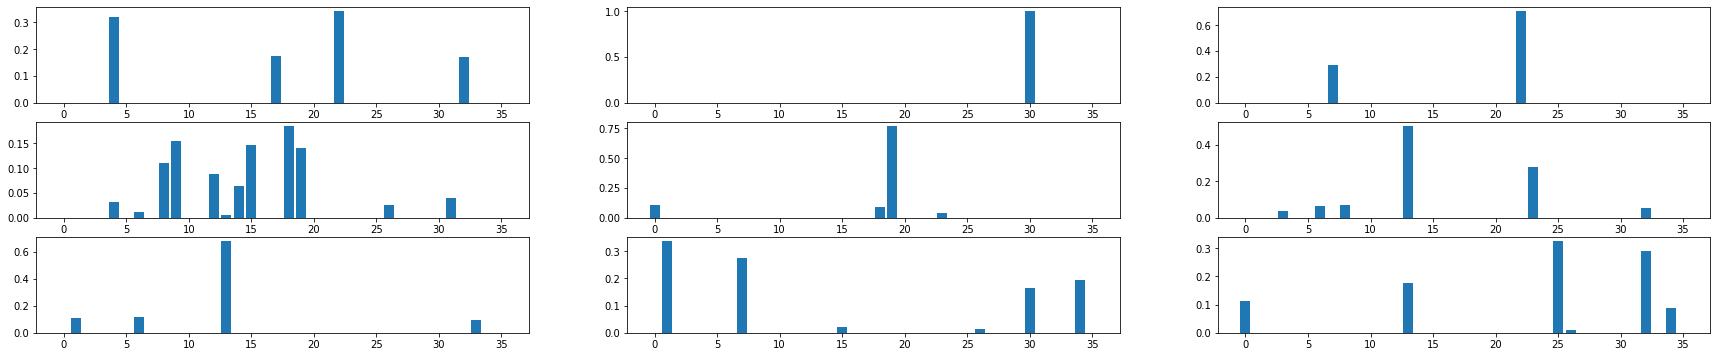

Phase 43
./tmp2/NYSE_phase43_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


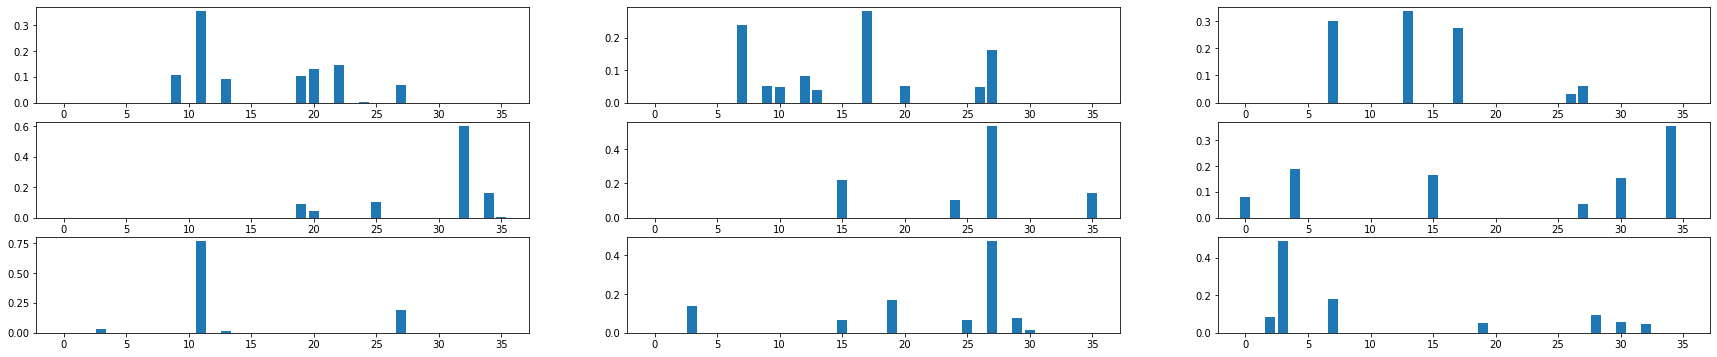

Phase 44
./tmp2/NYSE_phase44_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


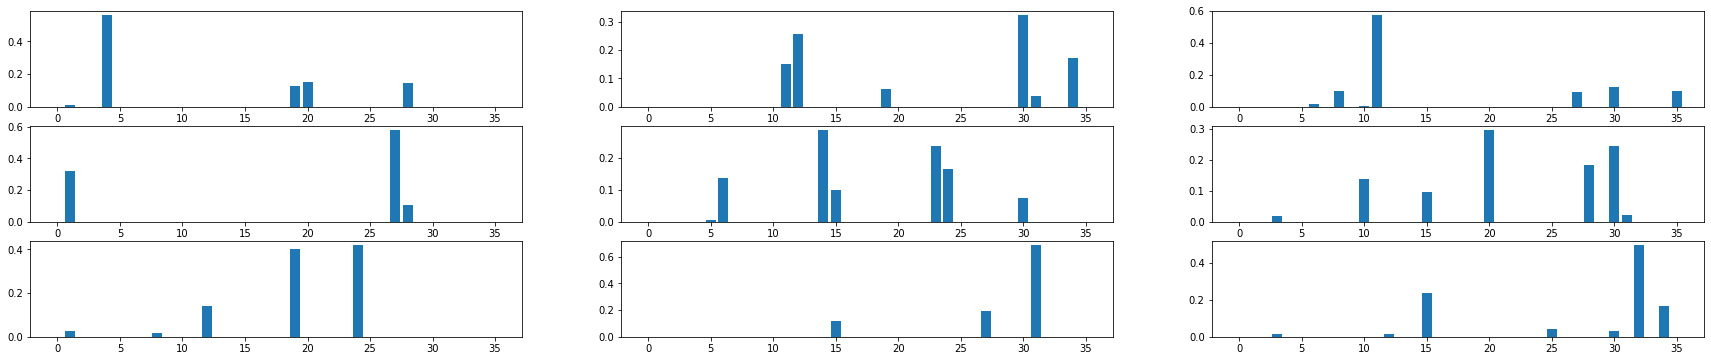

Phase 45
./tmp2/NYSE_phase45_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


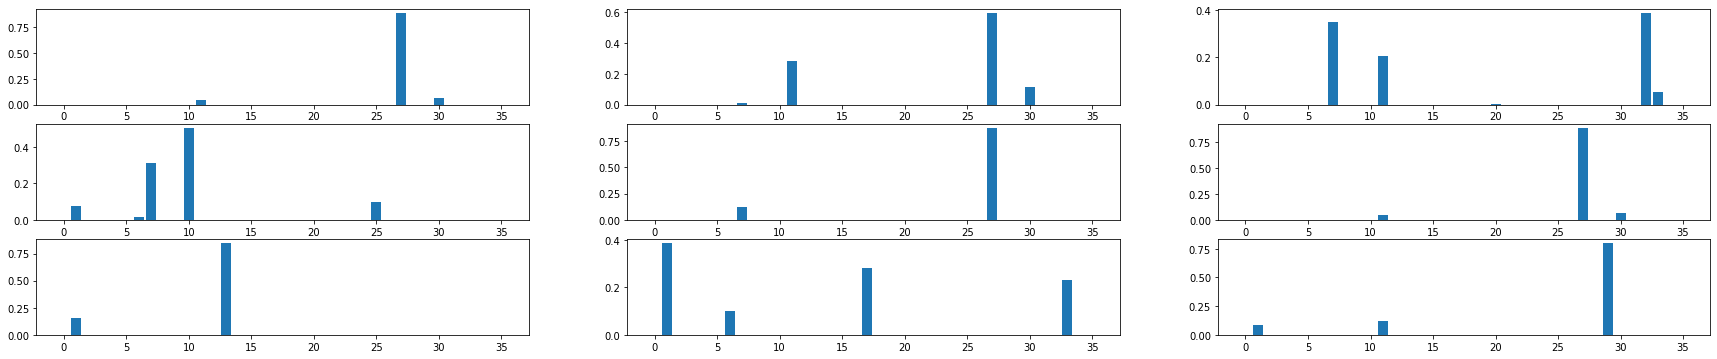

Phase 46
./tmp2/NYSE_phase46_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


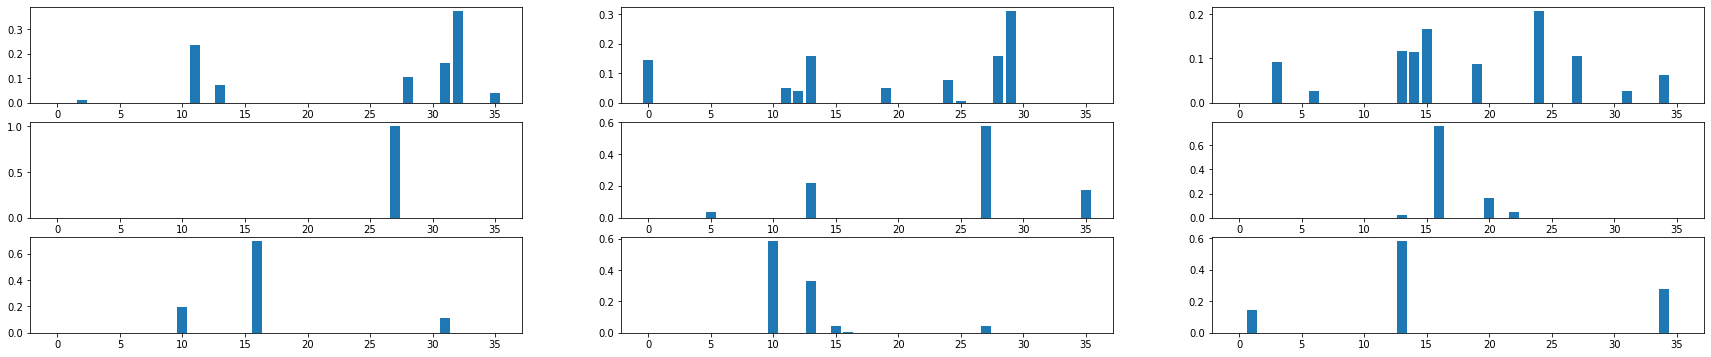

Phase 47
./tmp2/NYSE_phase47_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


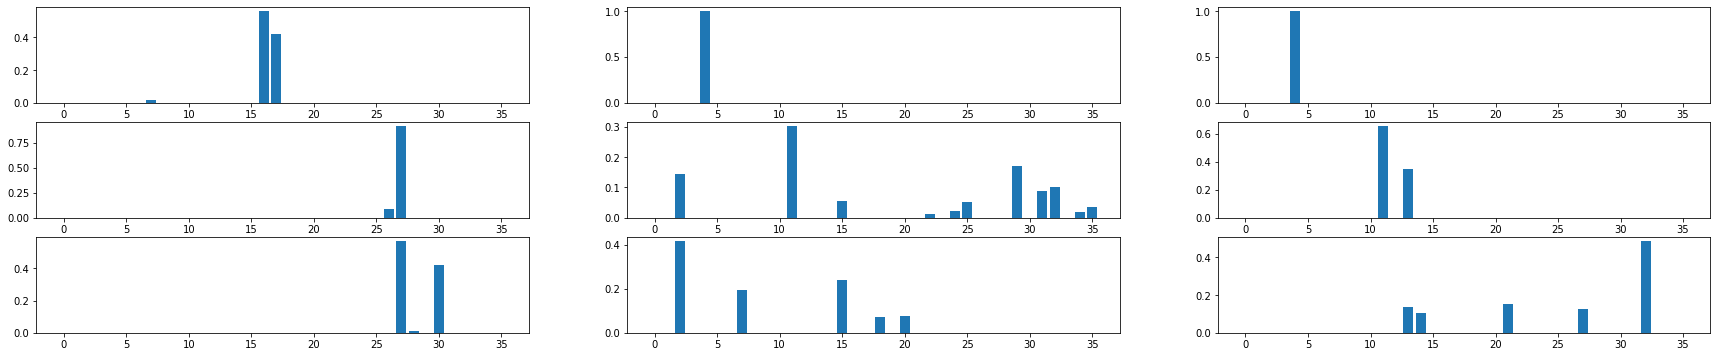

Phase 48
./tmp2/NYSE_phase48_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


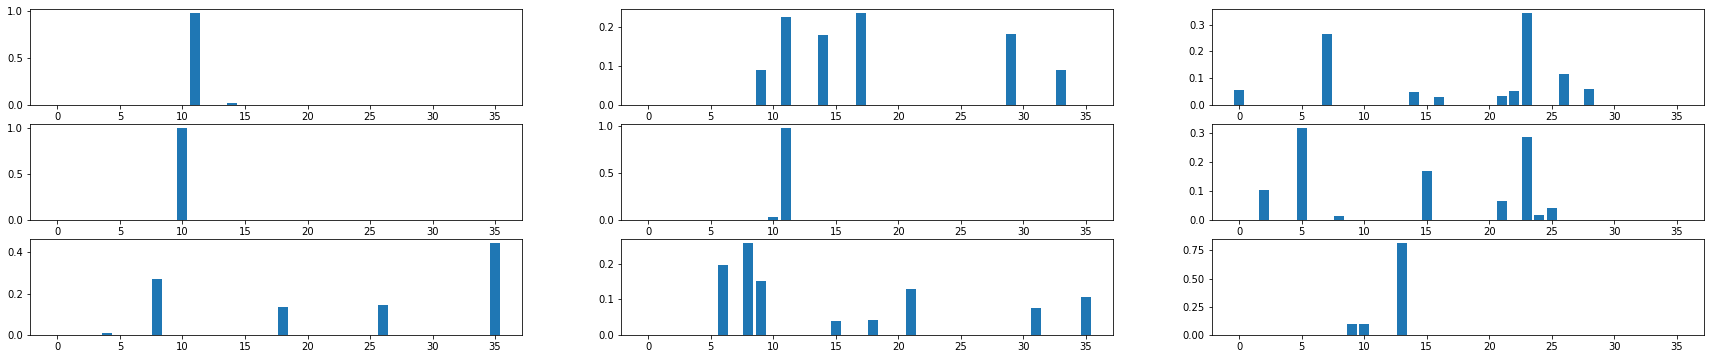

Phase 49
./tmp2/NYSE_phase49_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


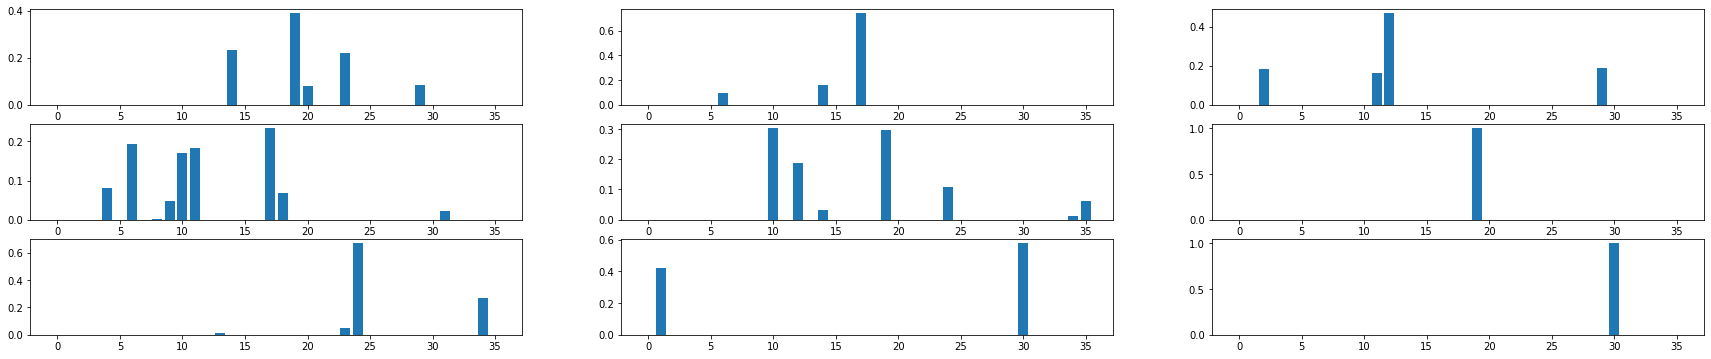

Phase 50
./tmp2/NYSE_phase50_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


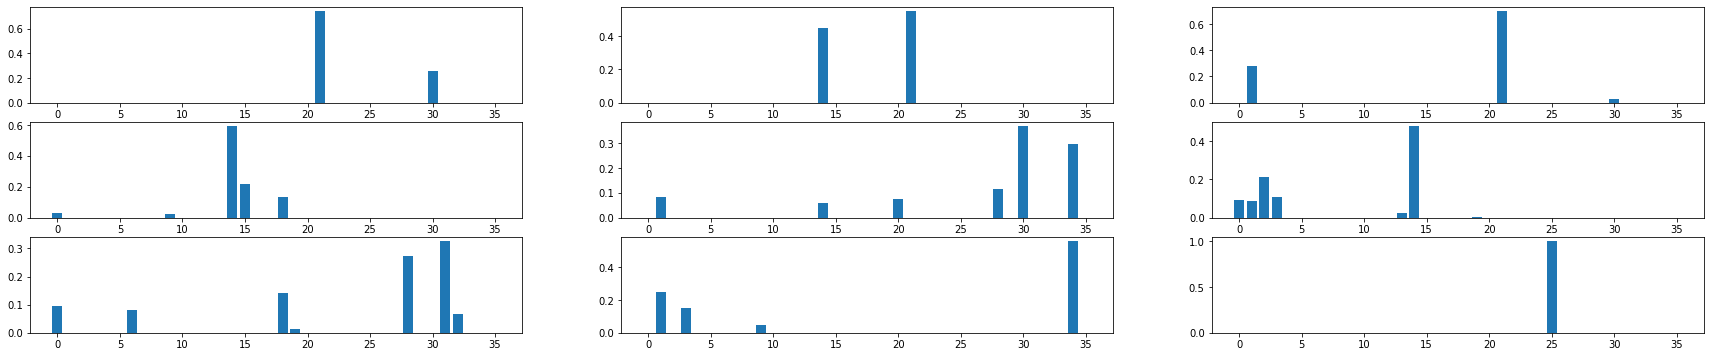

Phase 51
./tmp2/NYSE_phase51_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


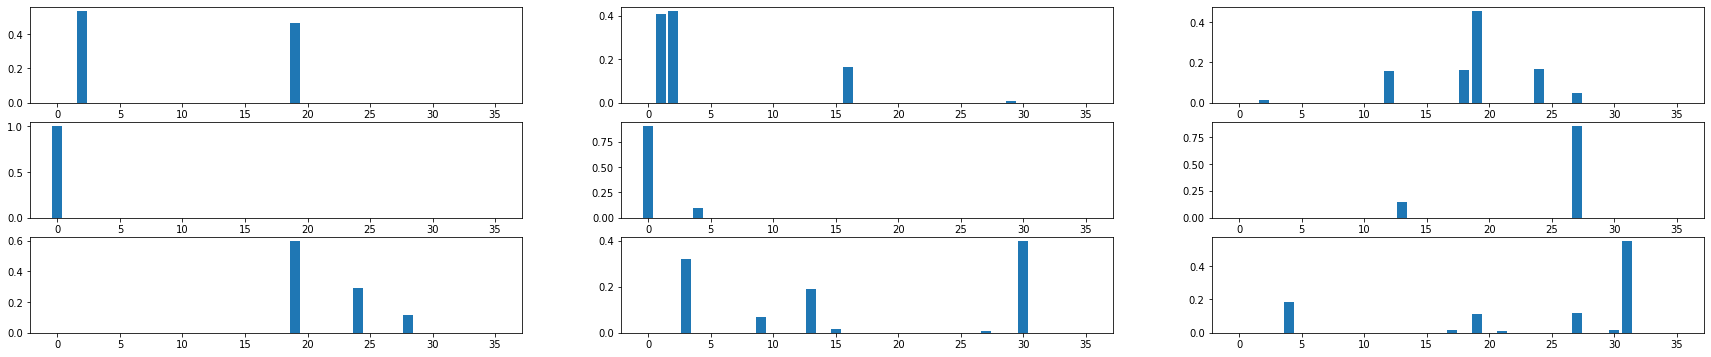

Phase 52
./tmp2/NYSE_phase52_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


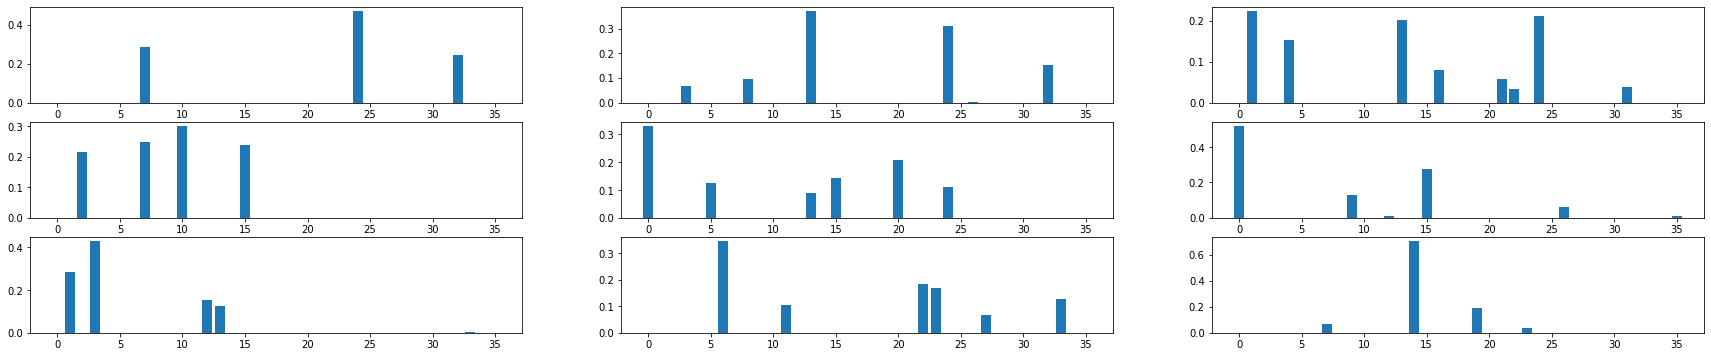

In [29]:
paras={'dataset':'NYSE', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1, 'passive_gamma':0,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=53)

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 2.03
    Sharpe ratio: 3.52 ± 0.58
    Ulcer index: 23.60
    Information ratio (wrt UCRP): 3.49
    Appraisal ratio (wrt UCRP): 3.25 ± 0.22
    UCRP sharpe: 1.10 ± 0.28
    Beta / Alpha: 1.46 / 143.415%
    Annualized return: 366.87%
    Annualized volatility: 46.94%
    Longest drawdown: 140 days
    Max drawdown: 37.46%
    Winning days: 58.3%
    Annual turnover: 374.7
        
Total wealth: 118660154927464.86


<Figure size 720x360 with 0 Axes>

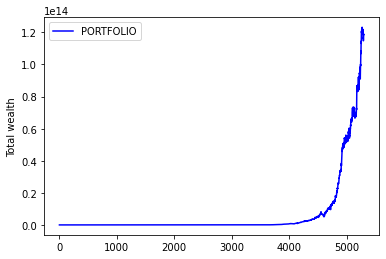

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.32
    Sharpe ratio: 1.55 ± 0.32
    Ulcer index: 3.26
    Information ratio (wrt UCRP): 1.34
    Appraisal ratio (wrt UCRP): 1.15 ± 0.22
    UCRP sharpe: 1.10 ± 0.28
    Beta / Alpha: 1.45 / 50.126%
    Annualized return: 84.64%
    Annualized volatility: 46.29%
    Longest drawdown: 618 days
    Max drawdown: 70.88%
    Winning days: 45.6%
    Annual turnover: 374.7
        
Total wealth: 399478.46645793645


<Figure size 720x360 with 0 Axes>

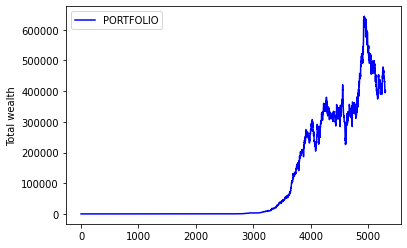

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.87
    Sharpe ratio: -0.47 ± 0.23
    Ulcer index: -0.23
    Information ratio (wrt UCRP): -0.88
    Appraisal ratio (wrt UCRP): -1.00 ± 0.22
    UCRP sharpe: 1.10 ± 0.28
    Beta / Alpha: 1.44 / -43.162%
    Annualized return: -27.27%
    Annualized volatility: 45.75%
    Longest drawdown: 5139 days
    Max drawdown: 99.93%
    Winning days: 37.0%
    Annual turnover: 374.7
        
Total wealth: 0.0012359999610535434


<Figure size 432x288 with 0 Axes>

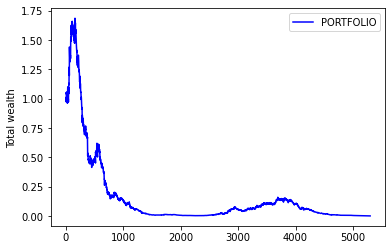

In [30]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)